# Computational Challenge #4

In this challenge you will implement stochastic simulations of two synthetic biological circuits. The synthetic genetic switch, and the repressilator were described in two back–to–back papers in Nature in 2000. Please follow the link on the website to the two papers.

In this challenge two groups will report on the deterministic version of models of these circuits, while the other two will report on the stochastic versions. The last part of each question asks that you compare the results of the simulations. Therefore groups 1 and 2, and groups 3 and 4 will need to work together on each project.

Group #4

Consider the stochastic repressilator described in Loinger, et al (the one discussing the repressilator) and in Elowitz and Leibler.

- Using both repressilator papers as a guide, write down a Master equation describing the stochastic version of Eq. 1 of Loinger (i.e., a simple repressilator with reactions as described in the Michaelis-Menten kinetics section of that paper).

- Suggest a method for detecting oscillation-like behavior in a stochastic process. Apply your method to stochastic simulations of the simple repressilator for some of the same cases considered by Group 3 above (i.e., you do not need attempt a full phase portrait, but choose a few parameter sets that correspond to those explored by group 3, and try to find at least one case where oscillations appear to be happening).


Reactions and their corresponding rates are as follows:

$m_{i} \rightarrow m_{i} +1$ $\;\;\;\;\;\;$  $g_m/1+K[X_{i-1}]^n $ 

$m_{i} \rightarrow m_{i} -1$ $\;\;\;\;\;\;$  $d_mm_{i}$ 

$X_{i} \rightarrow X_{i} +1$ $\;\;\;\;\;\;$  $g_pm_{i}$

$X_{i} \rightarrow X_{i} -1$ $\;\;\;\;\;\;$  $d_pX_{i}$



We know:


$$\frac{dP(x,t)}{dt} = \sum_{j=1}^M (a_j(x-v_j)P(x-v_j,t) - a_jxP(x,t))$$

Therefore:


$$\frac{dP(m,x,t)}{dt} = \frac{g_m}{1+K[x_{i-1}]^n} P(m-1,x,t) -  \frac{g_m}{1+K[x_{i-1}]^n} P(m,x,t) +d_m(m+1)P(m+1,x,t) -d_m(m)P(m,x,t)+ g_pm P(m,x-1,t) - g_pm P(m,x,t)+d_p (x+1) P(m,x+1,t) - d_px P(m,x,t)$$

<br>
<br>
<br>

$$\frac{dP(m_1,m_2,m_3,x_1,x_2,x_3,t)}{dt} = \sum_{j =1,2,3}\frac{g_m}{1+K[x_{i-1}]^n} P(...,m_{i}-1,x_1,x_2,x_3,t) -  \frac{g_m}{1+K[x_{i-1}]^n} P(m_1,m_2,m_3,x_1,x_2,x_3,t) +d_m(m_i+1)P(...,m_{i}+1,x_1,x_2,x_3,t) -d_m(m_i)P(m_1,m_2,m_3,x_1,x_2,x_3,t)+ g_pm_i P(m_1,m_2,m_3,...,x_{i}-1,t) - g_pm_i P(m_1,m_2,m_3,x_1,x_2,x_3,t)+d_p (x_{i}+1) P(m_1,m_2,m_3,...,x_{i}+1,t) - d_px_i P(m_1,m_2,m_3,x_1,x_2,x_3,t)$$



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import bisect
from scipy.integrate import odeint
import statsmodels.api as sm
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import splrep,splev
import warnings
warnings.filterwarnings("ignore")

Define the function that simulates the reaction.

In [6]:
def rep(n = 2,k=1,dm=10,dp=10,gm=10,gp=10,number_of_protein=[10,10,10],\
           number_of_mRNA=[10,10,10],current_time=0,MAX_TIME = 100):
    time = []
    mRNA_production_rate={}
    mRNA_degradation_rate={}
    protein_production_rate={}
    protein_degradation_rate={}
    protein_tracker={}
    mRNA_tracker={}
    for i in range(3):
        protein_tracker[i]=np.array([])
        mRNA_tracker[i]=np.array([])
    while current_time < MAX_TIME:
        a=np.array([])
        for i in range(3):
#         mRNA_rate[i]= ((gm/(1+k*(number_of_protein[(i+2)%3])))-(dm * number_of_mRNA[i]))
#         protein_rate[i]=((gp * number_of_mRNA[i]) - (dp * number_of_protein[i]))
            mRNA_production_rate[i]= gm/(1+k*((number_of_protein[(i+2)%3])**n))
    
            protein_production_rate[i]=gp * number_of_mRNA[i]
            mRNA_degradation_rate[i]= dm * number_of_mRNA[i]       
            protein_degradation_rate[i]=dp * number_of_protein[i]
            a=np.append(a,np.array([mRNA_production_rate[i],protein_production_rate[i],\
                   mRNA_degradation_rate[i],protein_degradation_rate[i]]))
        a_sum=np.cumsum(a)  
        current_time += -np.log(np.random.rand()) / np.max(a_sum)
        time.append(current_time)
#     reaction_index=0
#     r=np.random.rand()
#     if len(np.where(a_sum < (r *np.max(a_sum)))[0])!=0:
        reaction_index=np.where(a_sum > (np.random.rand() *np.max(a_sum)))[0][0]
#     else:
#         reaction_index=(np.max(np.where(a_sum < (np.random.rand() *np.max(a_sum)))[0])+1)
    
    ## Change of protein 3
        if reaction_index == 0:
            number_of_mRNA[0] += 1
        elif reaction_index == 1:
            number_of_protein[0] += 1
        elif reaction_index == 2:
            number_of_mRNA[0] -= 1
        elif reaction_index == 3:
            number_of_protein[0] -= 1

        ## Change of Protein 1
        elif reaction_index == 4:
            number_of_mRNA[1] += 1
        elif reaction_index == 5:
            number_of_protein[1] += 1
        elif reaction_index == 6:
            number_of_mRNA[1] -= 1
        elif reaction_index == 7:
            number_of_protein[1] -= 1

        #Change of protein 2
        elif reaction_index == 8:
            number_of_mRNA[2] += 1
        elif reaction_index == 9:
            number_of_protein[2] += 1
        elif reaction_index == 10:
            number_of_mRNA[2] -= 1
        elif reaction_index == 11:
            number_of_protein[2] -= 1

        for i in range(3):
            protein_tracker[i]=np.append(protein_tracker[i],number_of_protein[i])
            mRNA_tracker[i]=np.append(mRNA_tracker[i],number_of_mRNA[i]) 
    return protein_tracker,mRNA_tracker,time

In [7]:
protein_tracker={}
mRNA_tracker={}
time={}
for n in [1,2,3]:
    for dp in [0.01,0.1,1,10]:
        for gm in [0.01,0.1,1,10]:
            for number_of_protein1 in [[10,10,10],[5,10,15]]:
                for number_of_mRNA1 in [[10,10,10],[5,10,15]]:
                    name="n = "+str(n)+" gm = "+str(gm)+" dp = gp = " +str(dp) +\
                        " Number of proteins at the begining = "+str(number_of_protein1[0])+','+str(number_of_protein1[1])+\
                        ','+str(number_of_protein1[2])+ " Number of mRNAs at the begining = "+str(number_of_mRNA1[0])+\
                        ','+str(number_of_mRNA1[1])+',' +str(number_of_mRNA1[2])
                        
                    protein_tracker[name],mRNA_tracker[name],time[name]=\
                         rep(n = n,k=1,dm=1,dp=dp,gm=gm,gp=dp,number_of_protein=number_of_protein1,\
                           number_of_mRNA=number_of_mRNA1)

In [5]:
len(list(time.keys()))

179

ValueError: Unrecognized location 'bottom right'. Valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center


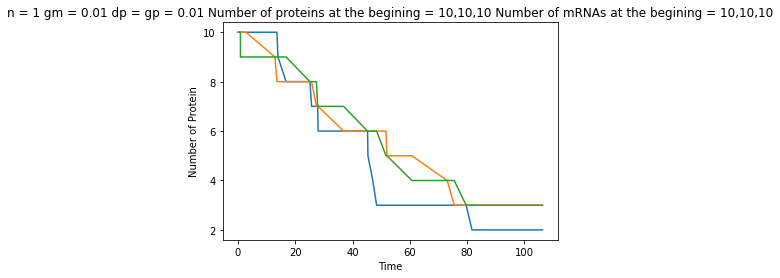

In [4]:
for name in list(time.keys()):
    plt.title(name)
    plt.xlabel("Time")
    plt.ylabel("Number of Protein")
    plt.rcParams.update({'font.size': 15})
    for i in range(1,4):
        plt.plot(time[name],protein_tracker[name][i%3],label="protein type "+str(i))
    plt.rcParams['figure.figsize'] = 10, 10
    plt.legend(bbox_to_anchor=(1.01, 1), loc='bottom right')
    plt.show()

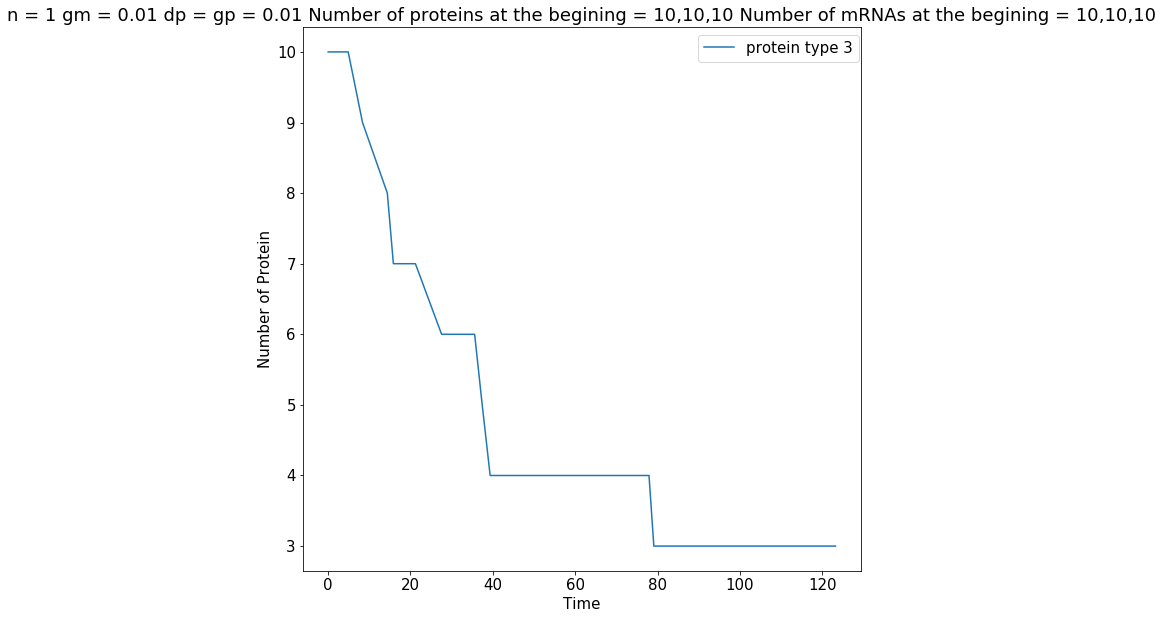

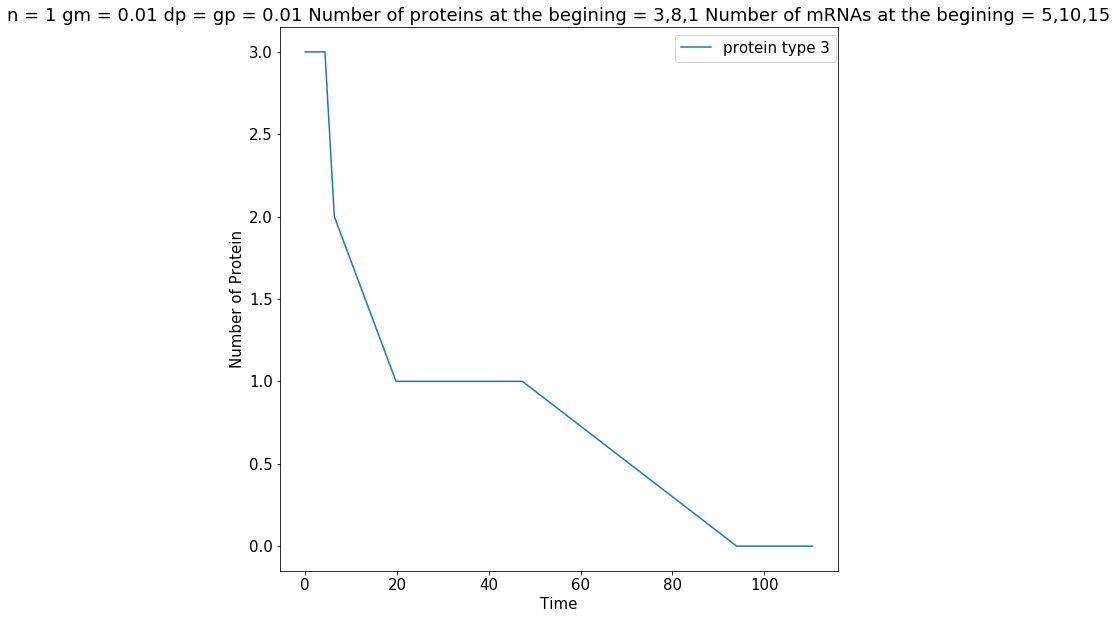

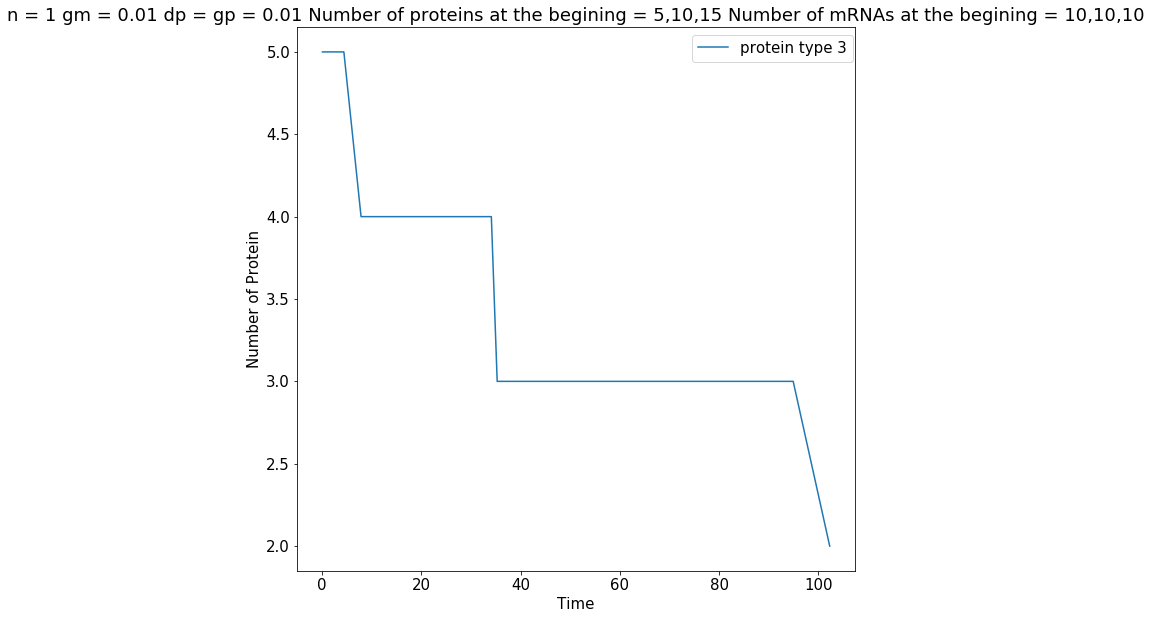

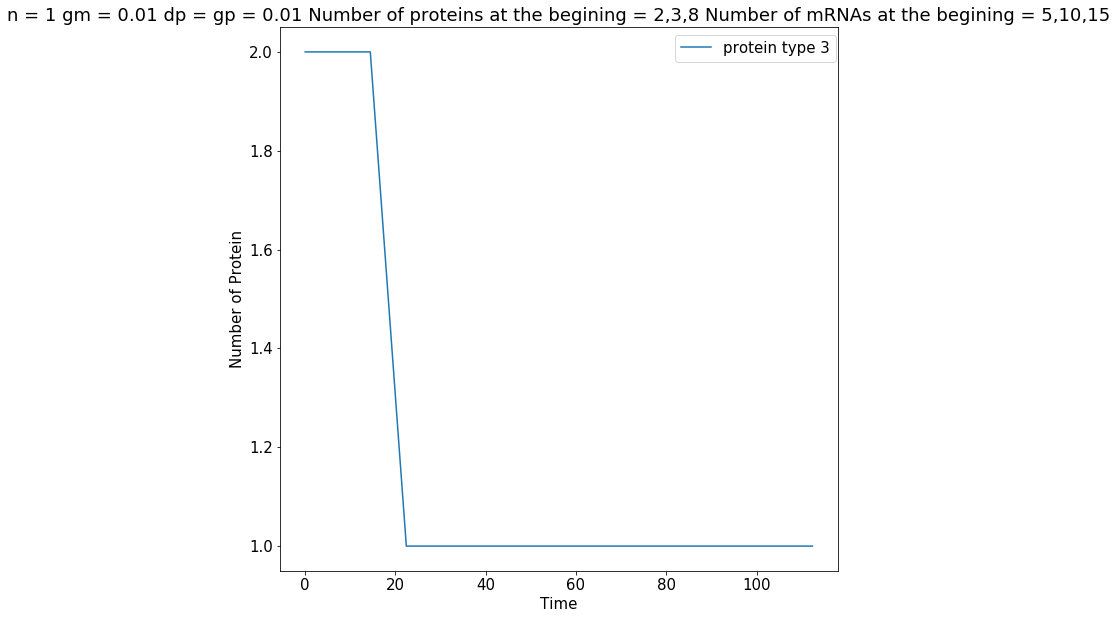

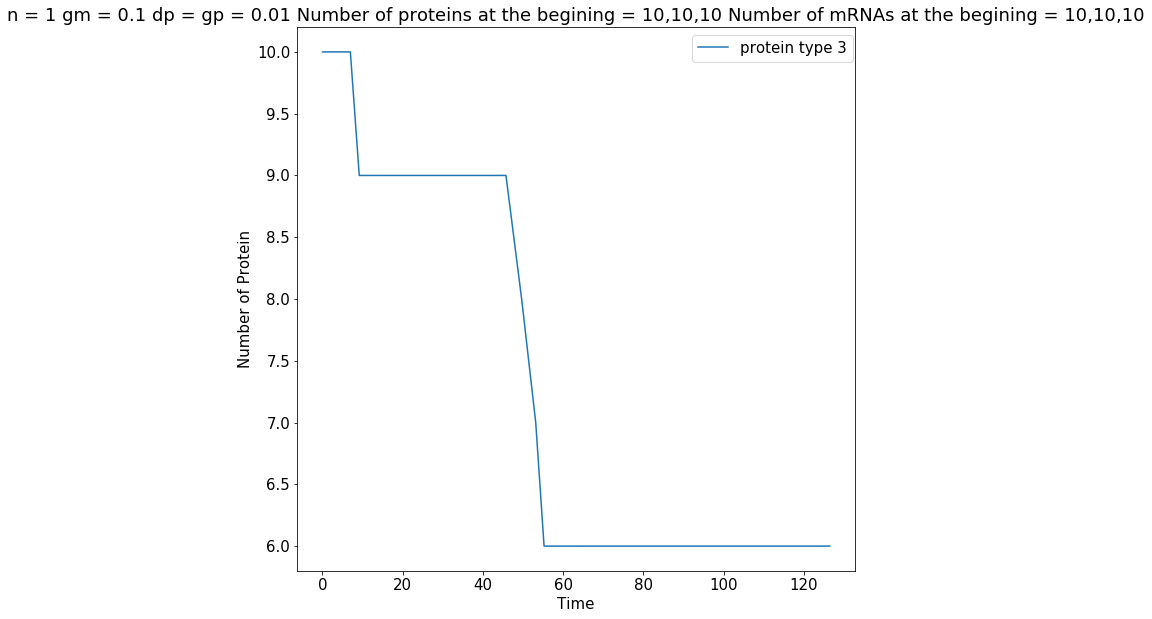

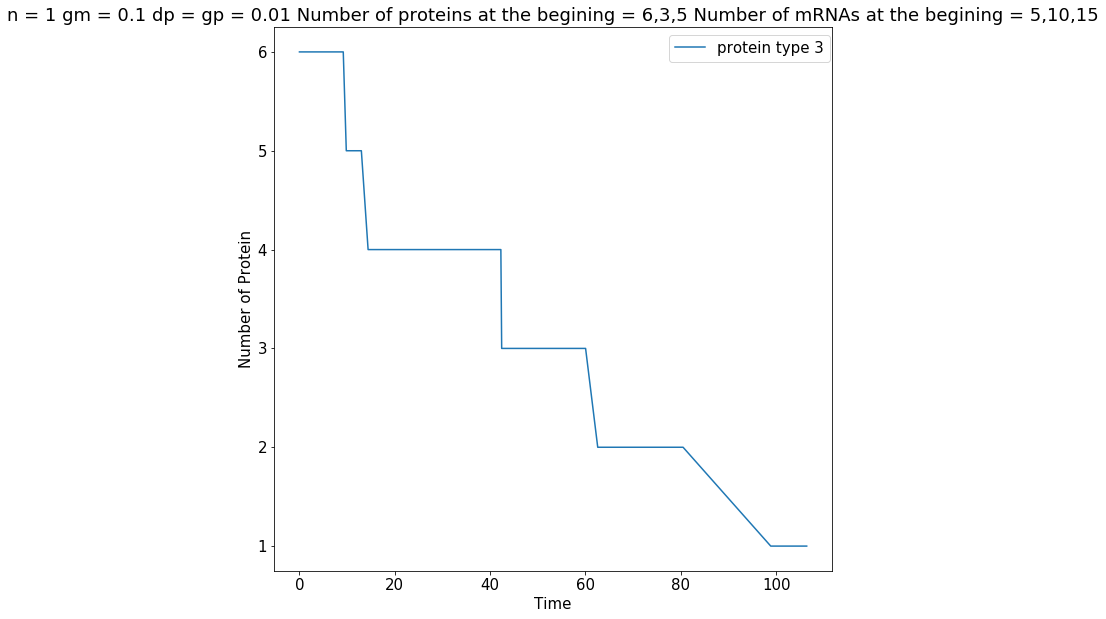

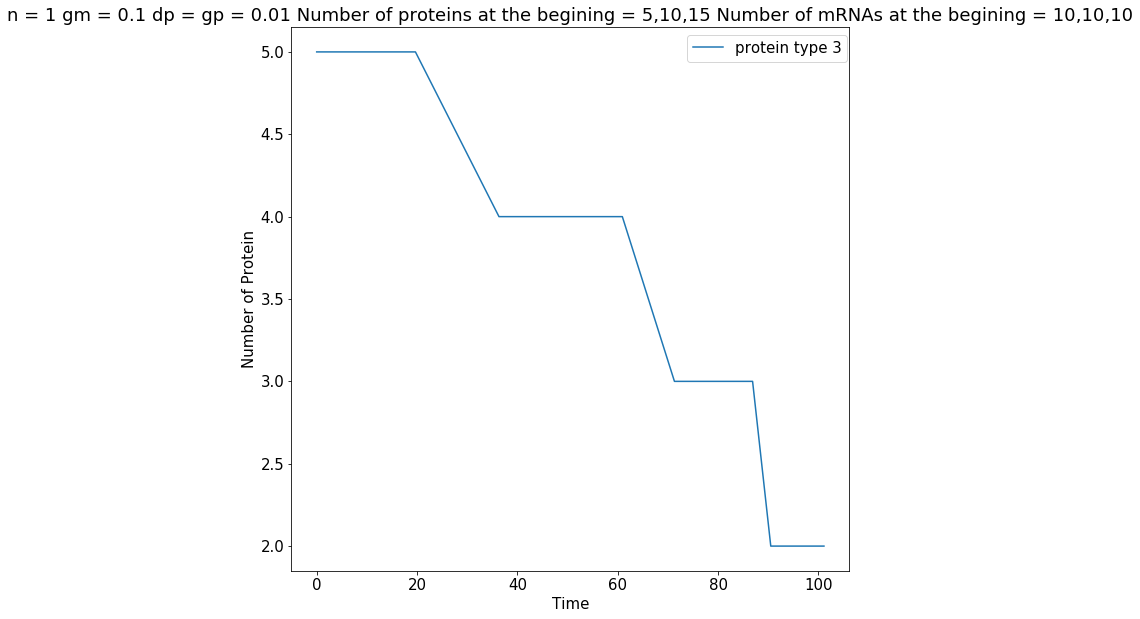

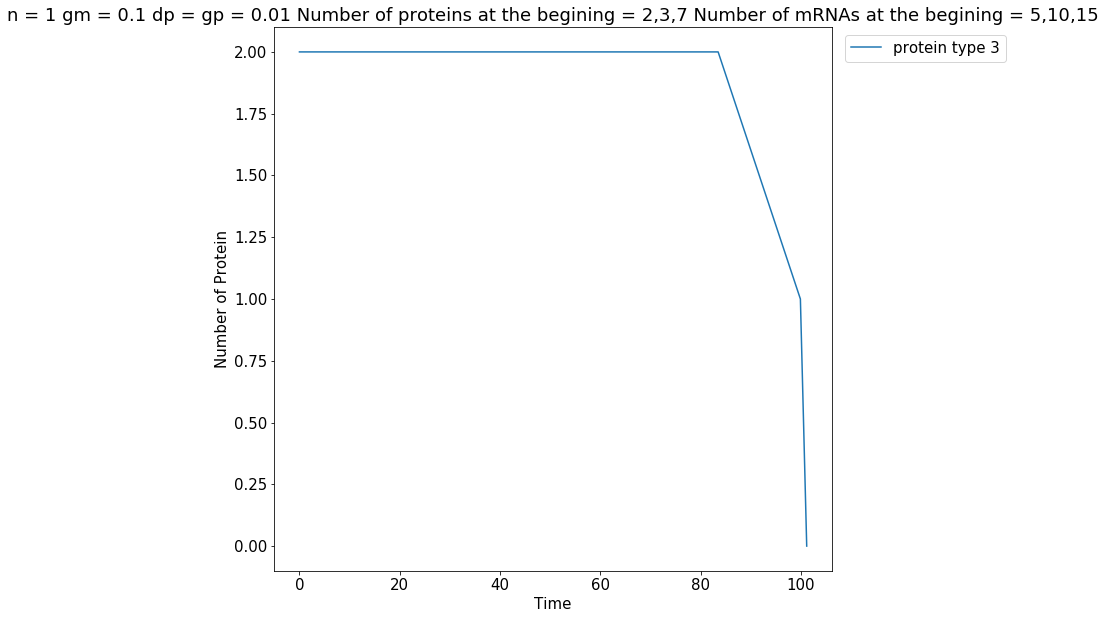

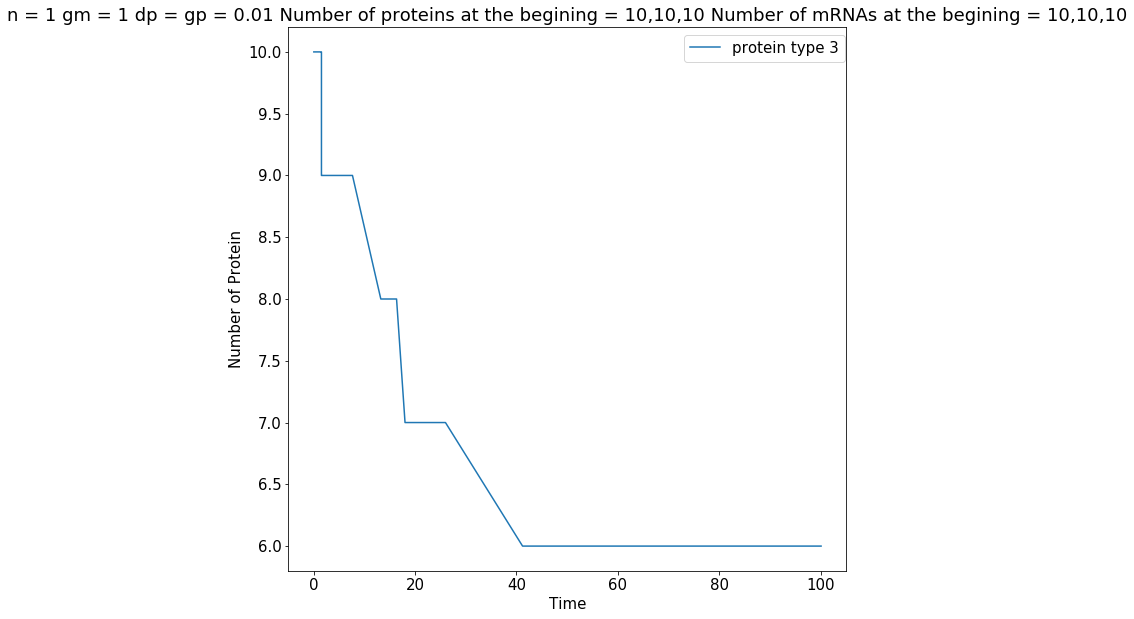

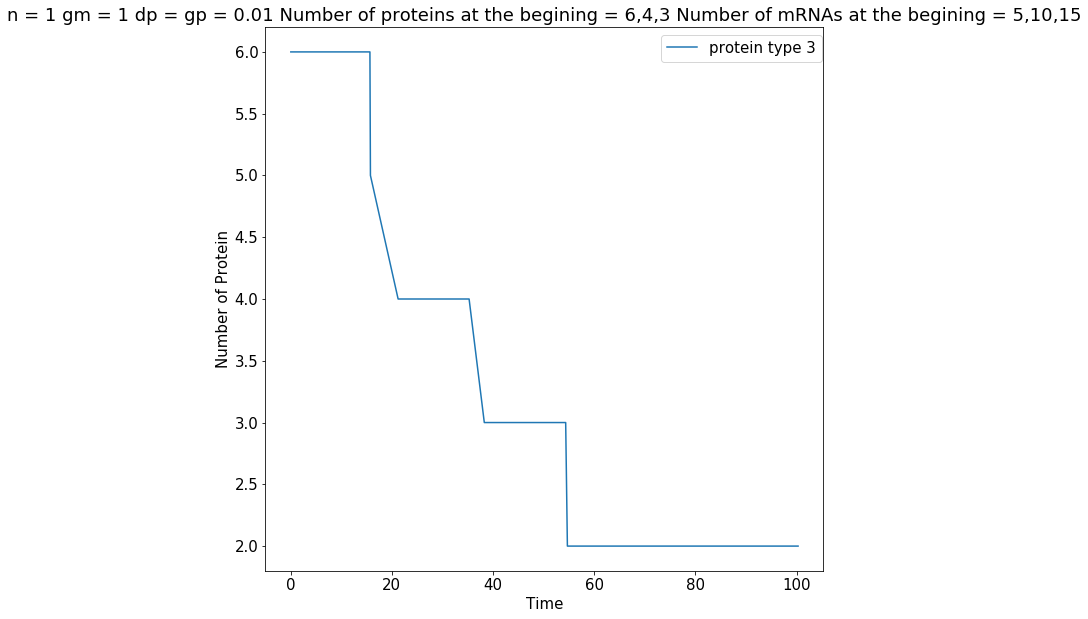

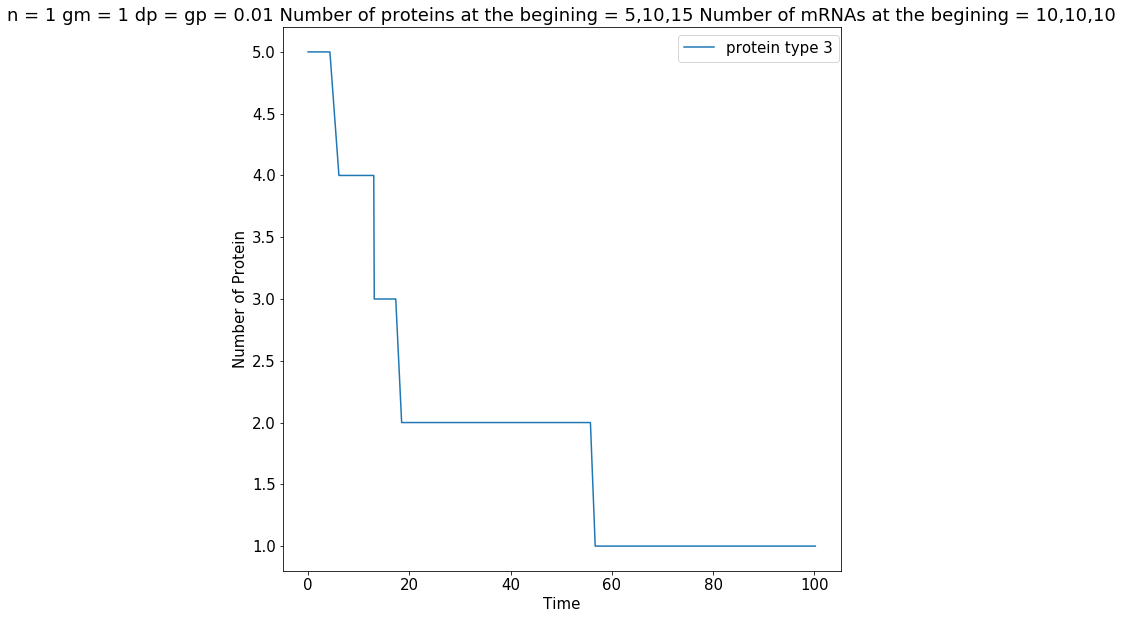

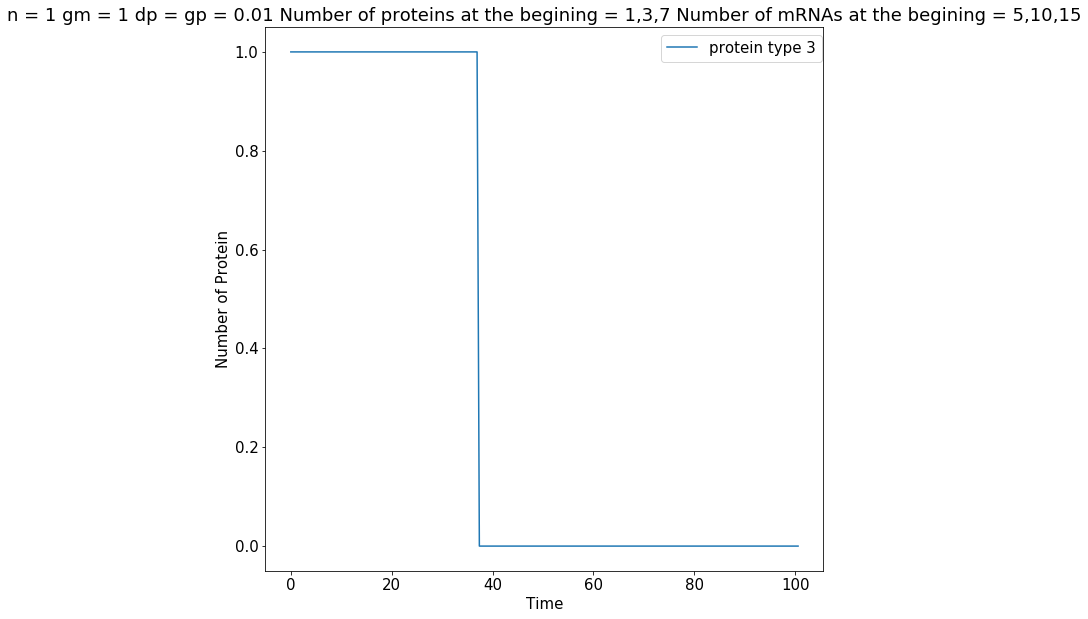

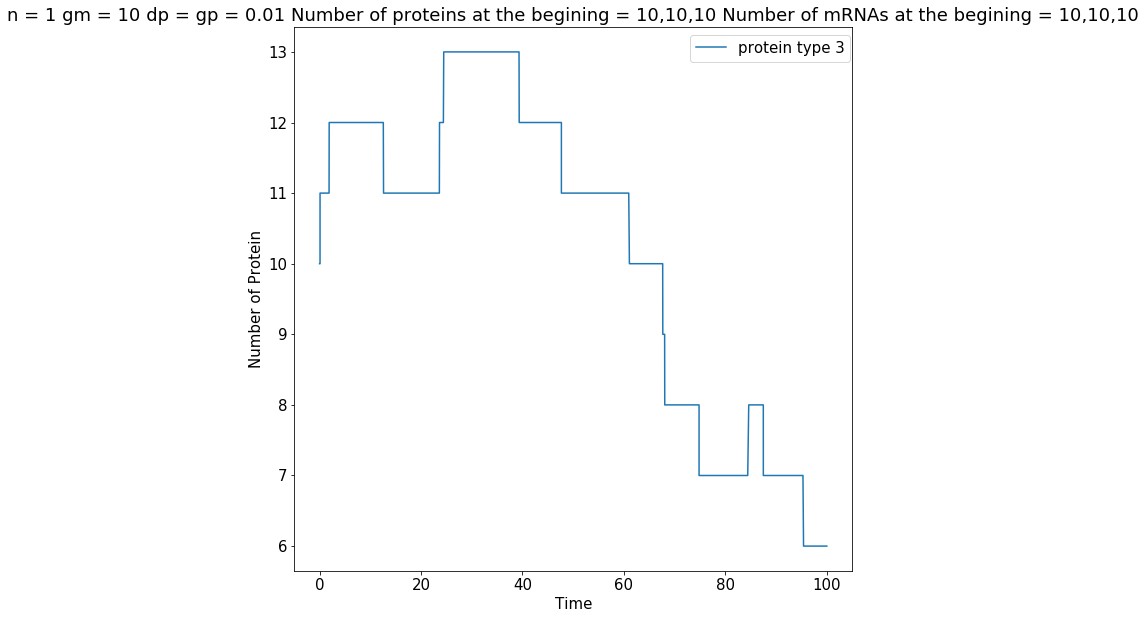

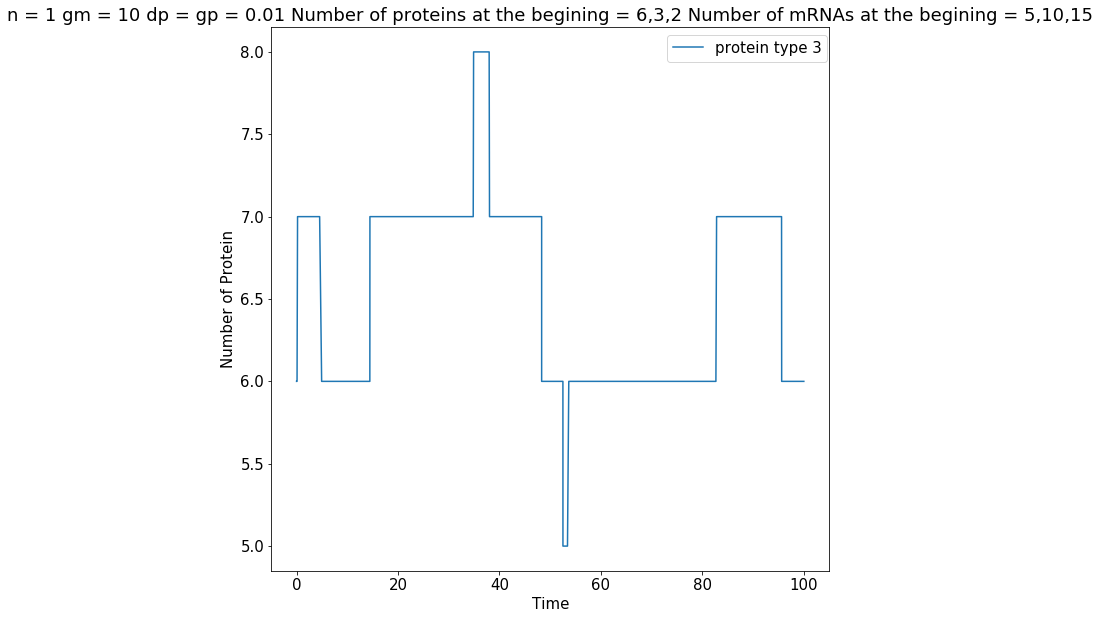

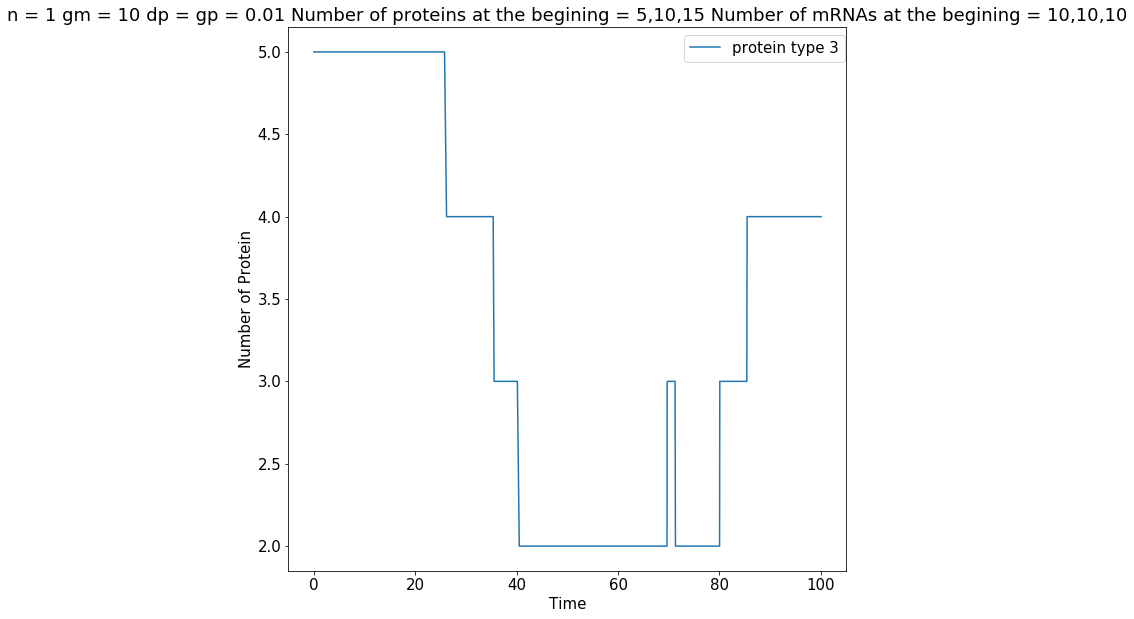

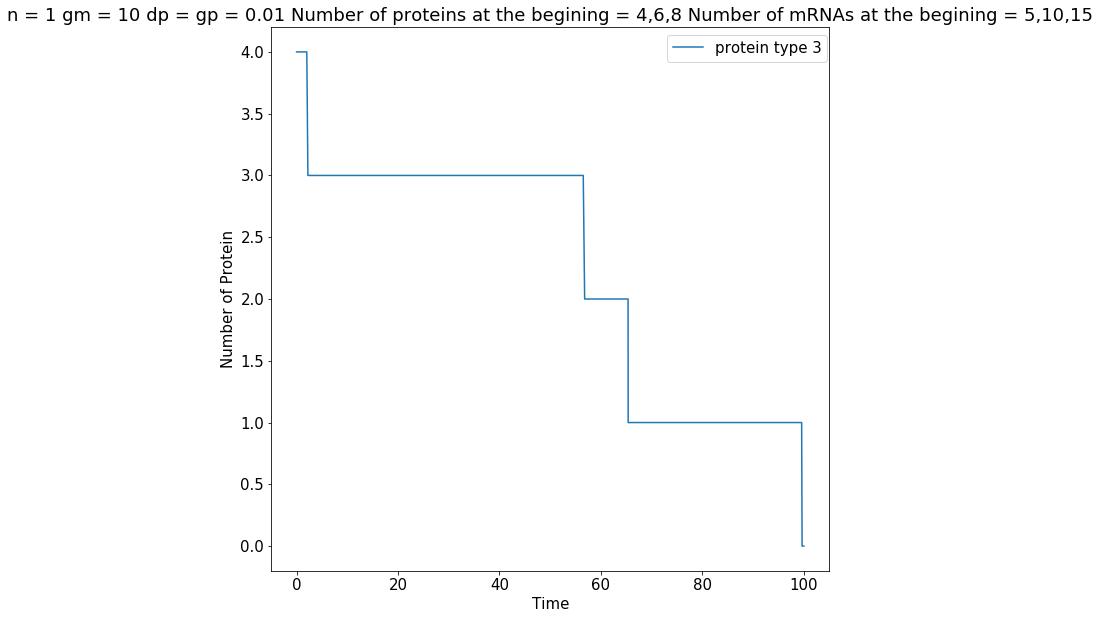

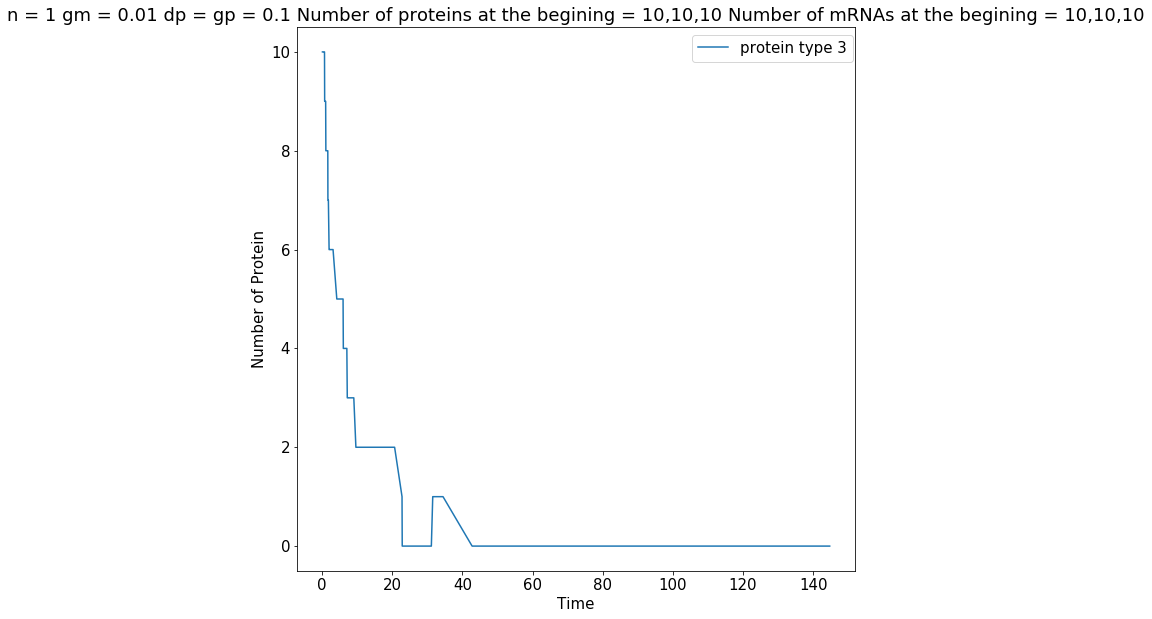

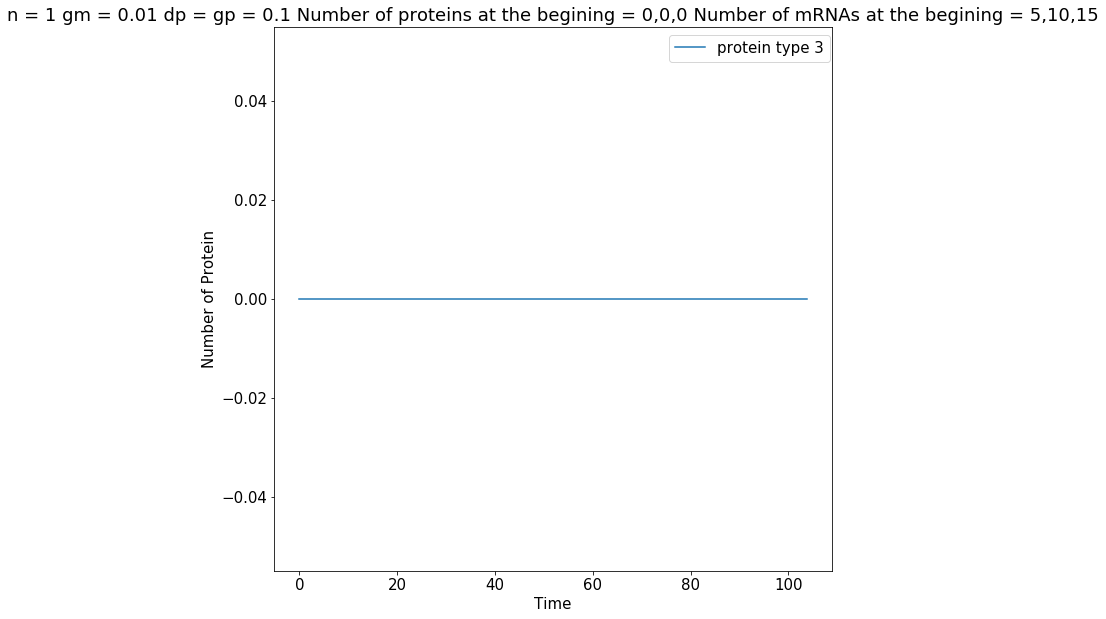

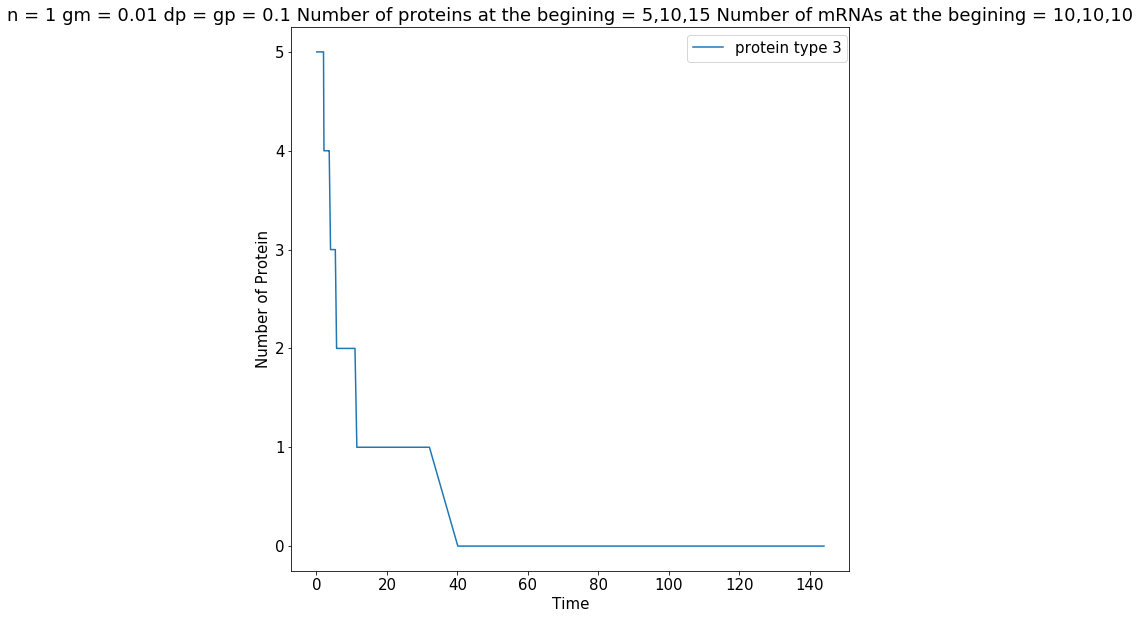

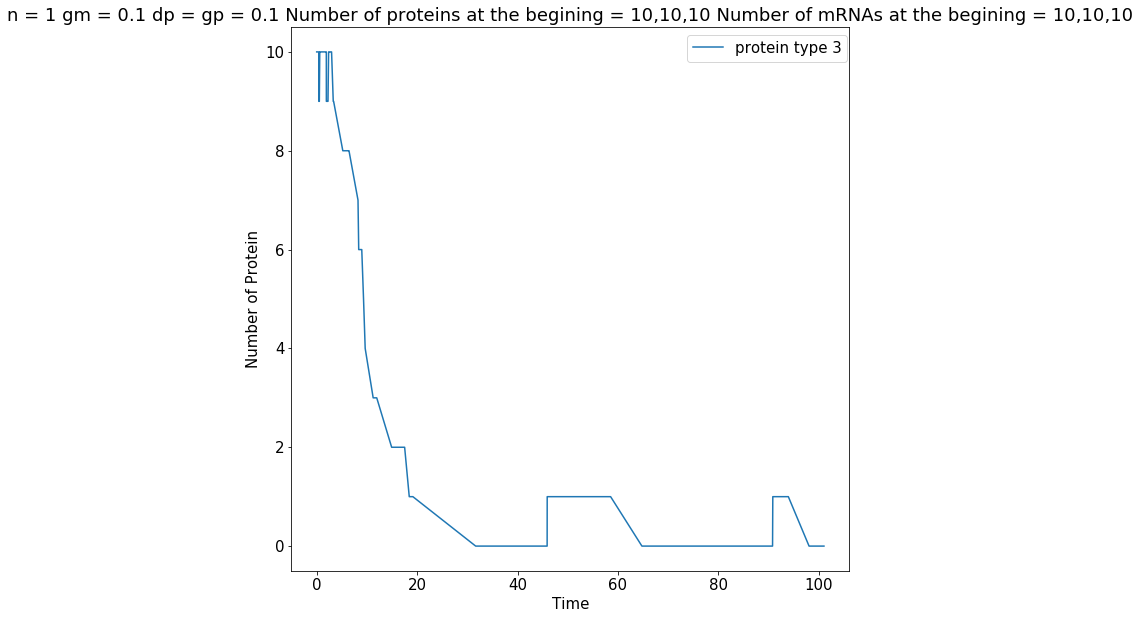

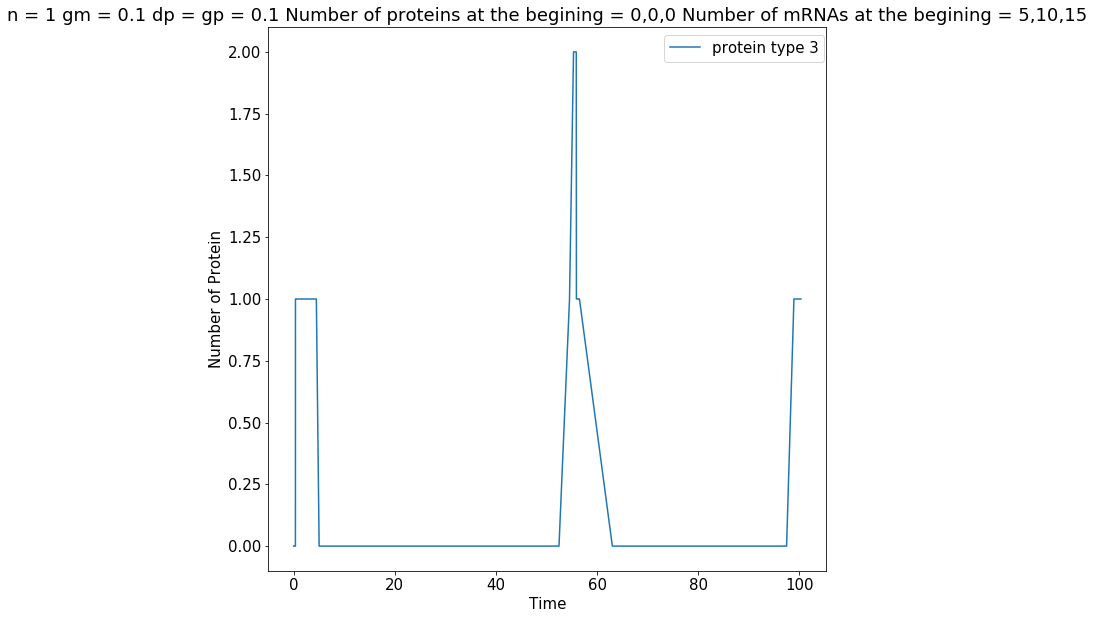

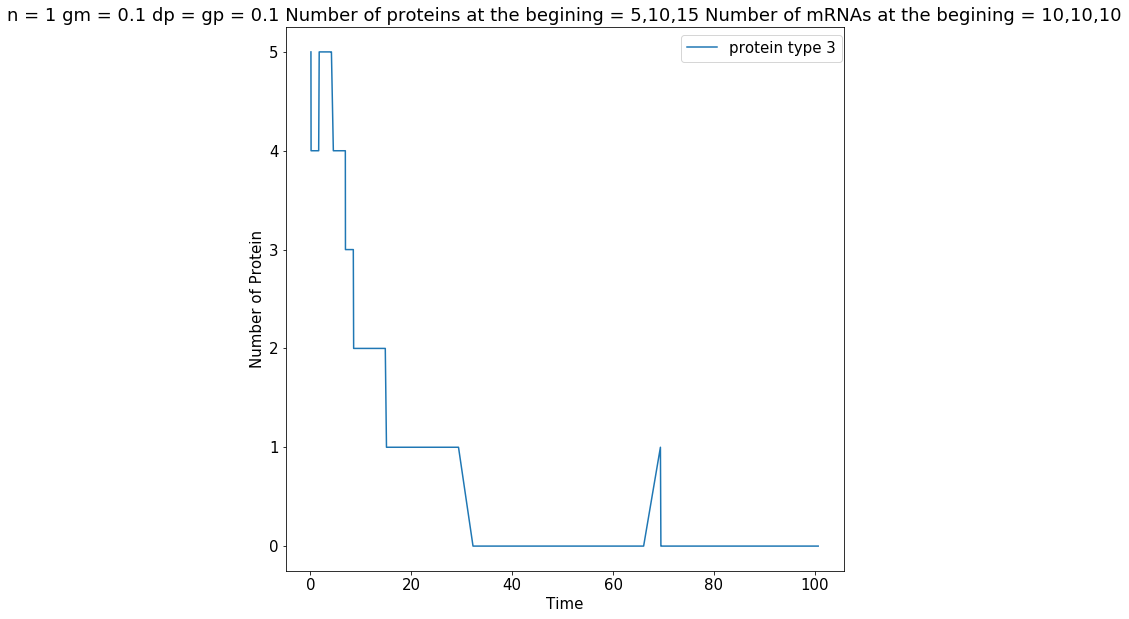

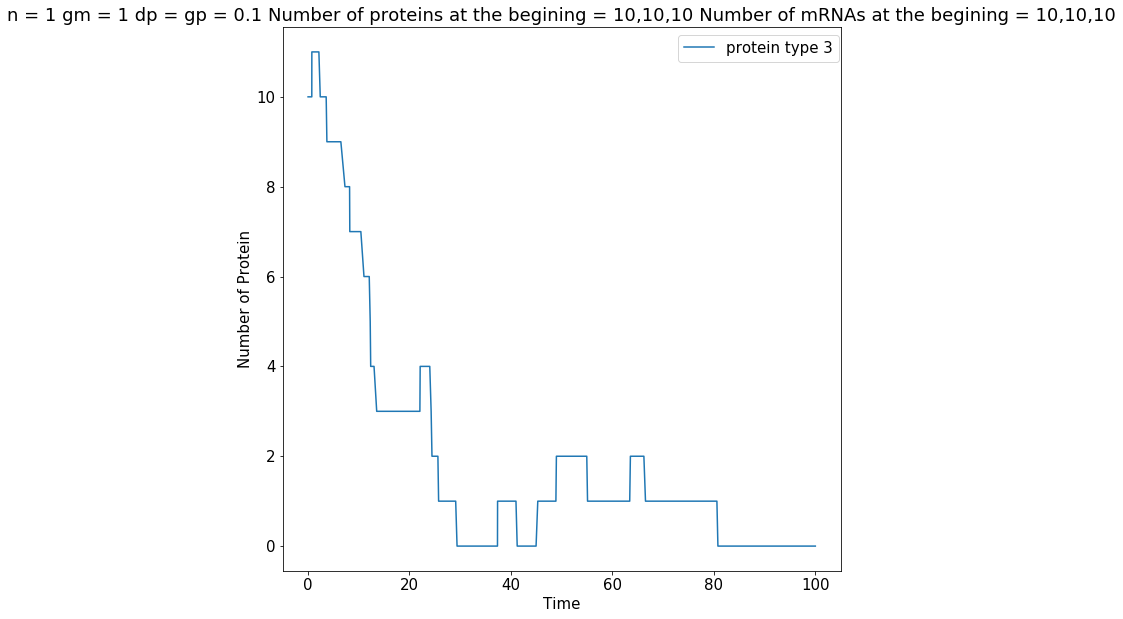

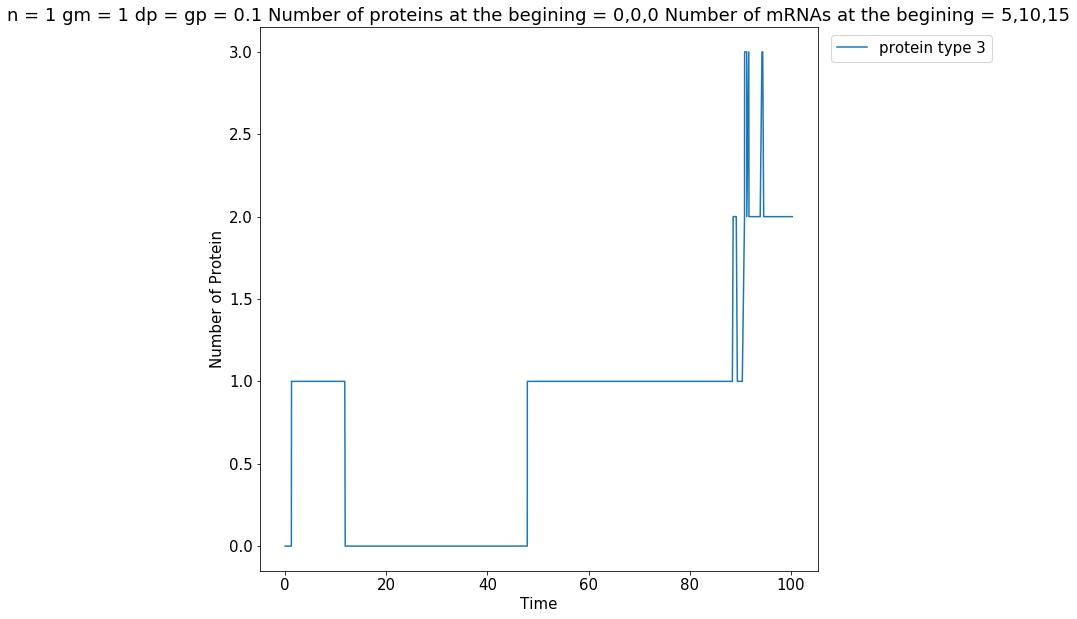

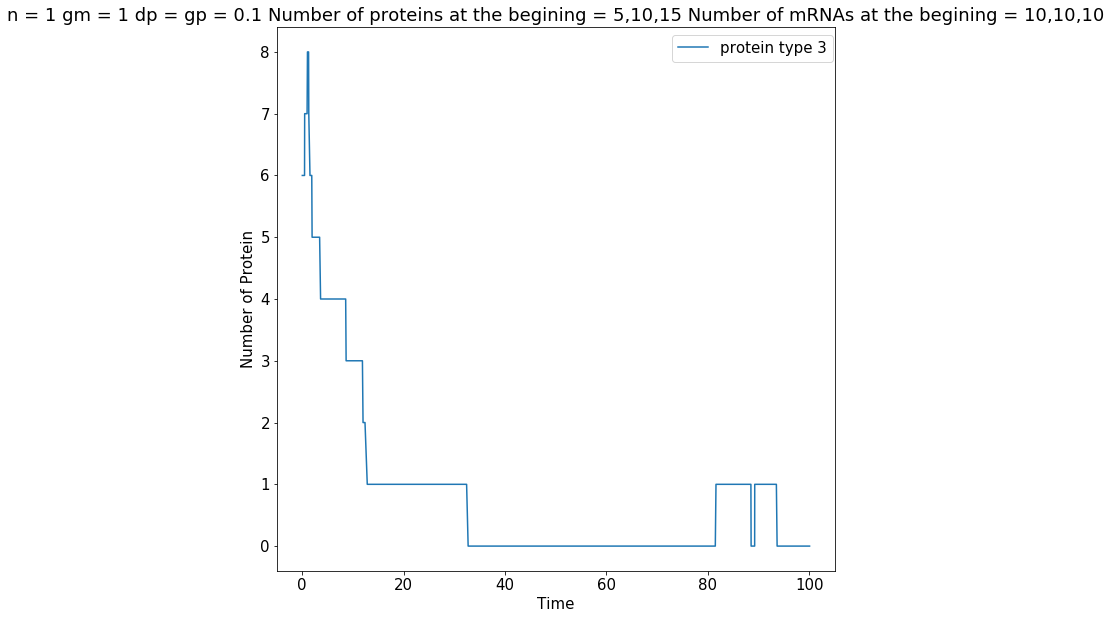

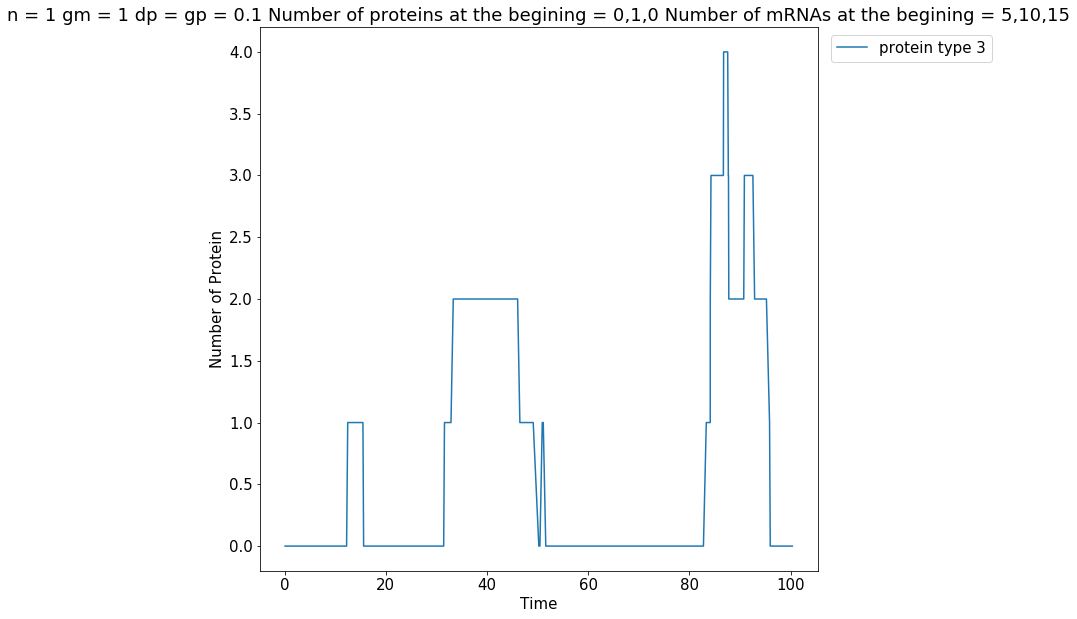

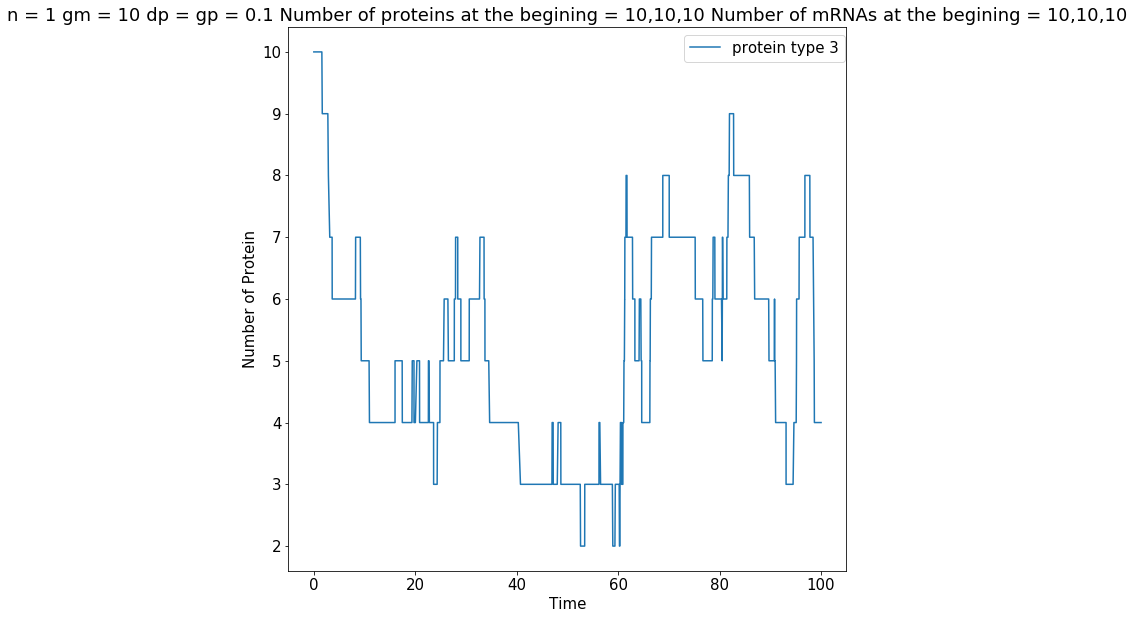

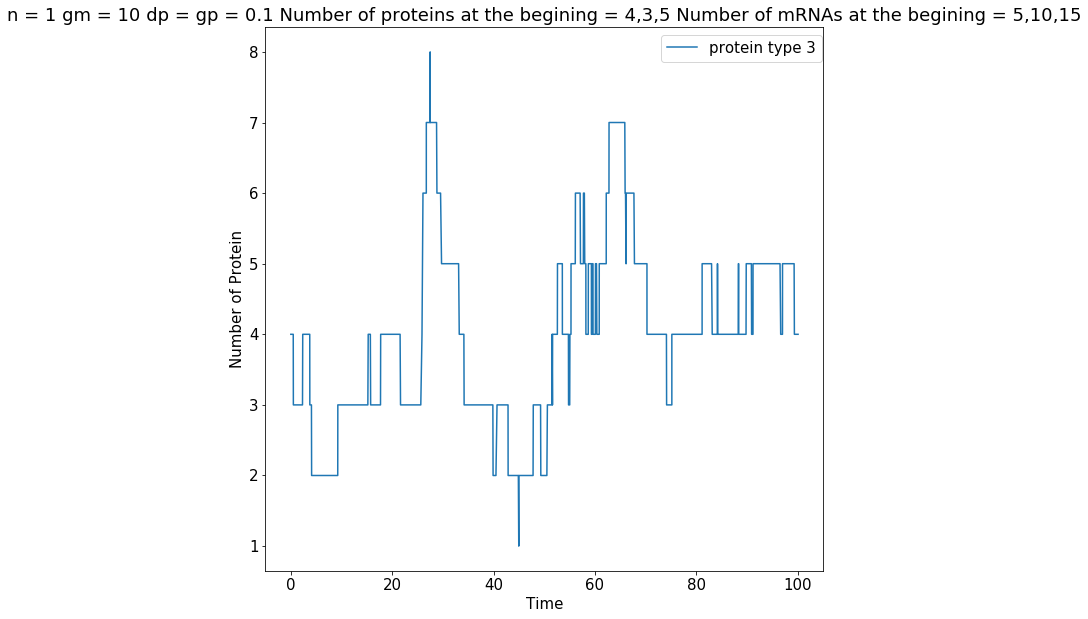

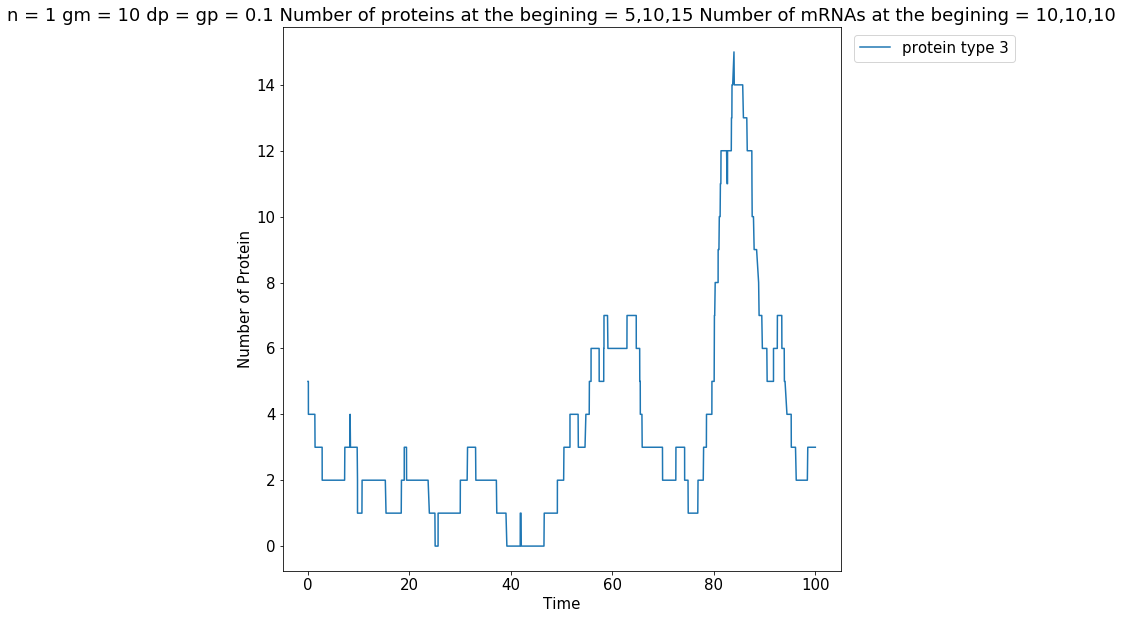

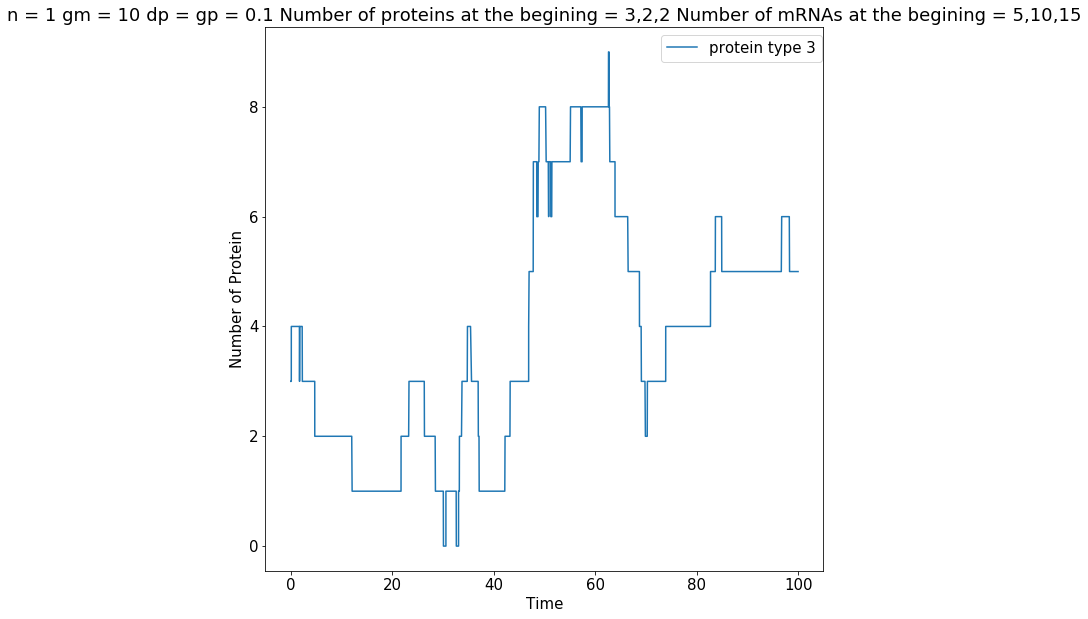

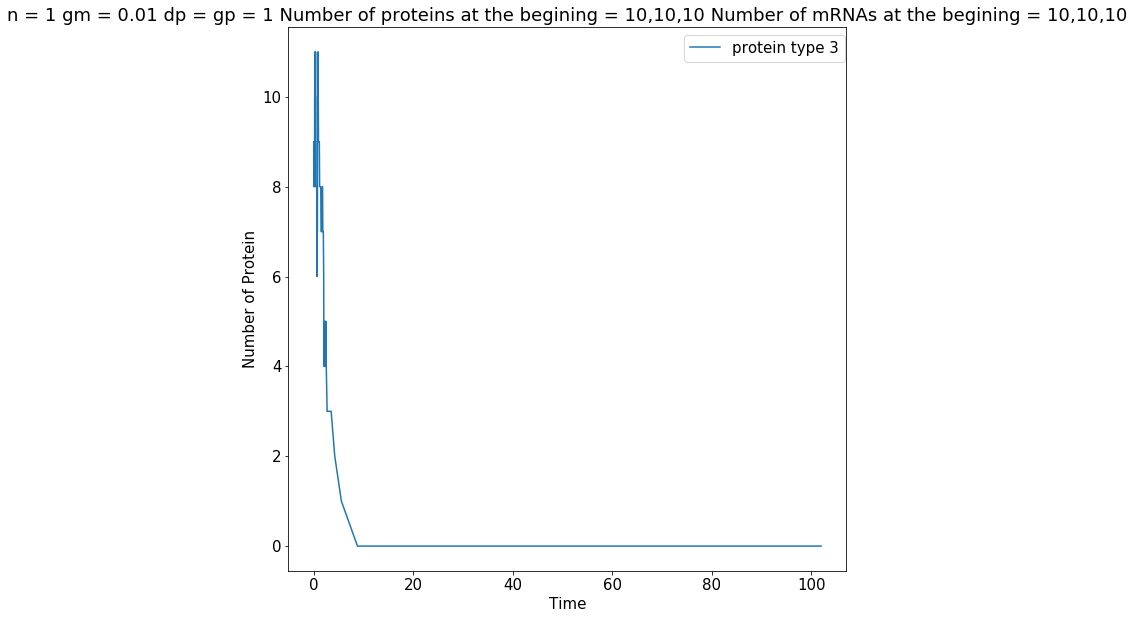

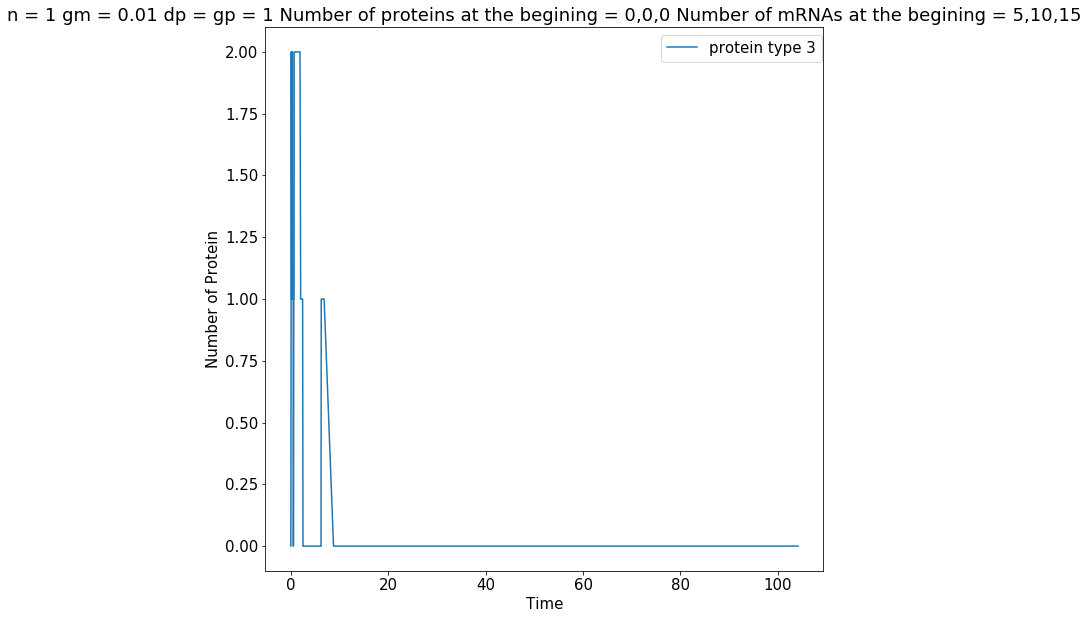

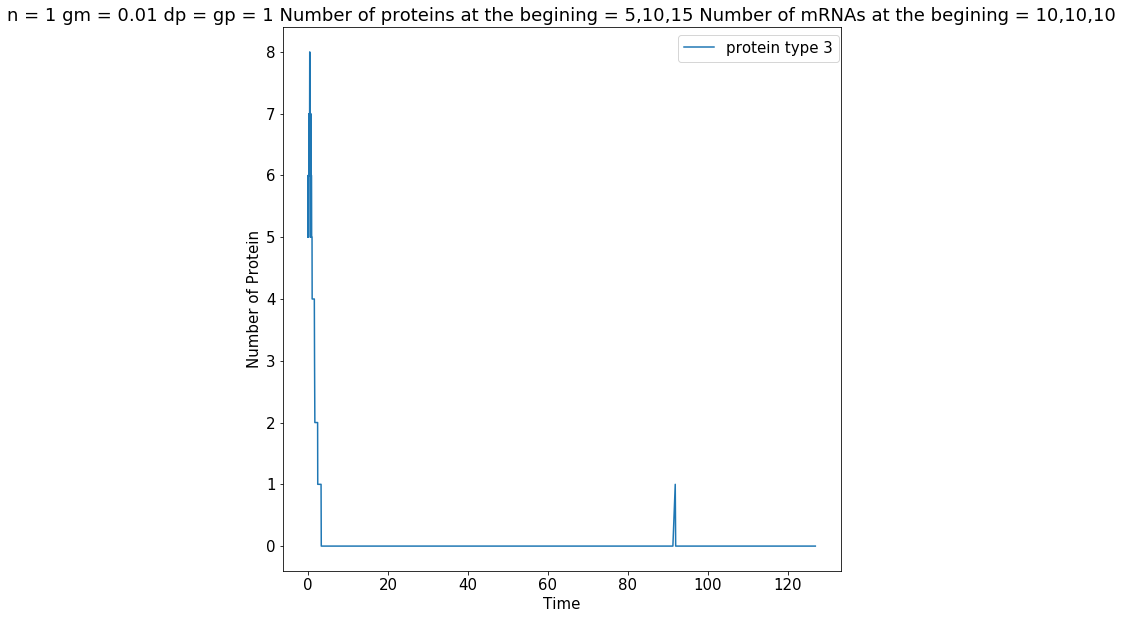

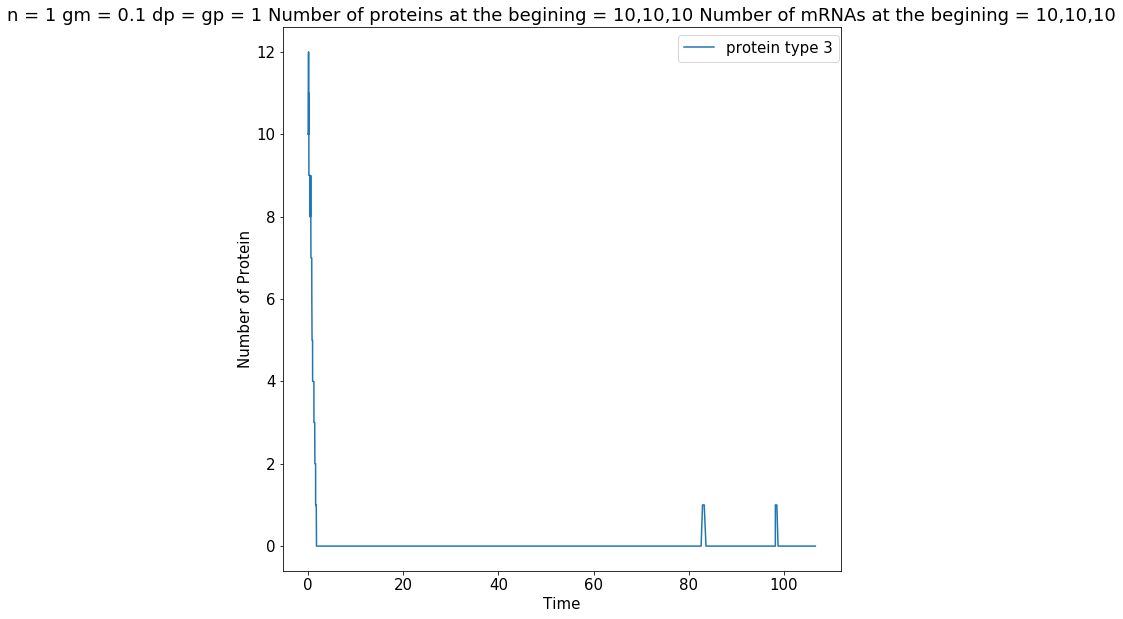

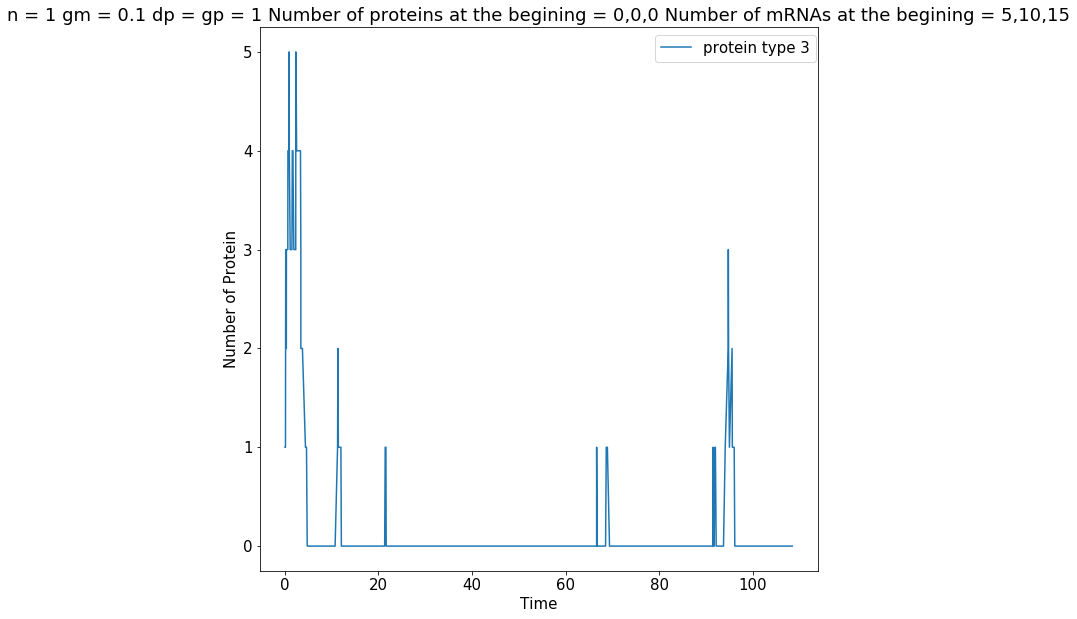

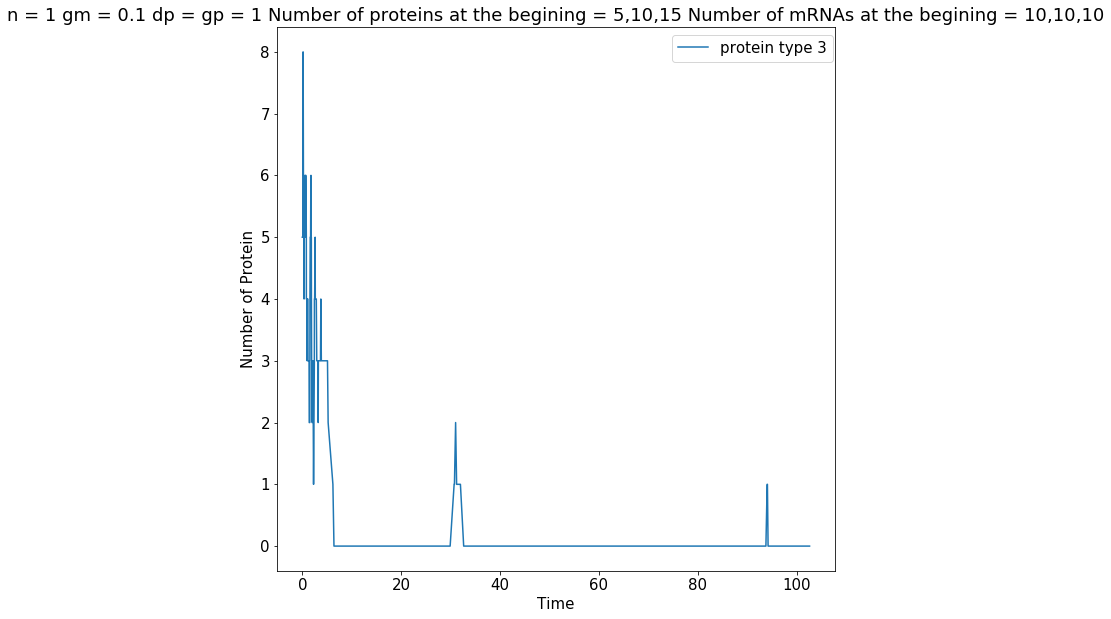

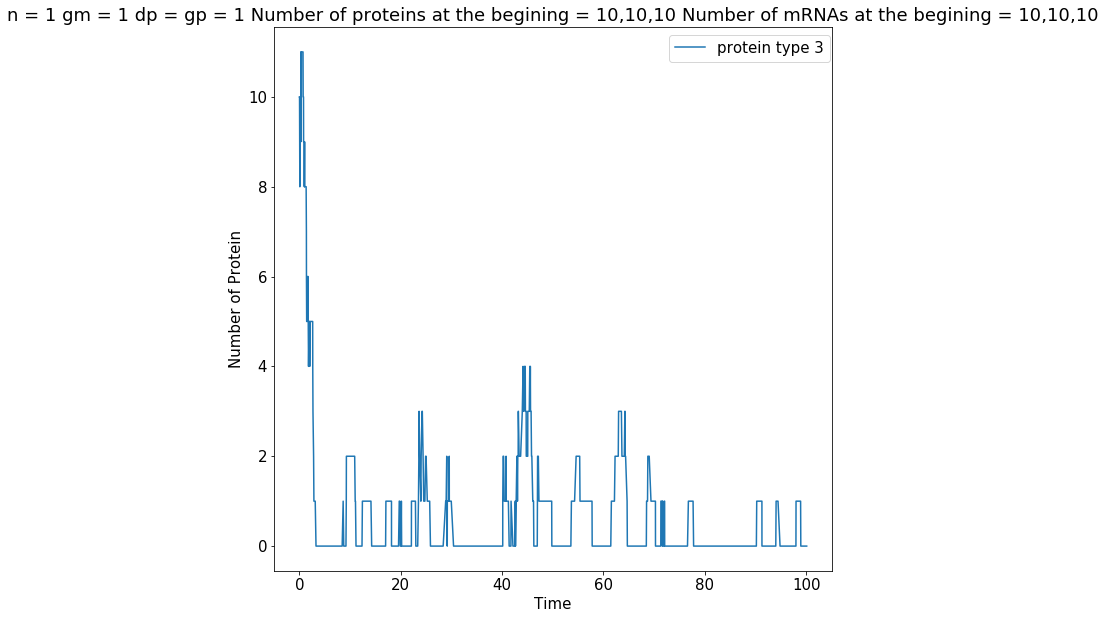

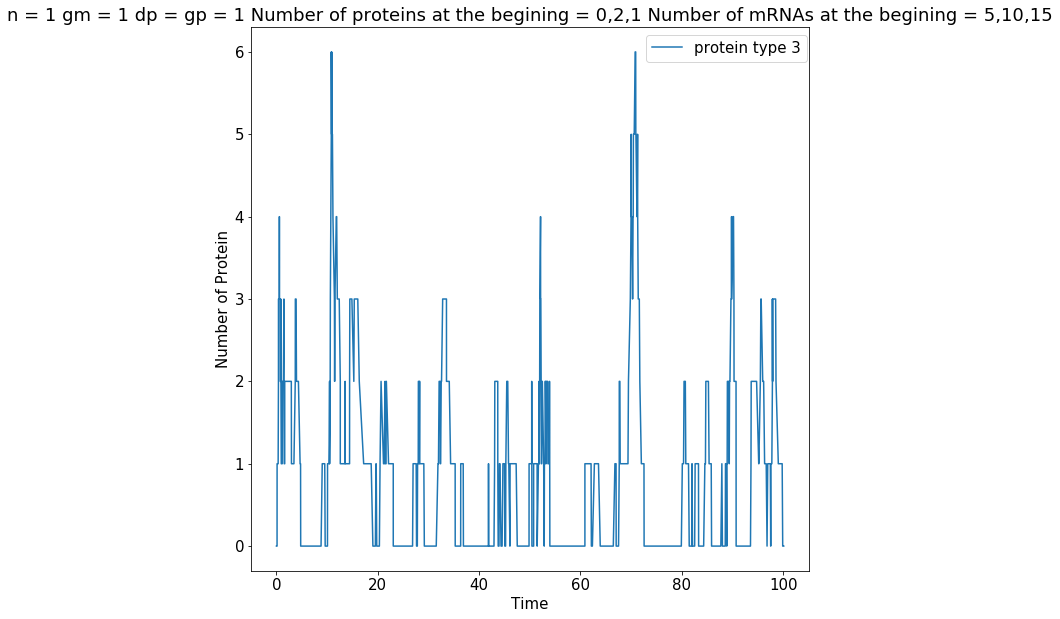

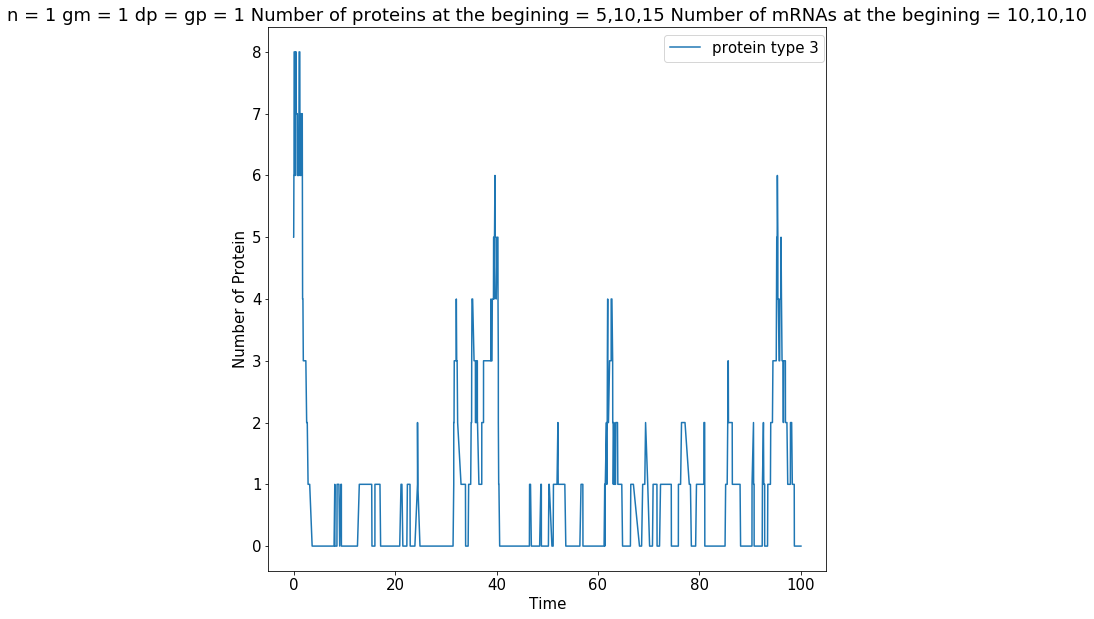

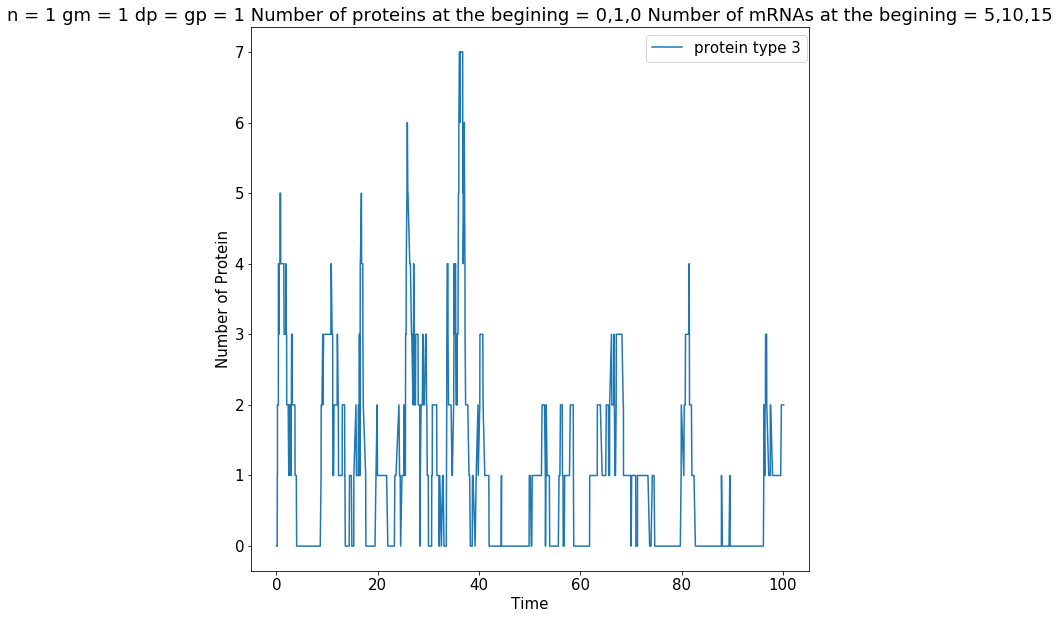

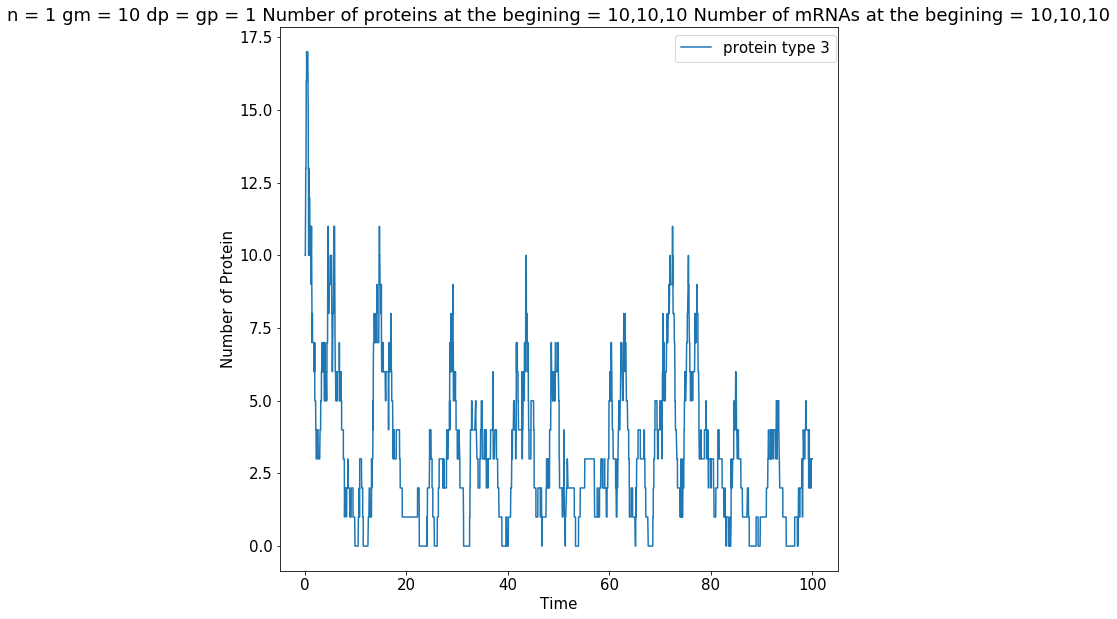

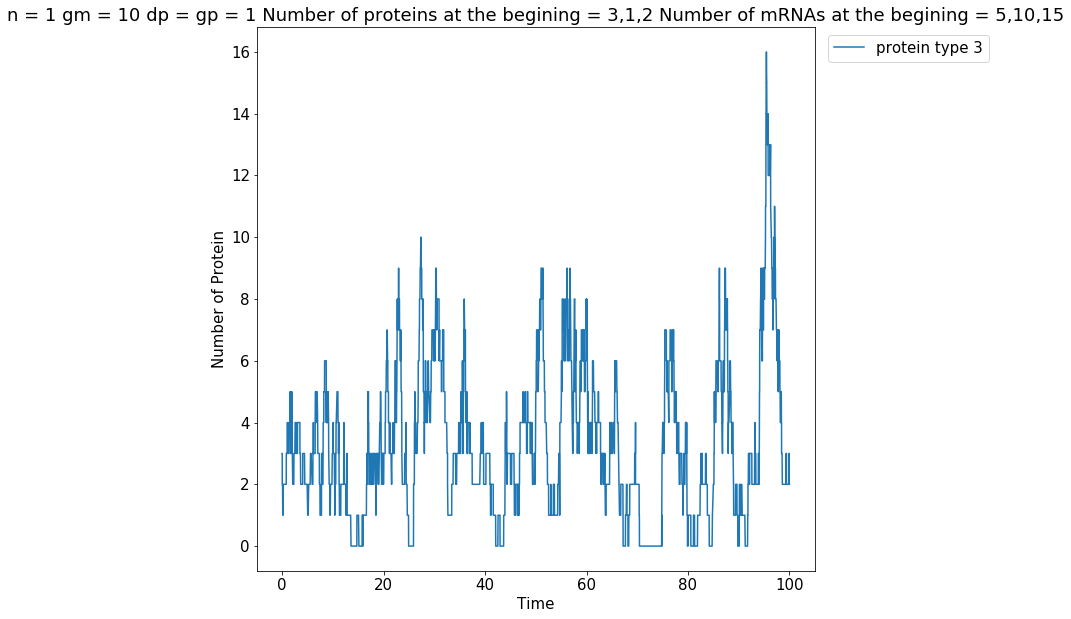

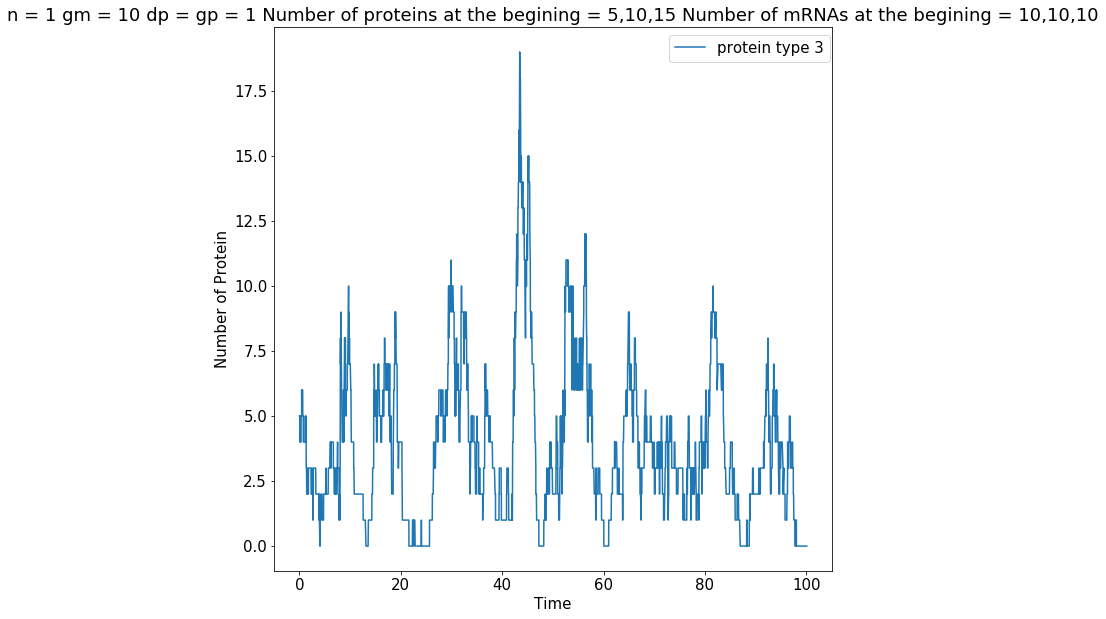

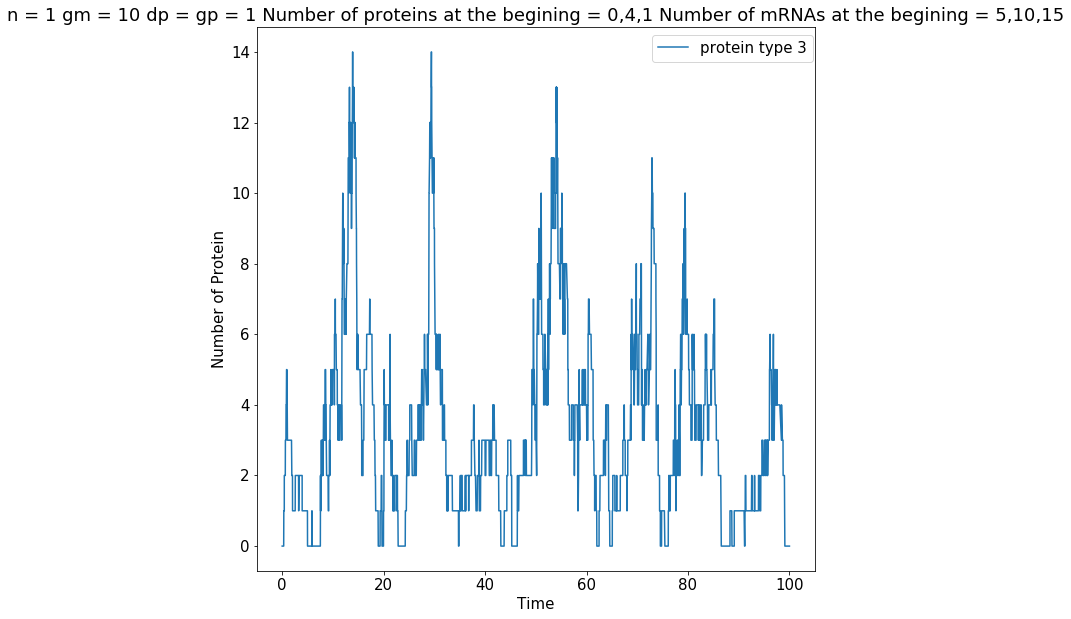

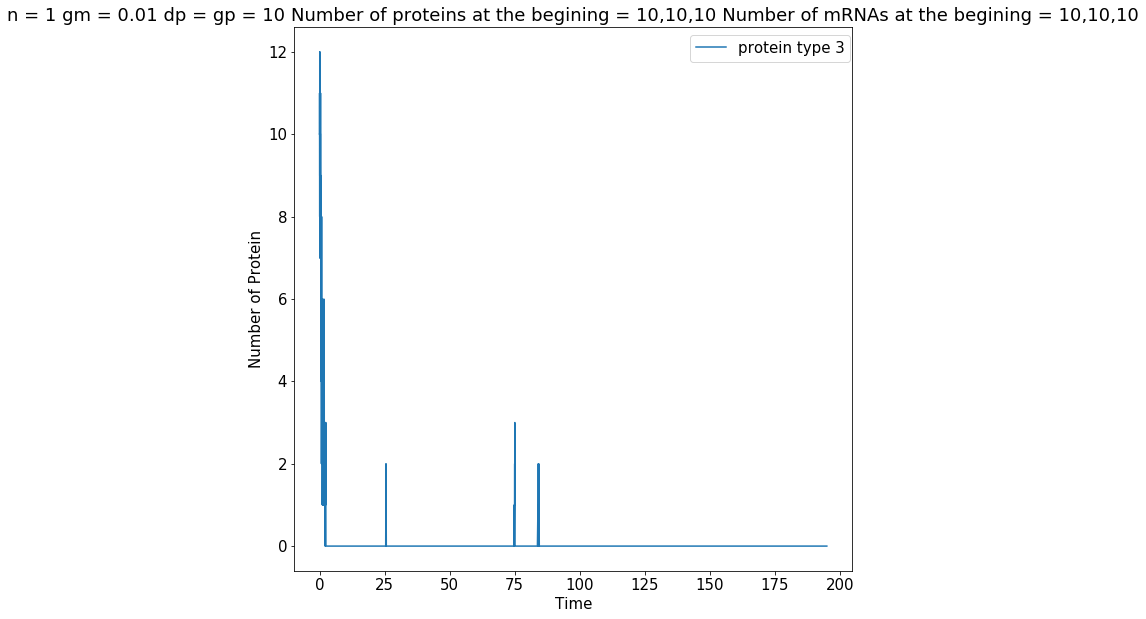

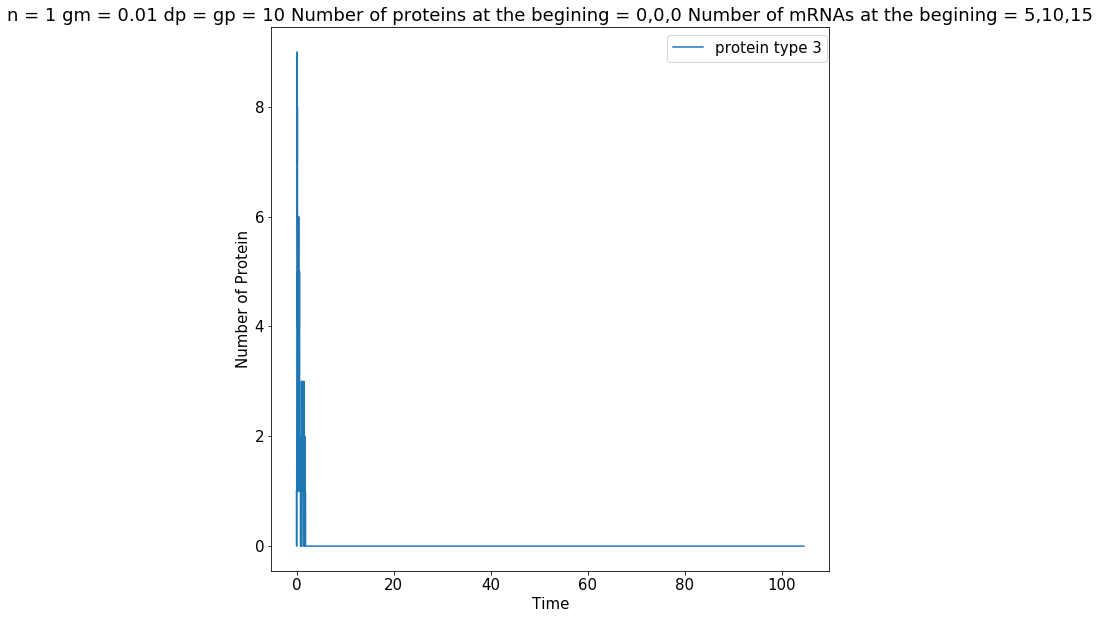

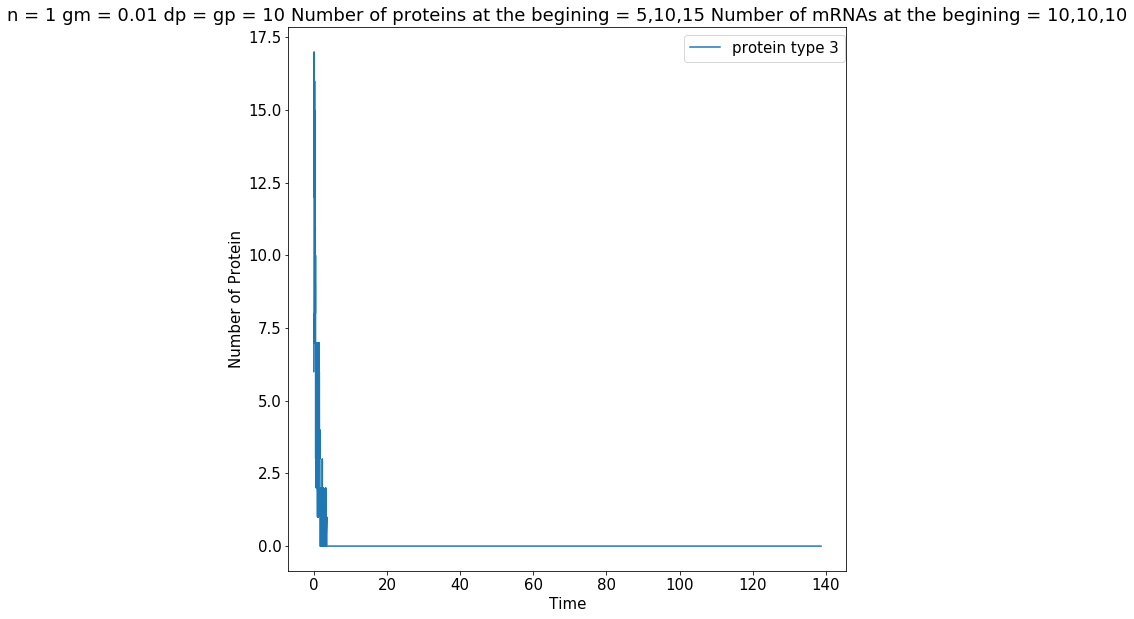

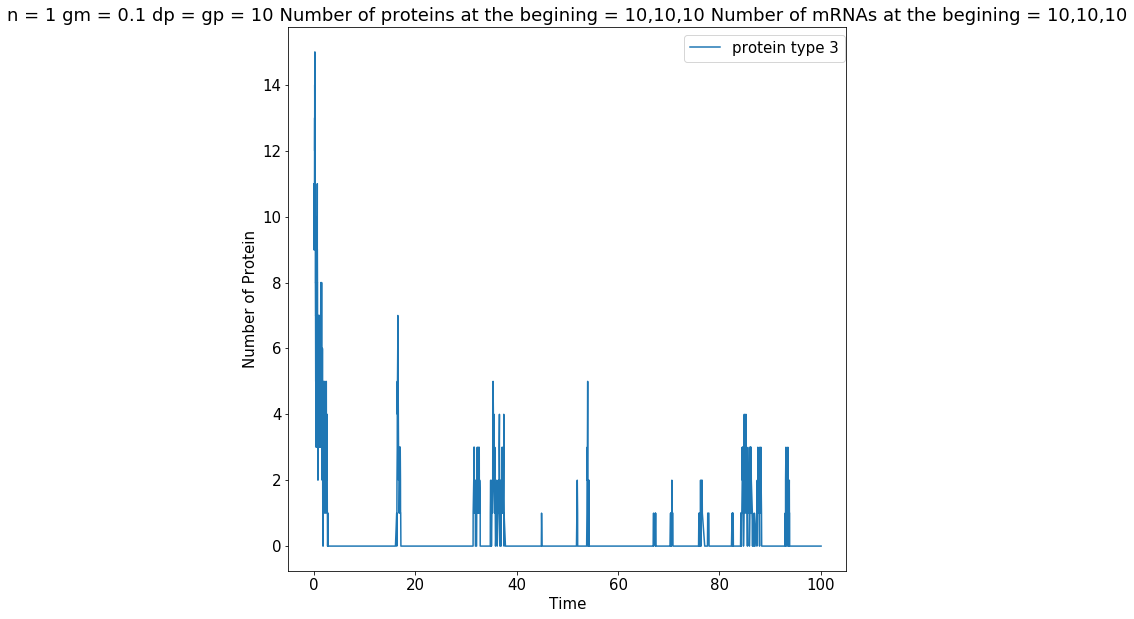

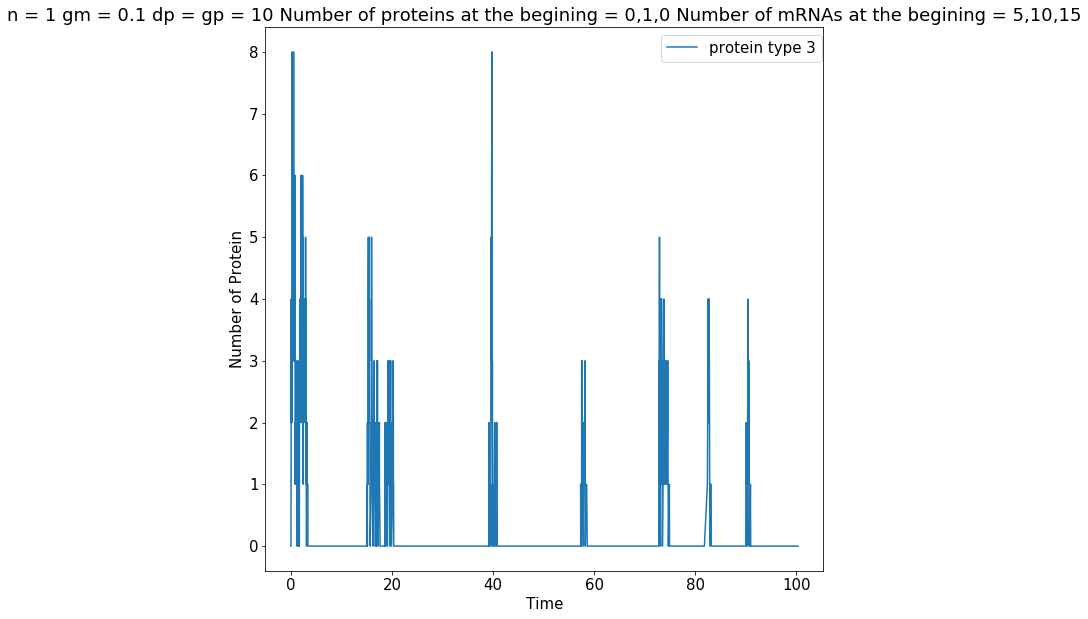

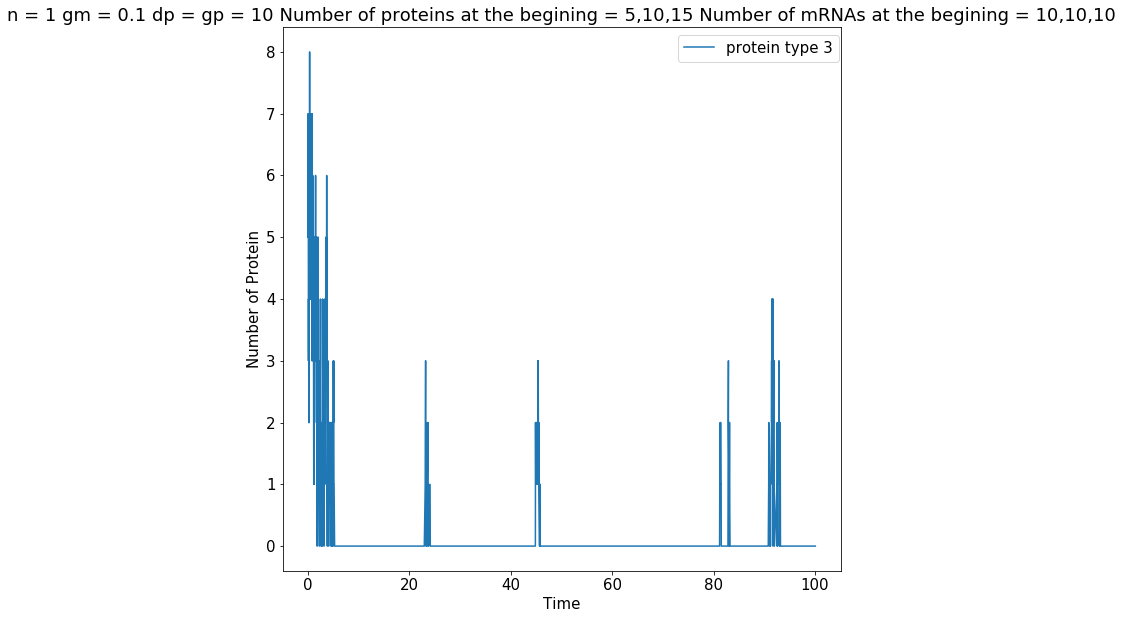

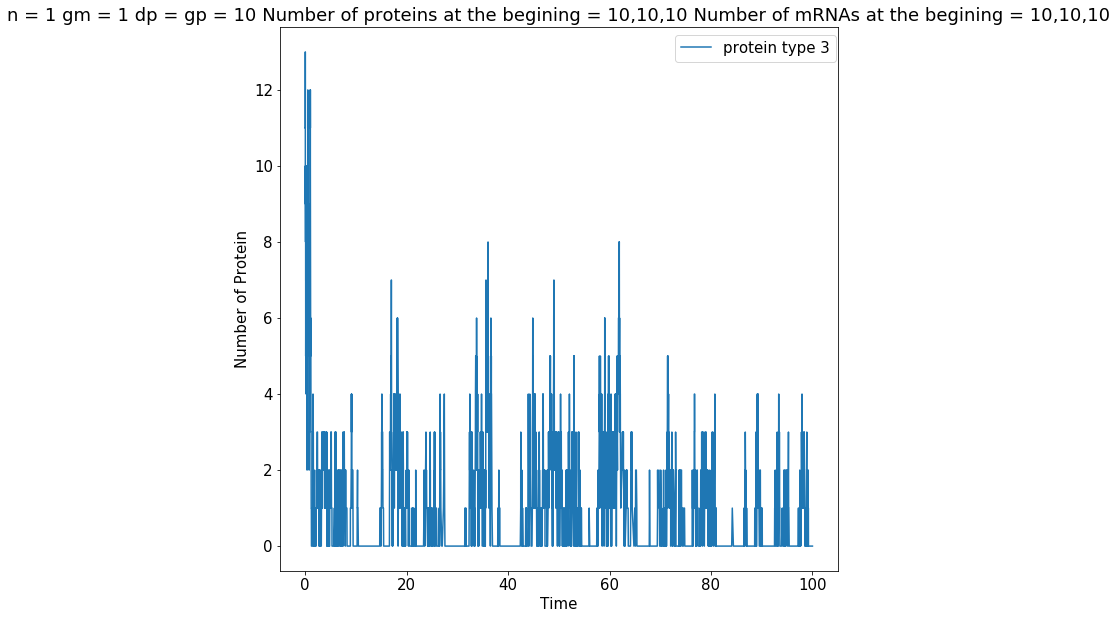

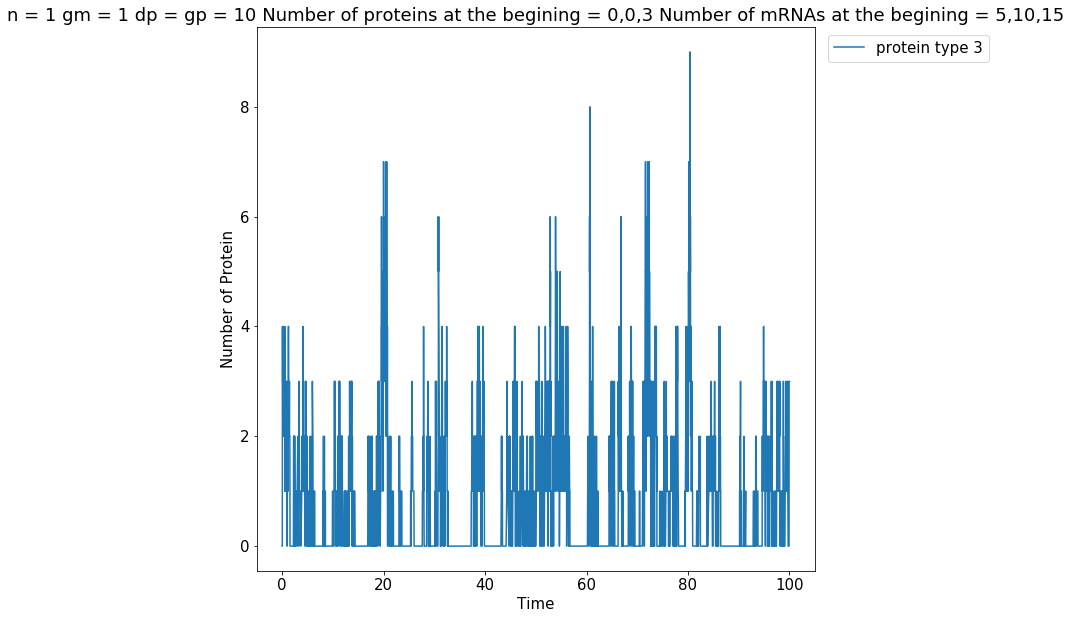

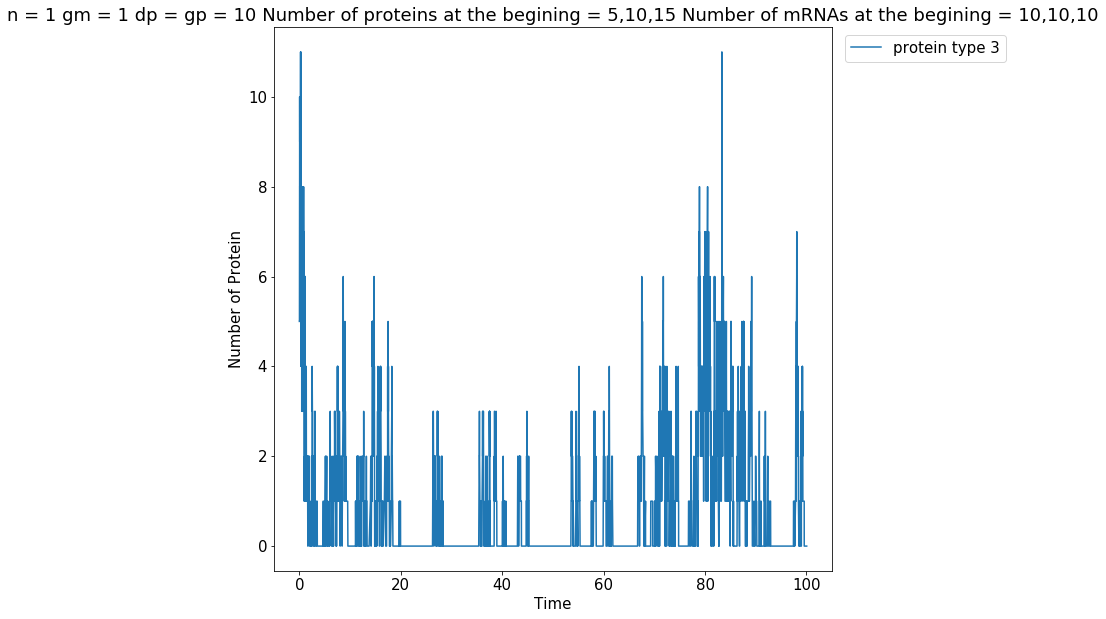

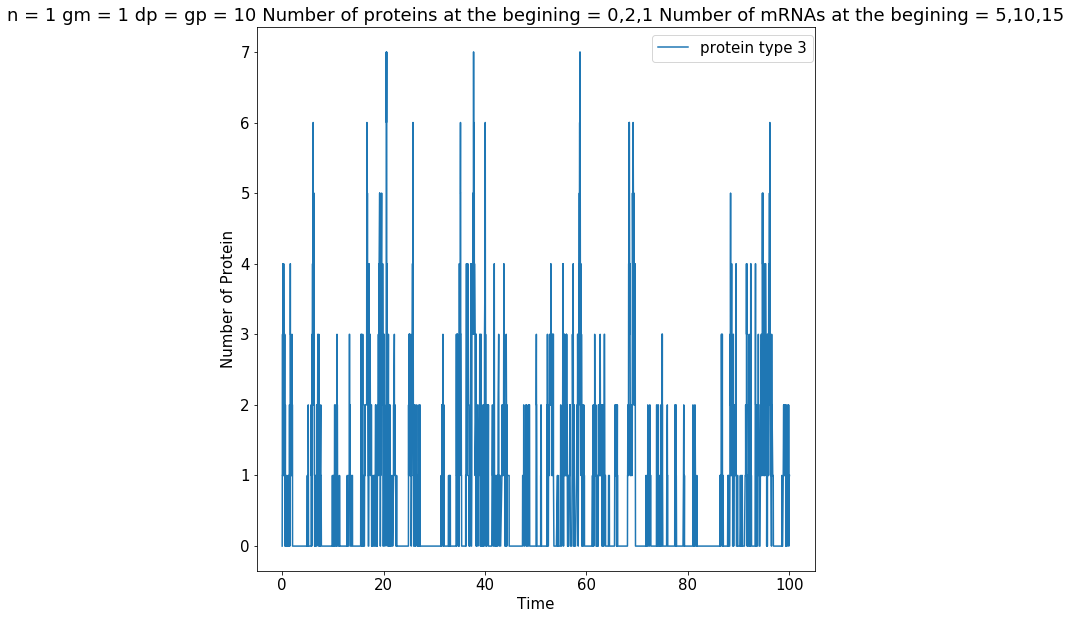

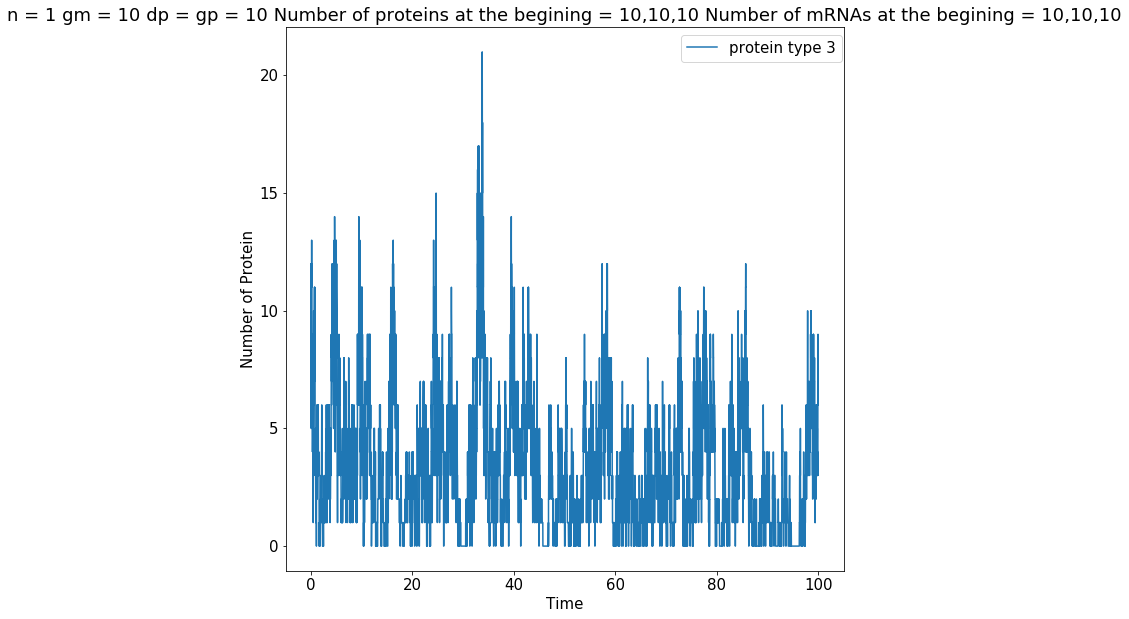

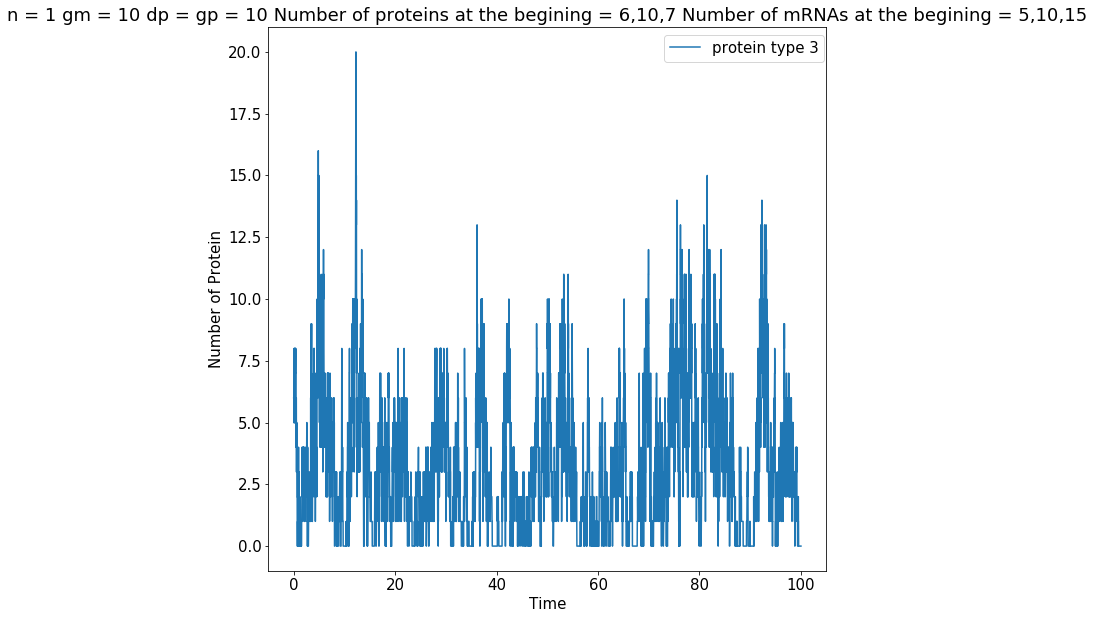

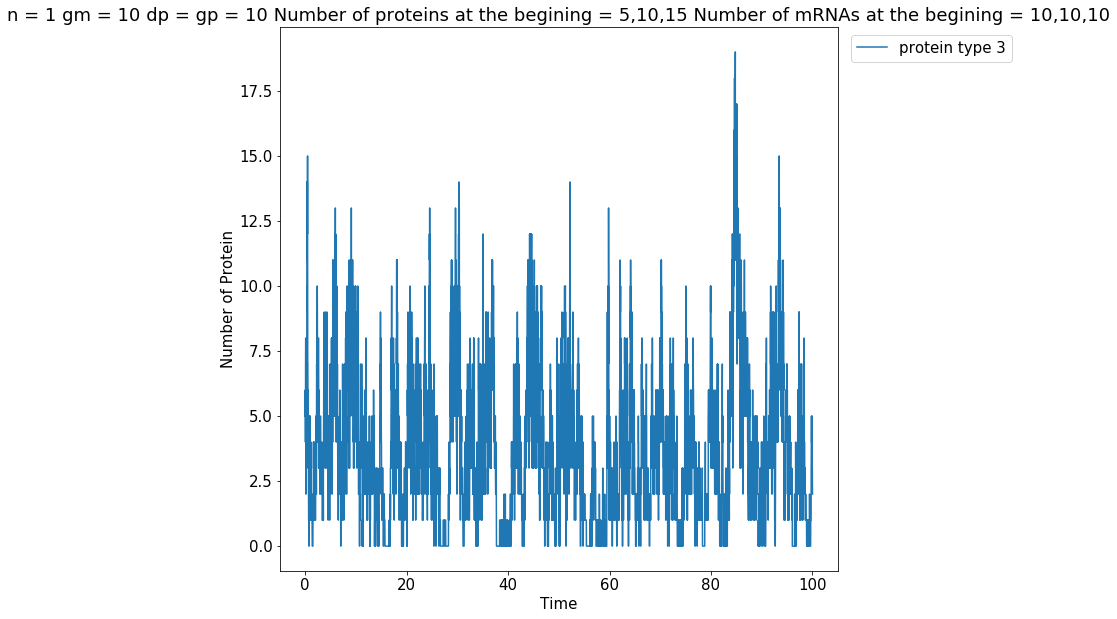

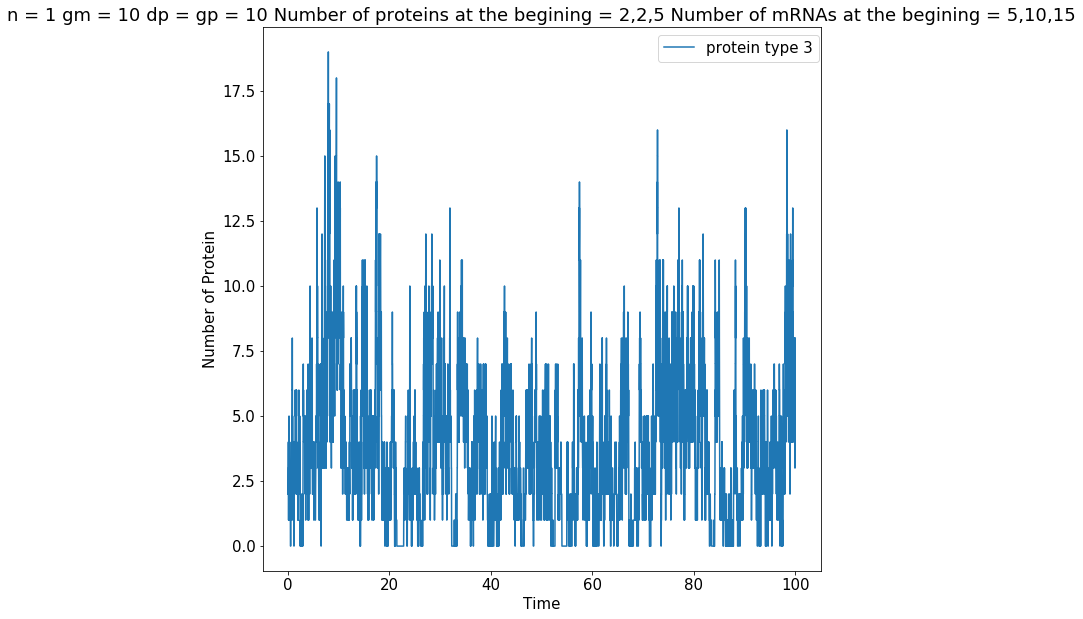

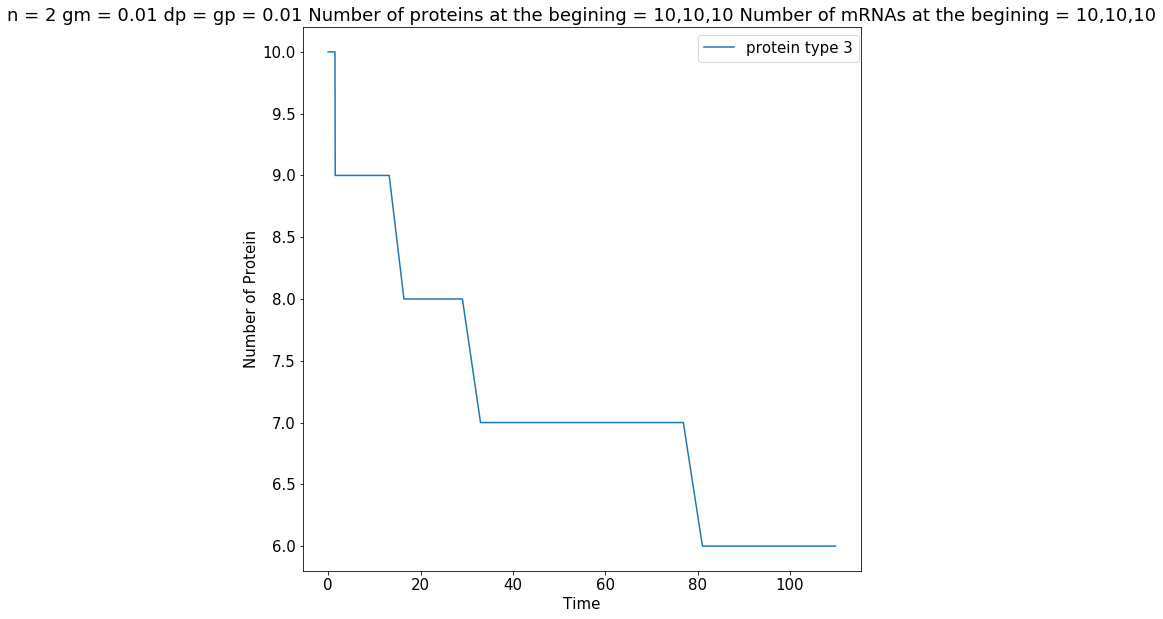

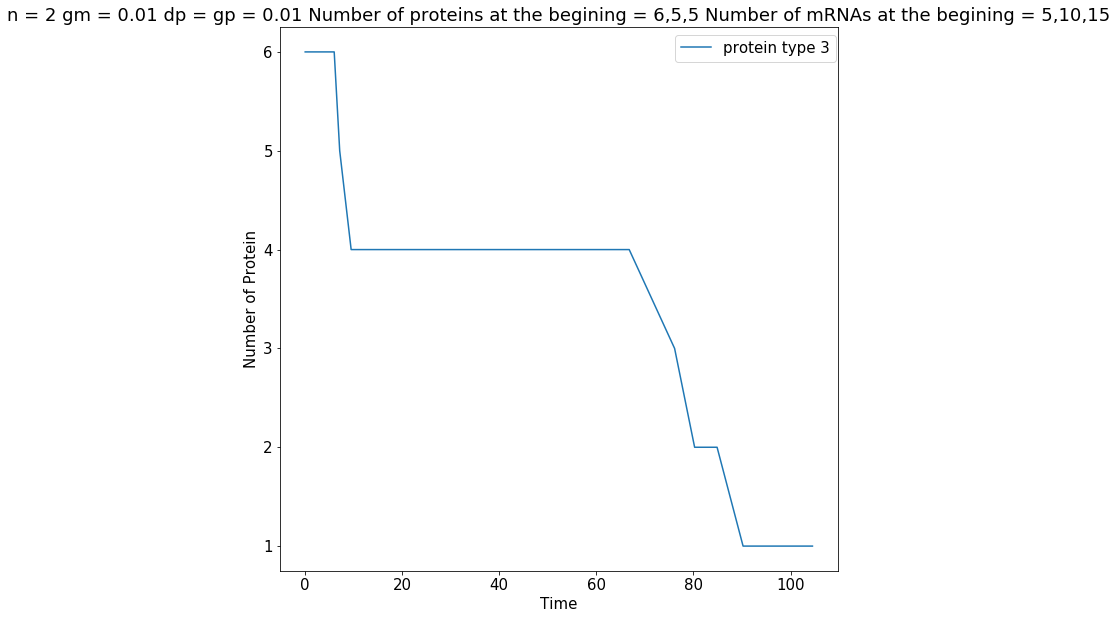

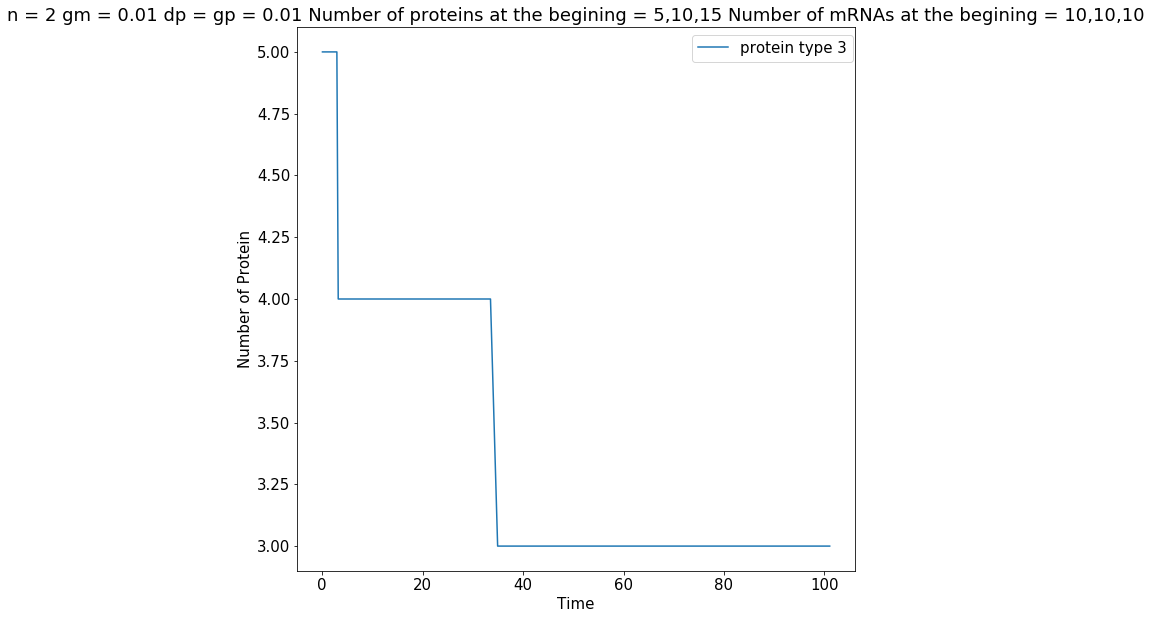

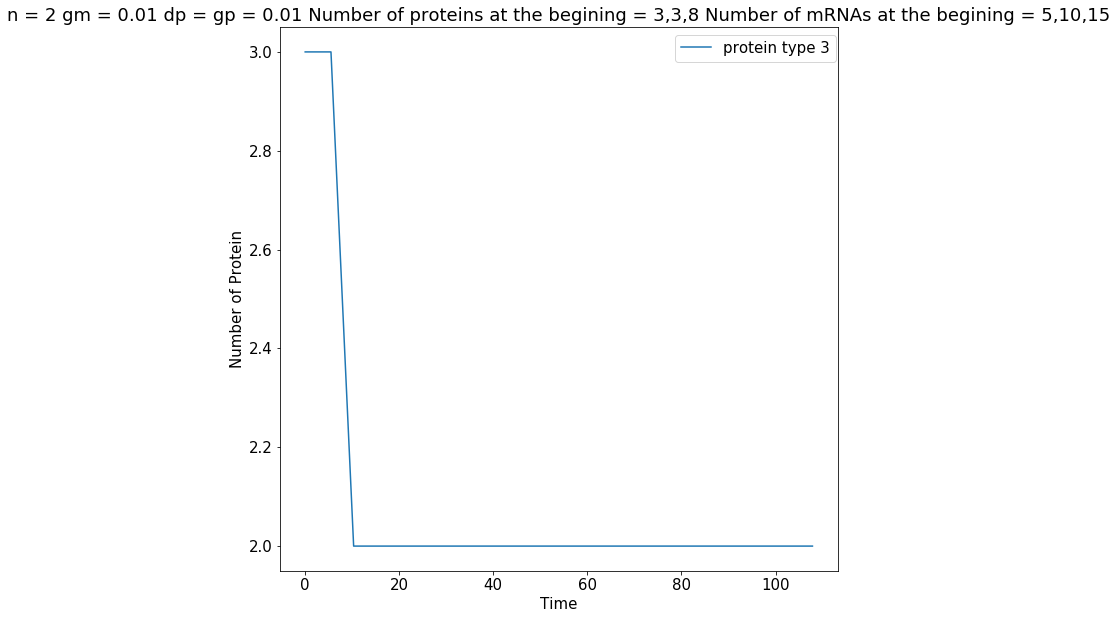

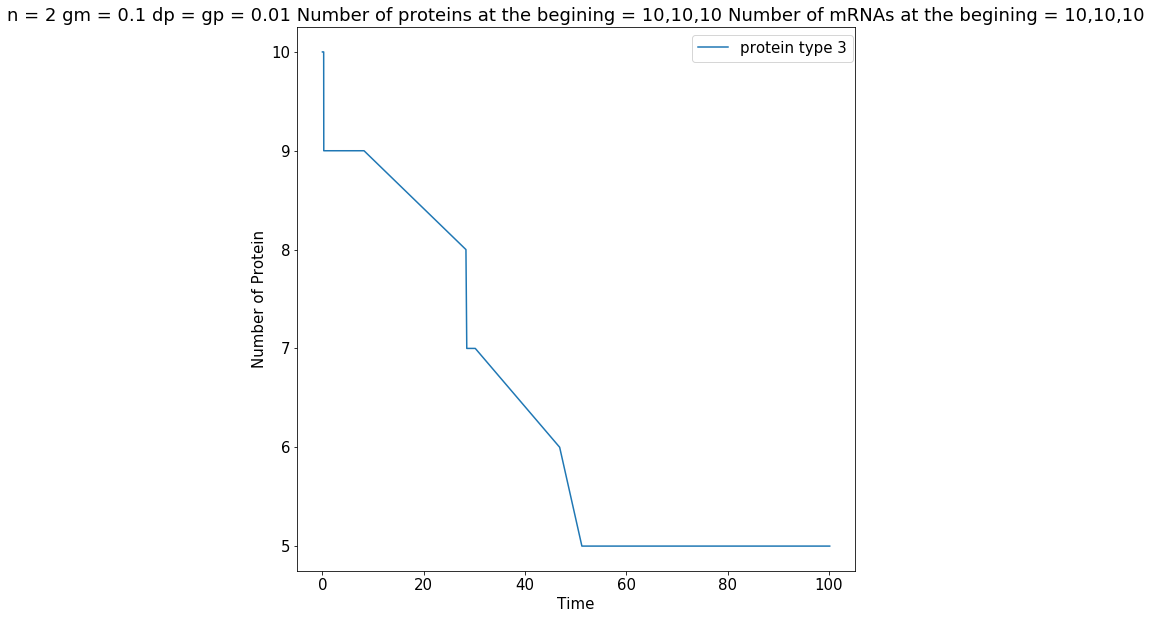

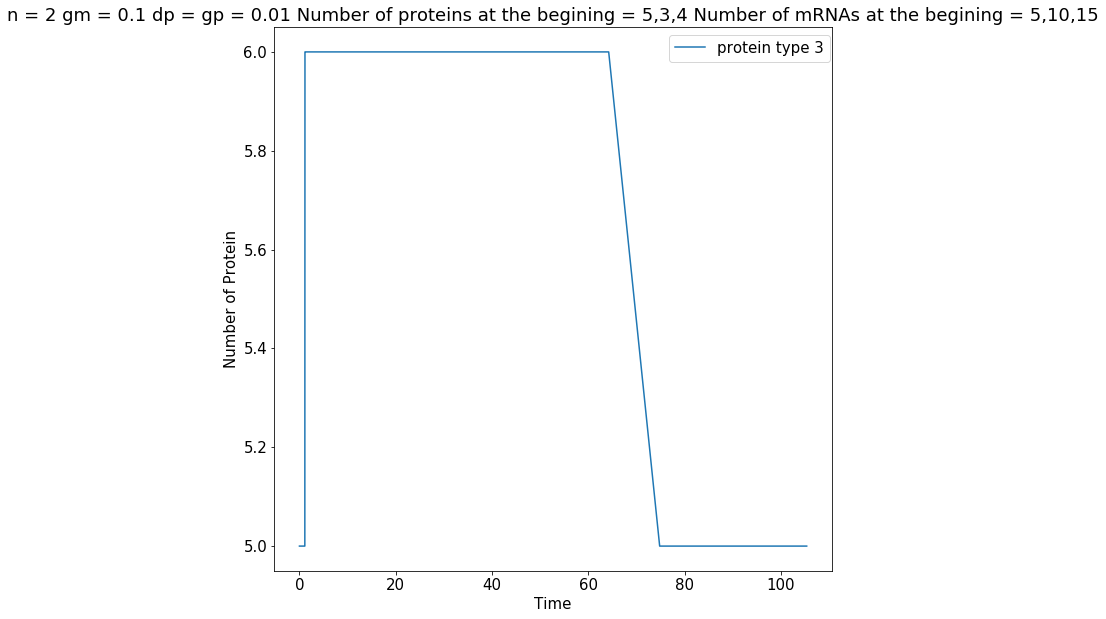

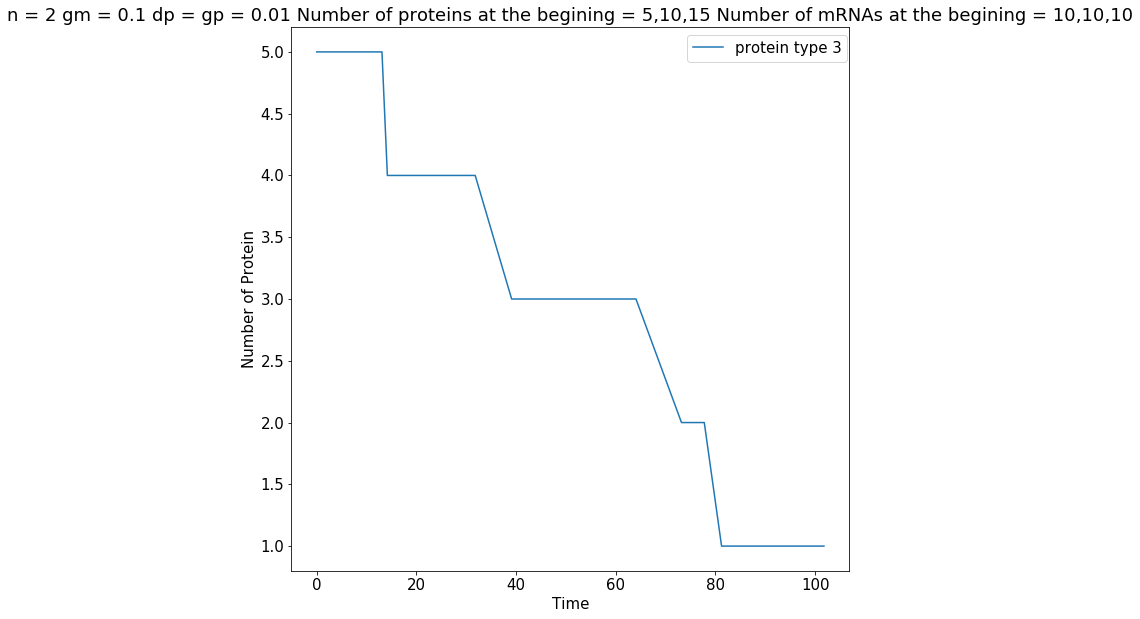

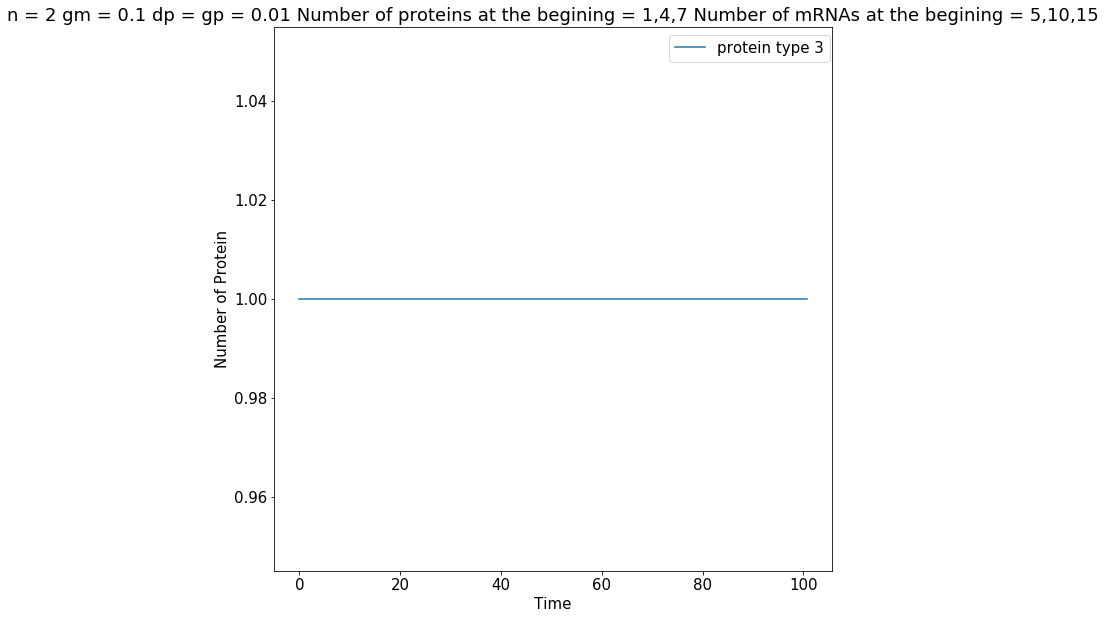

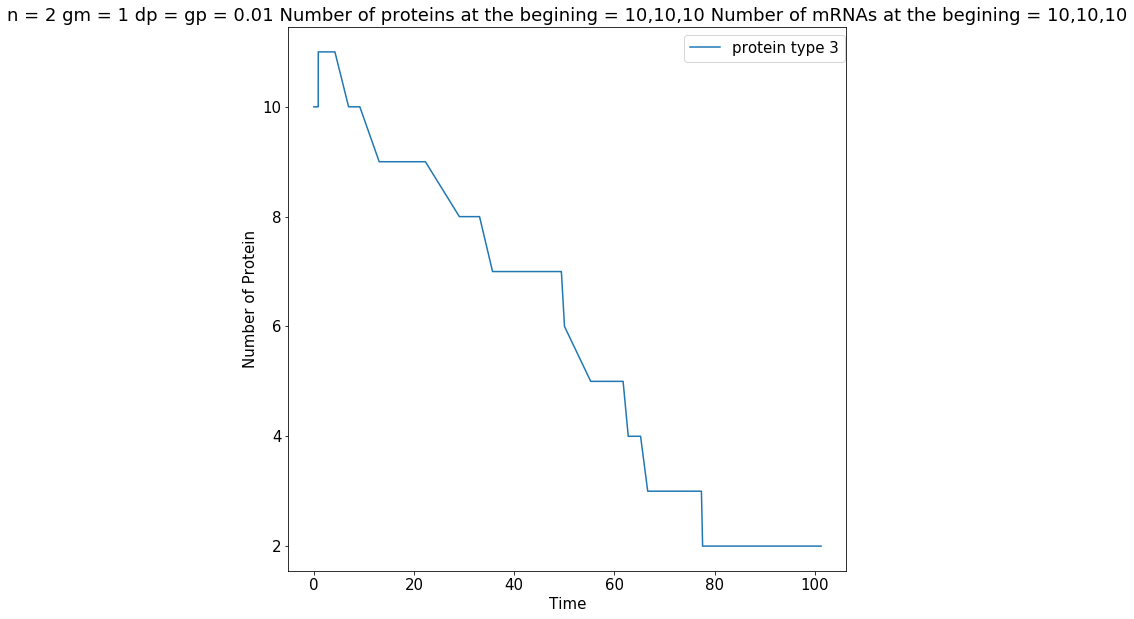

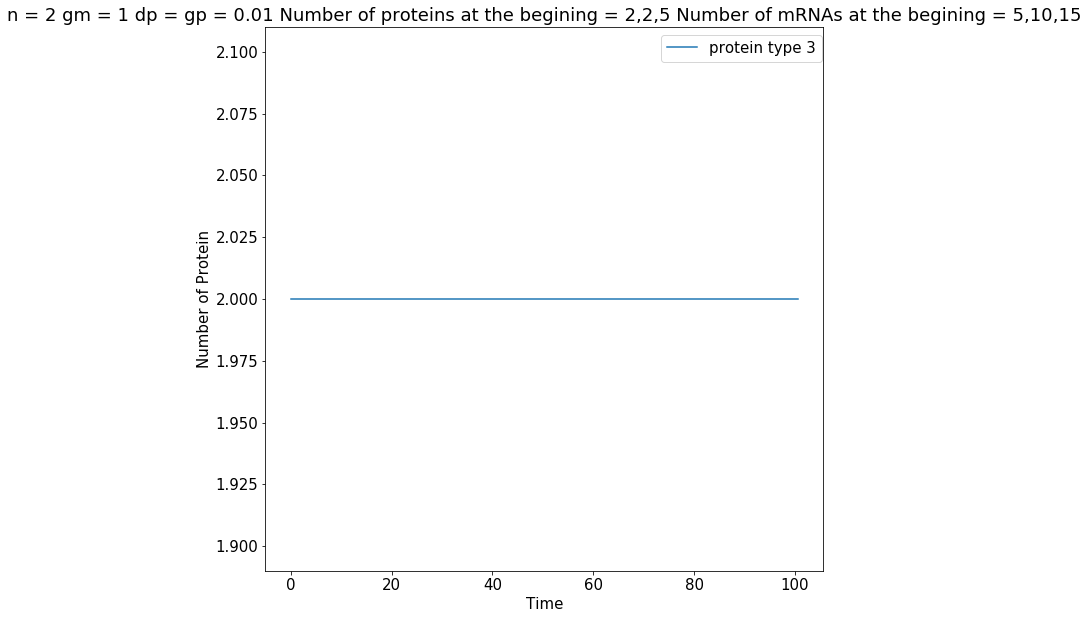

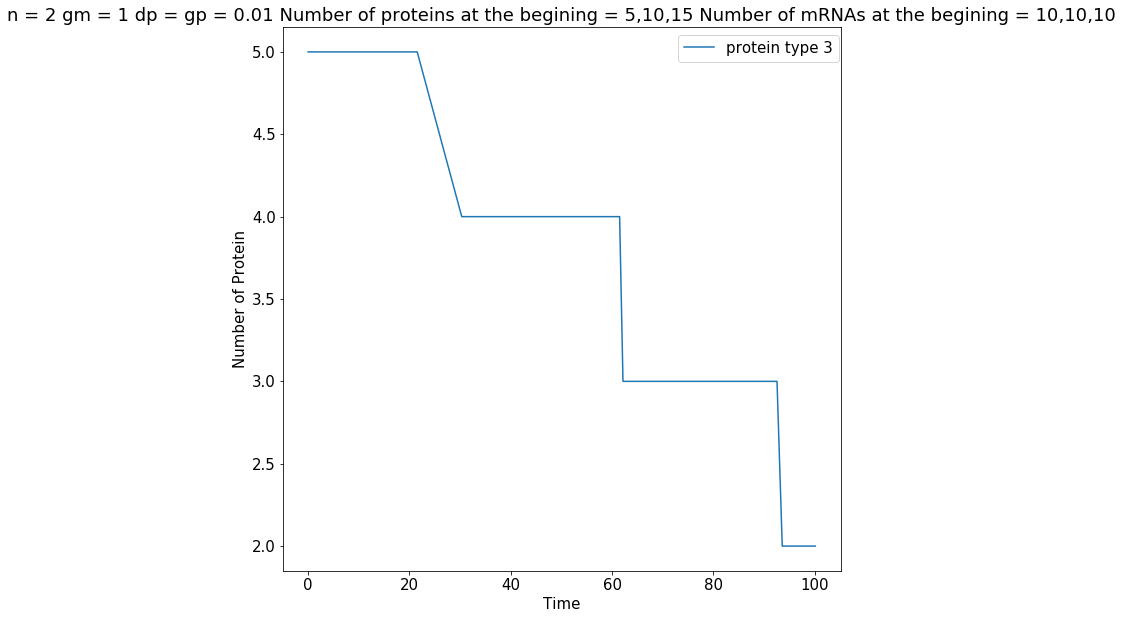

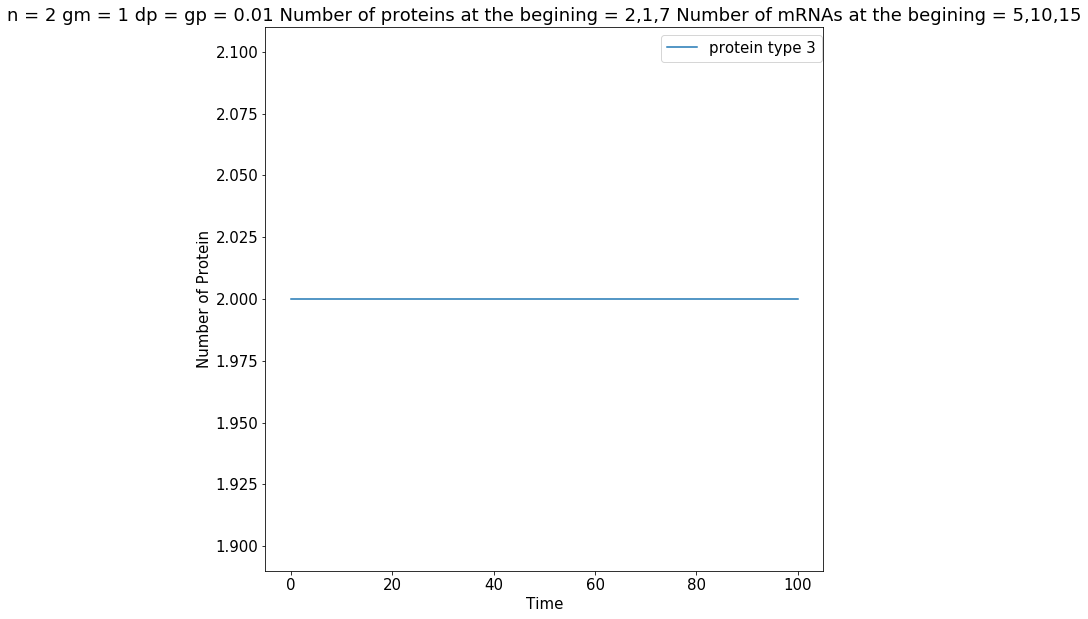

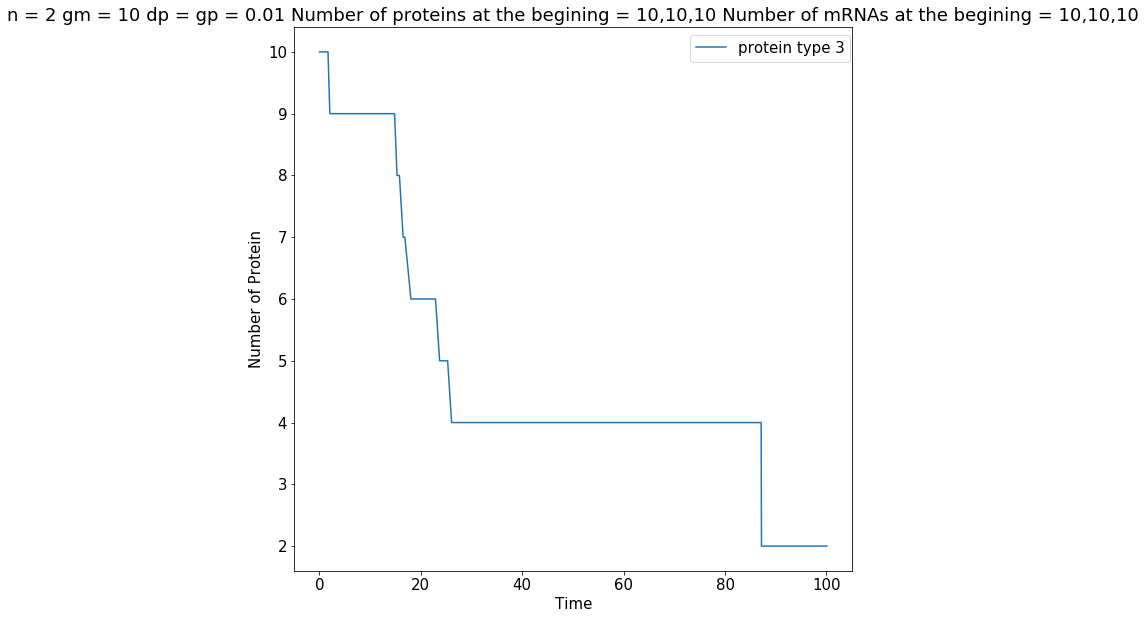

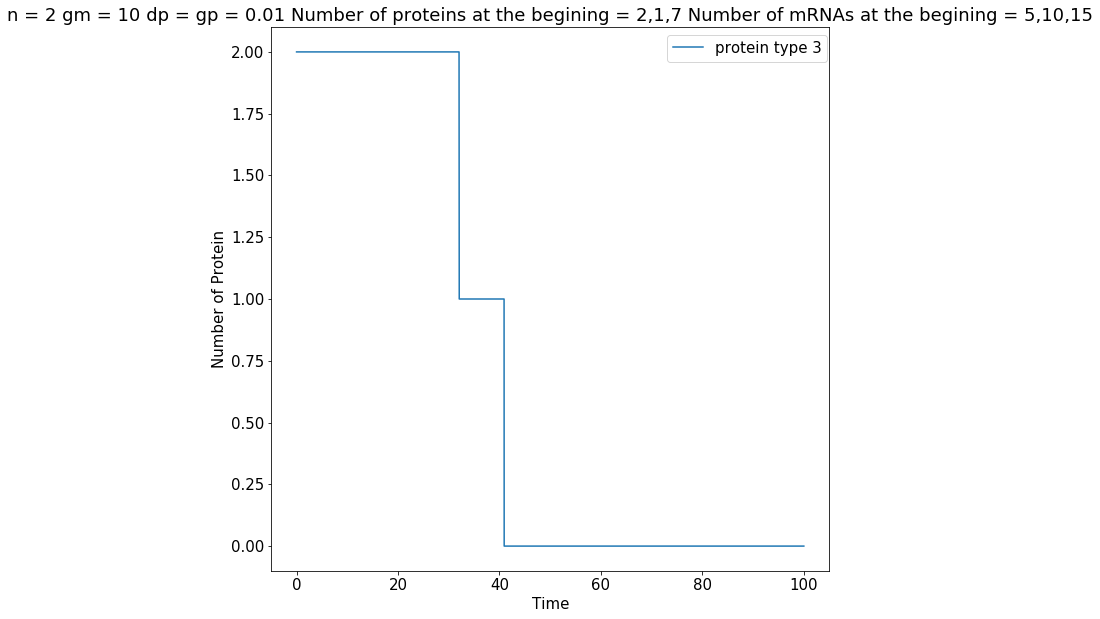

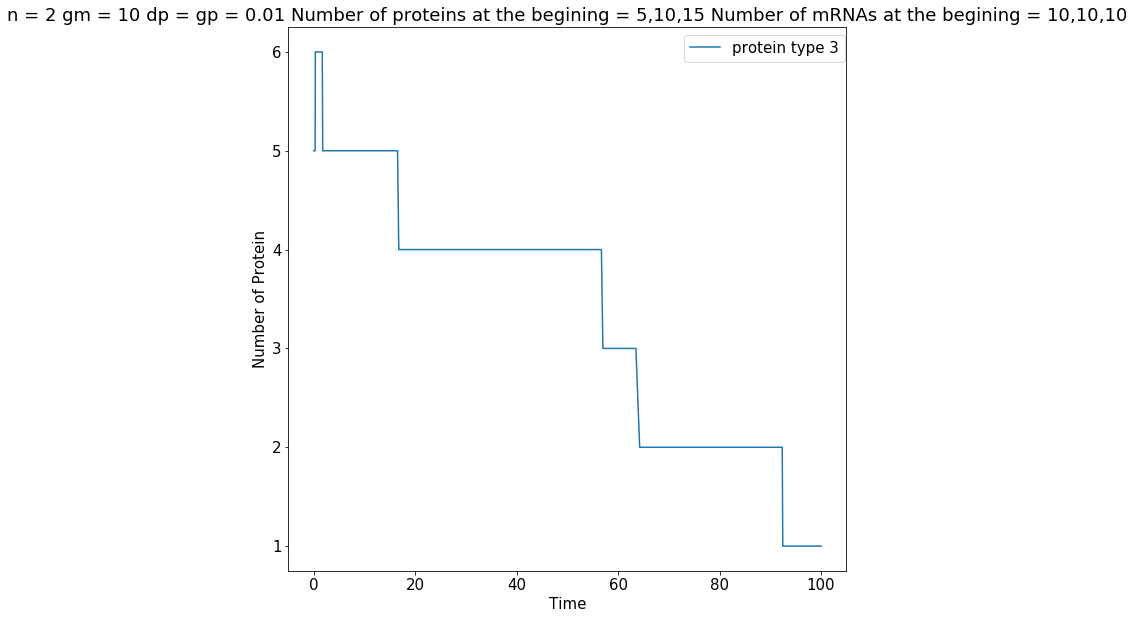

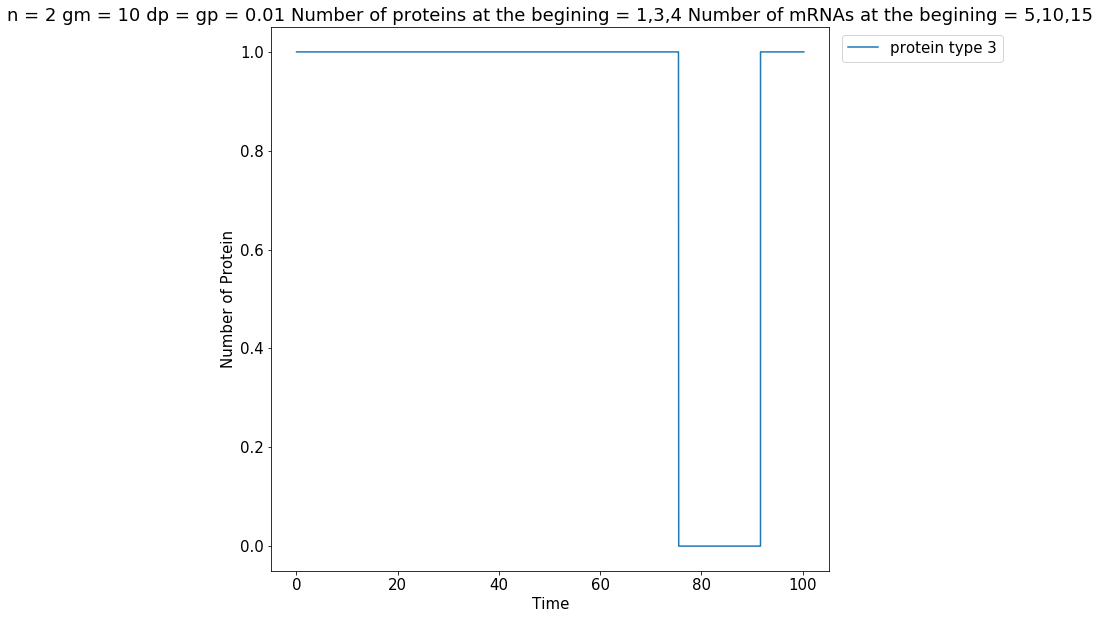

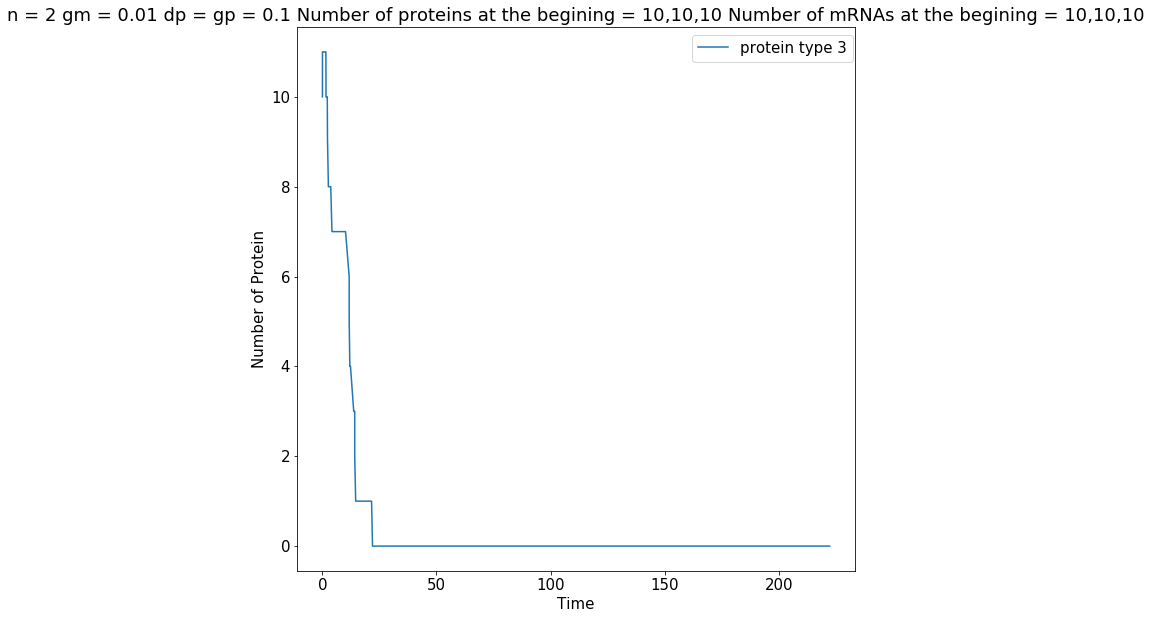

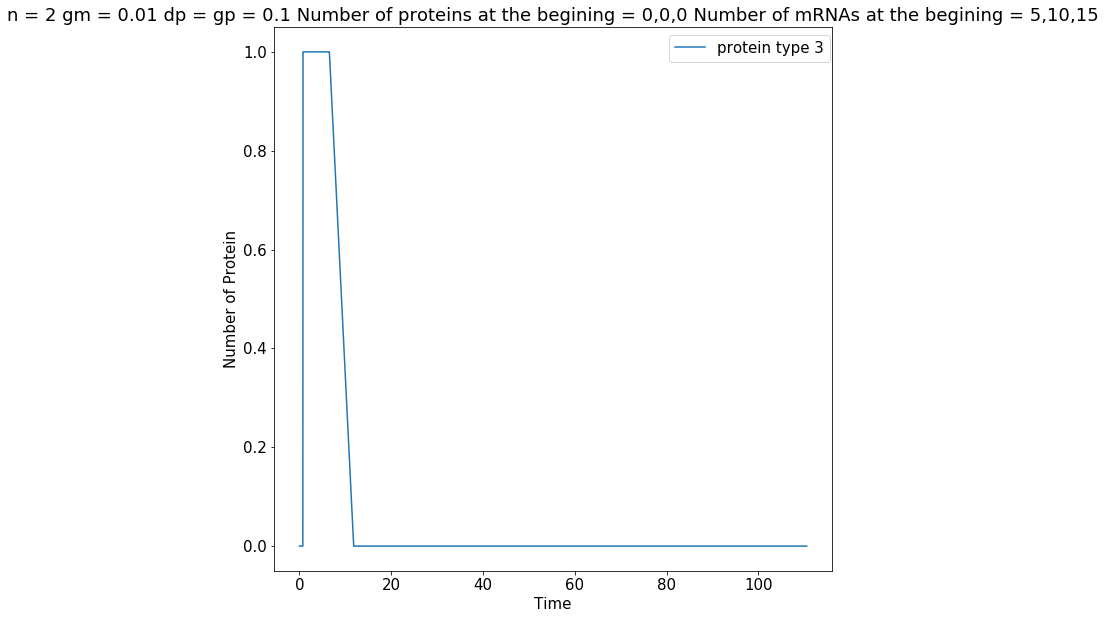

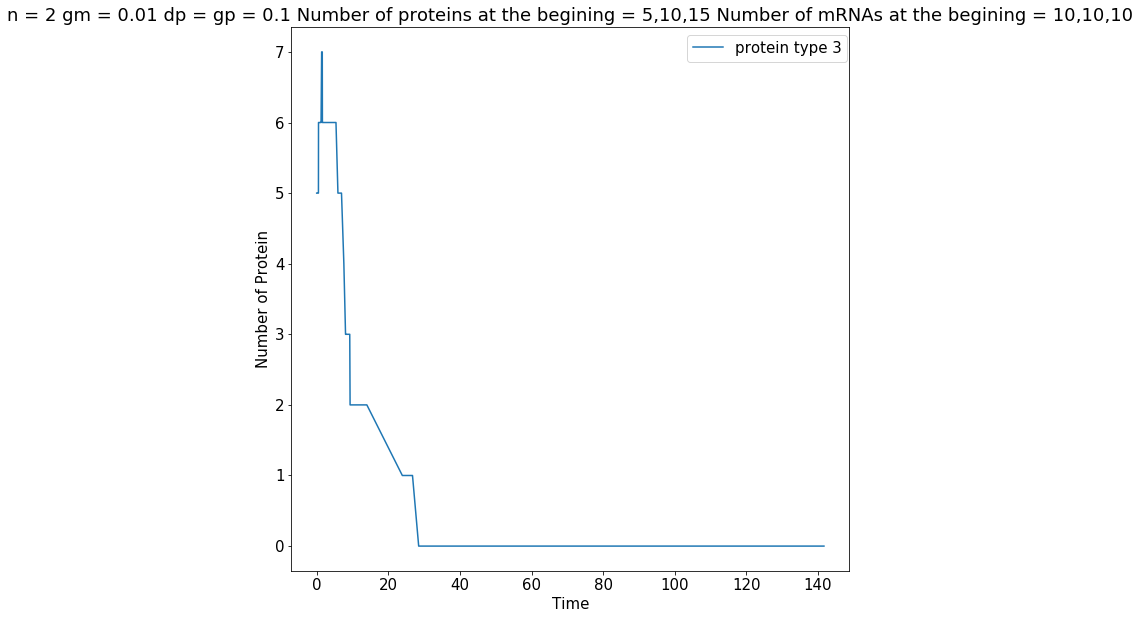

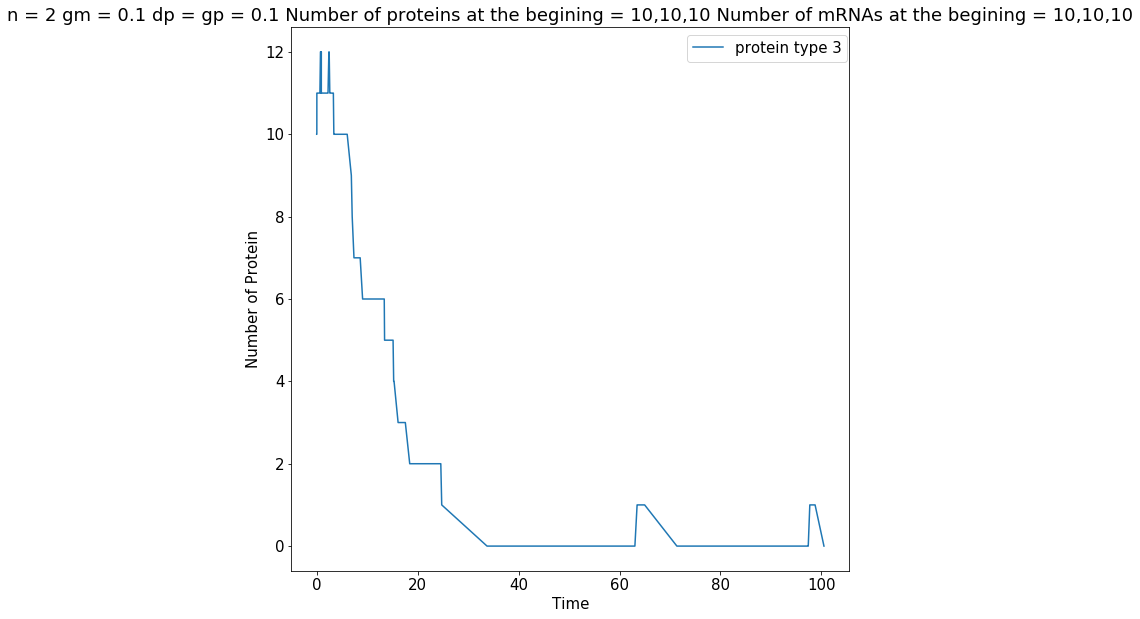

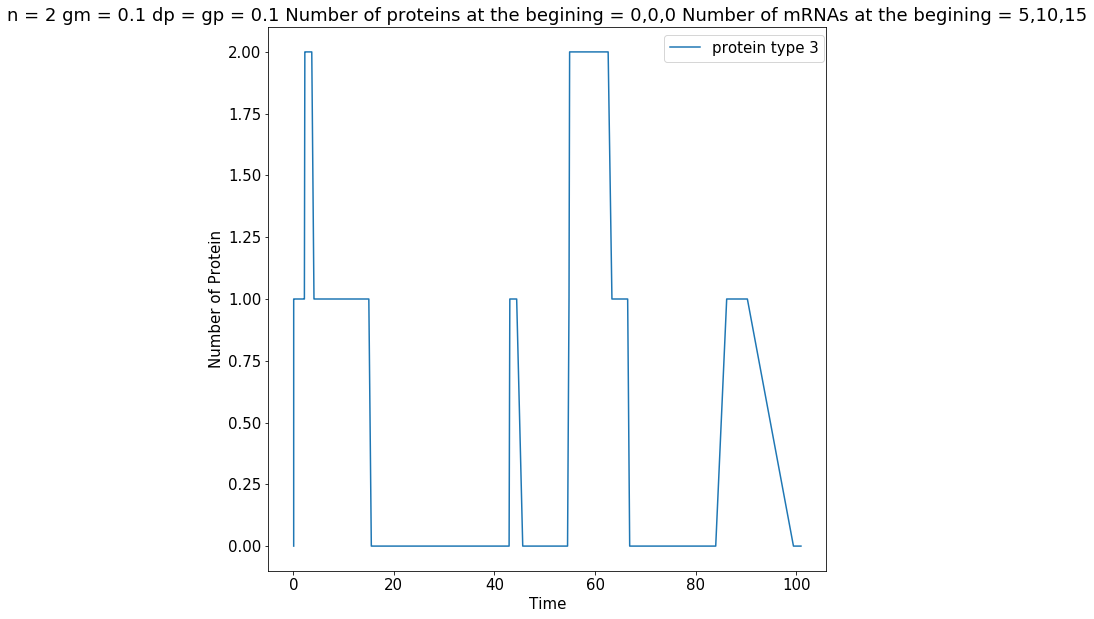

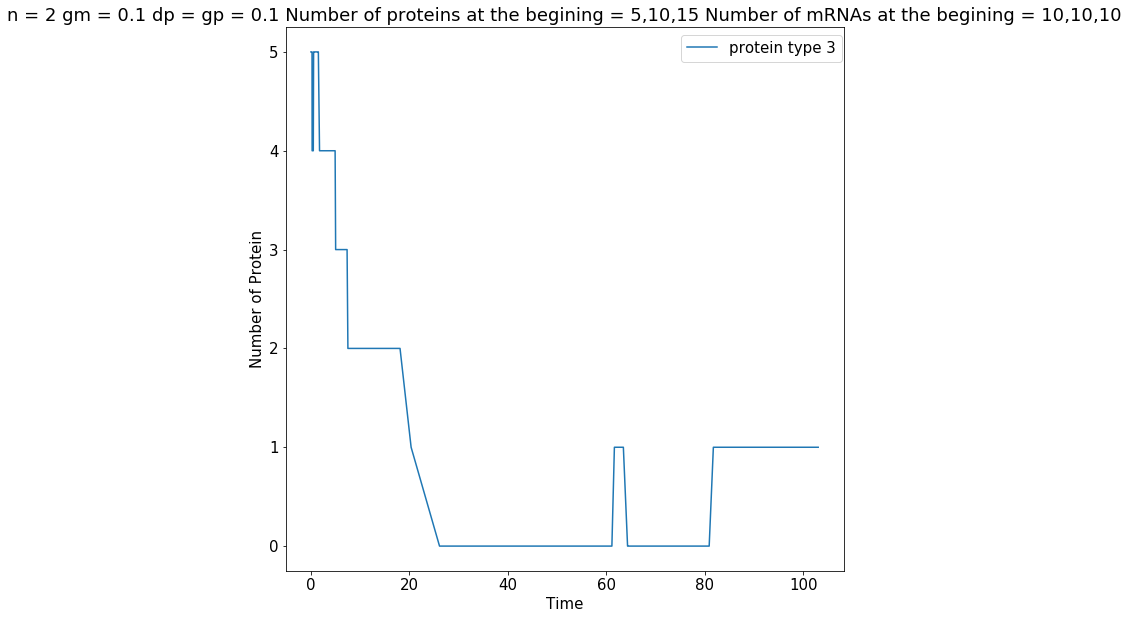

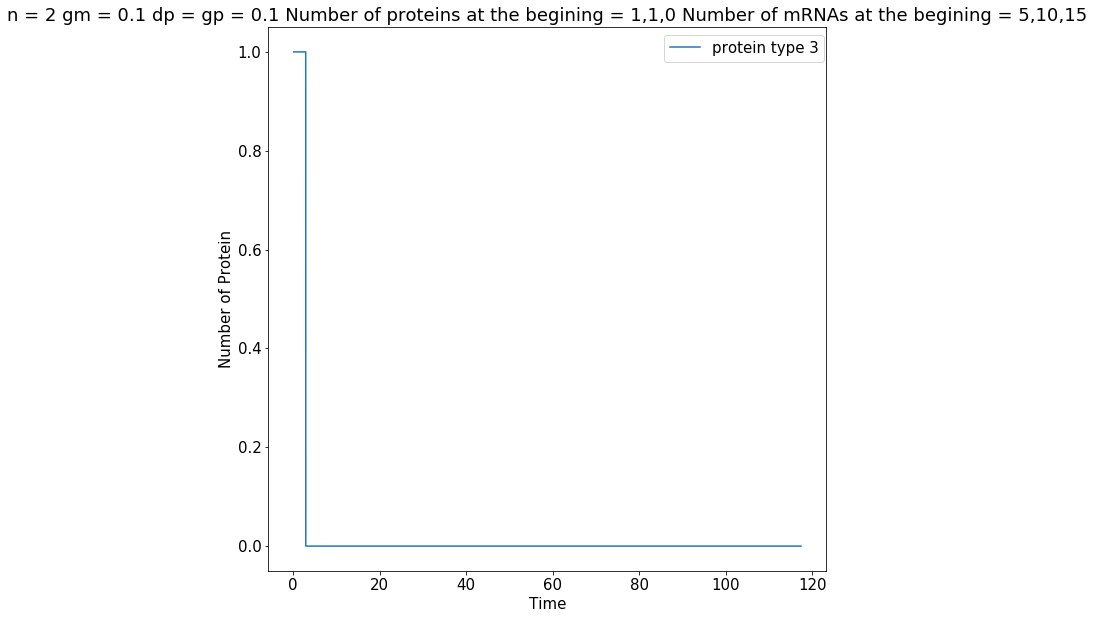

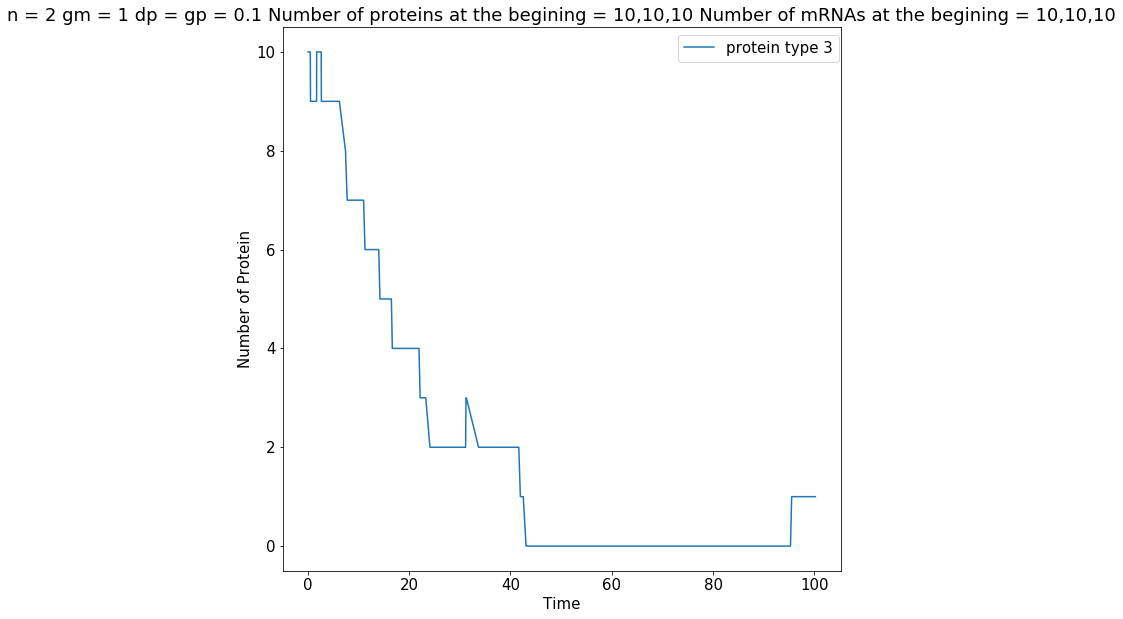

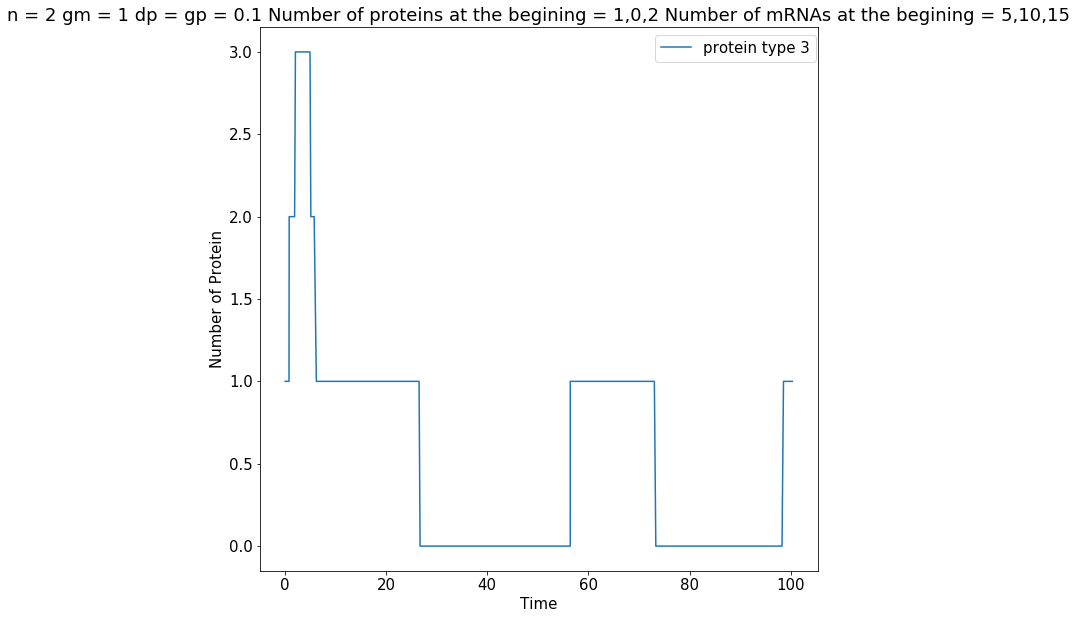

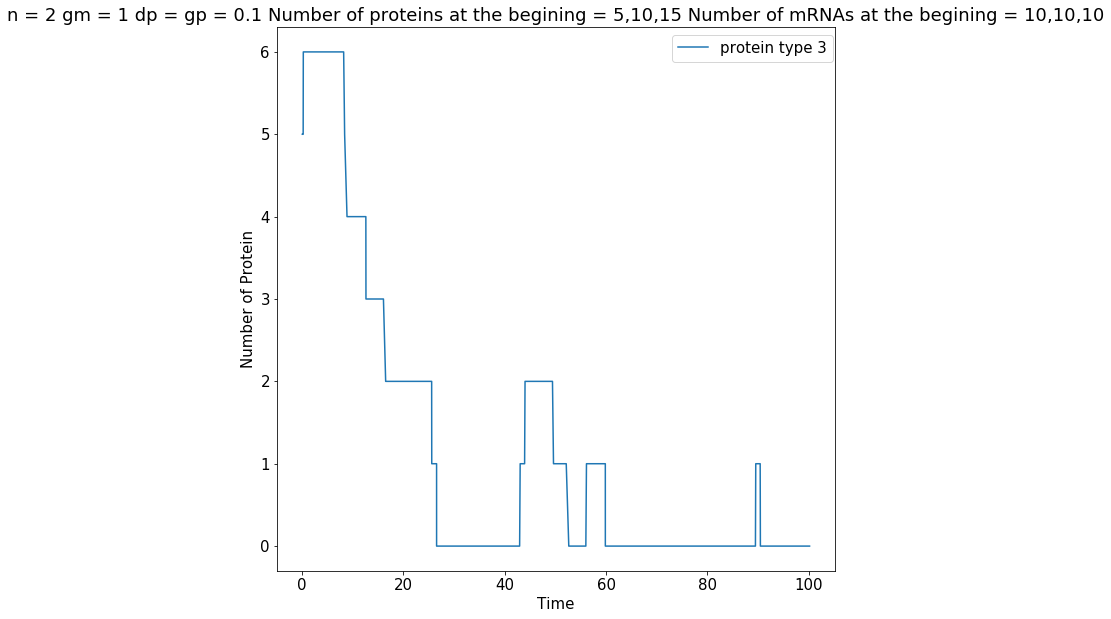

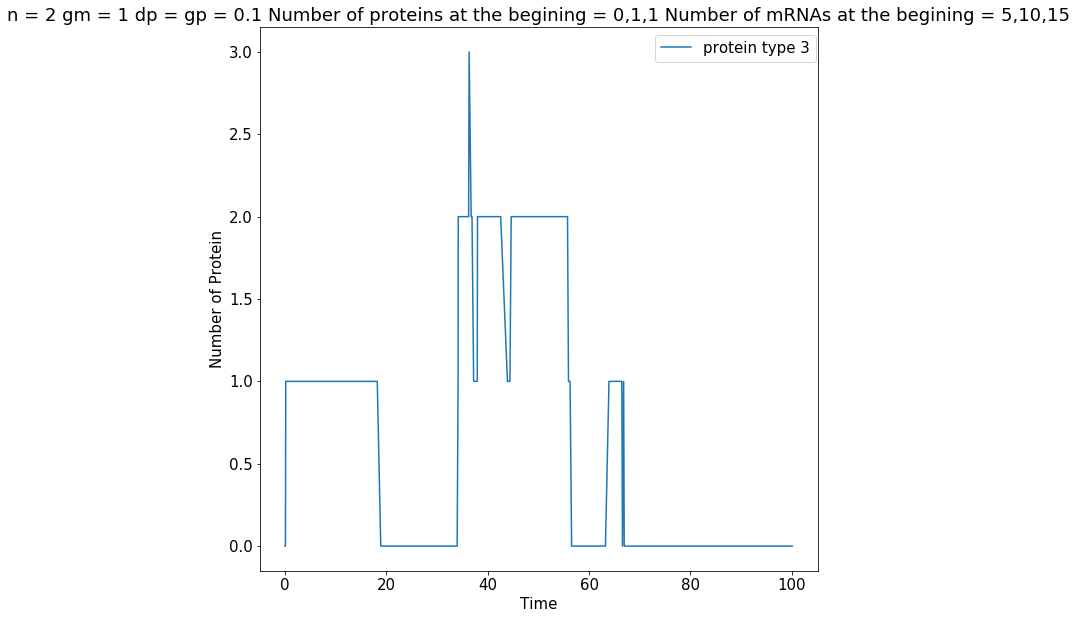

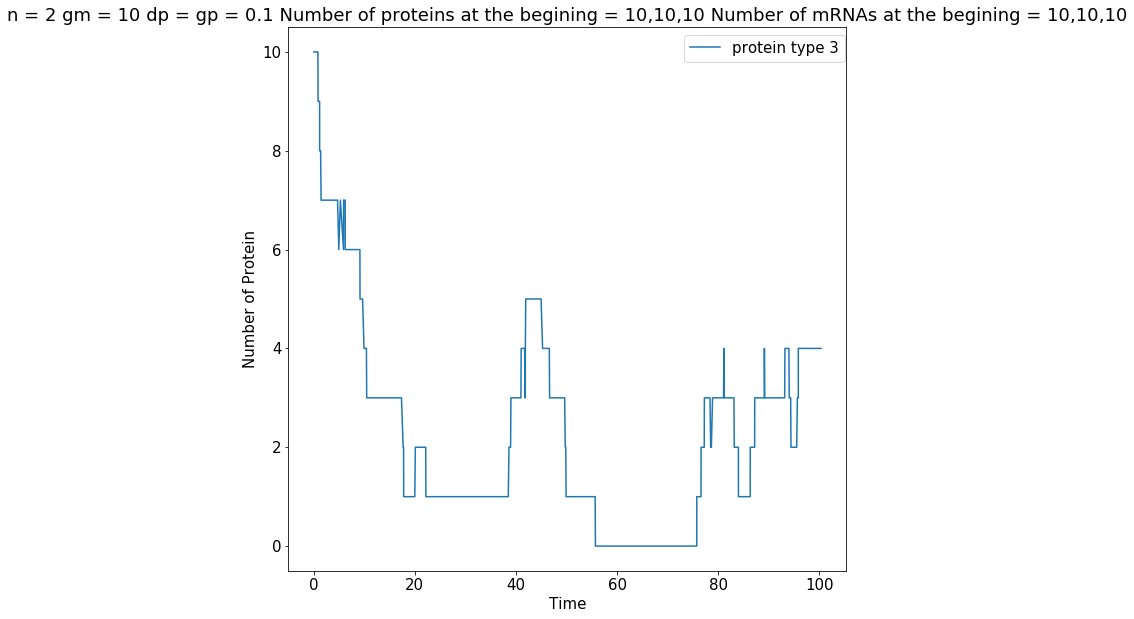

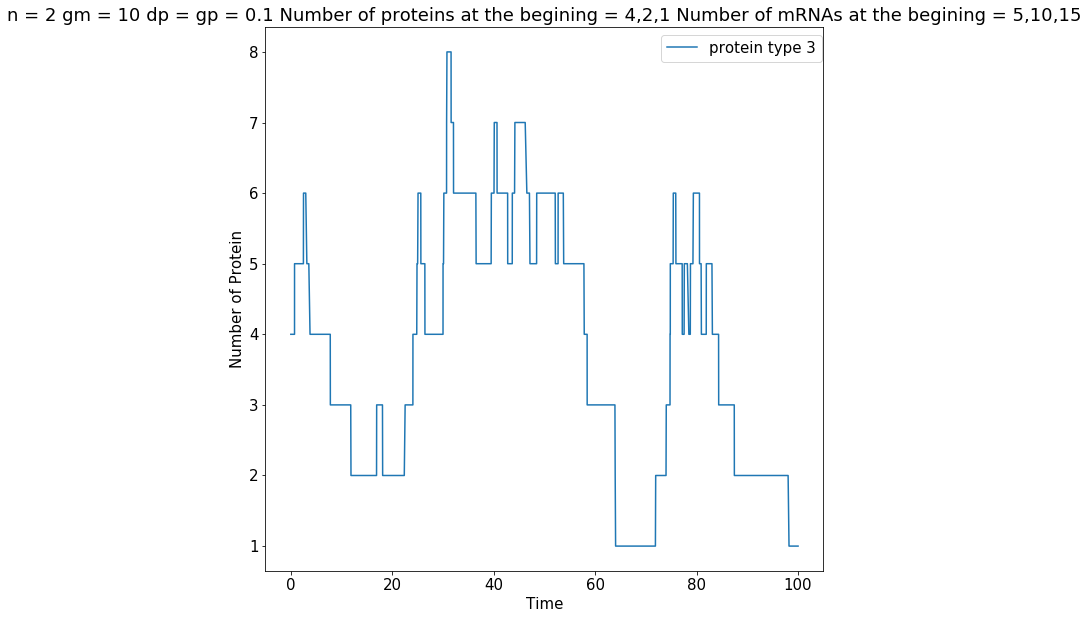

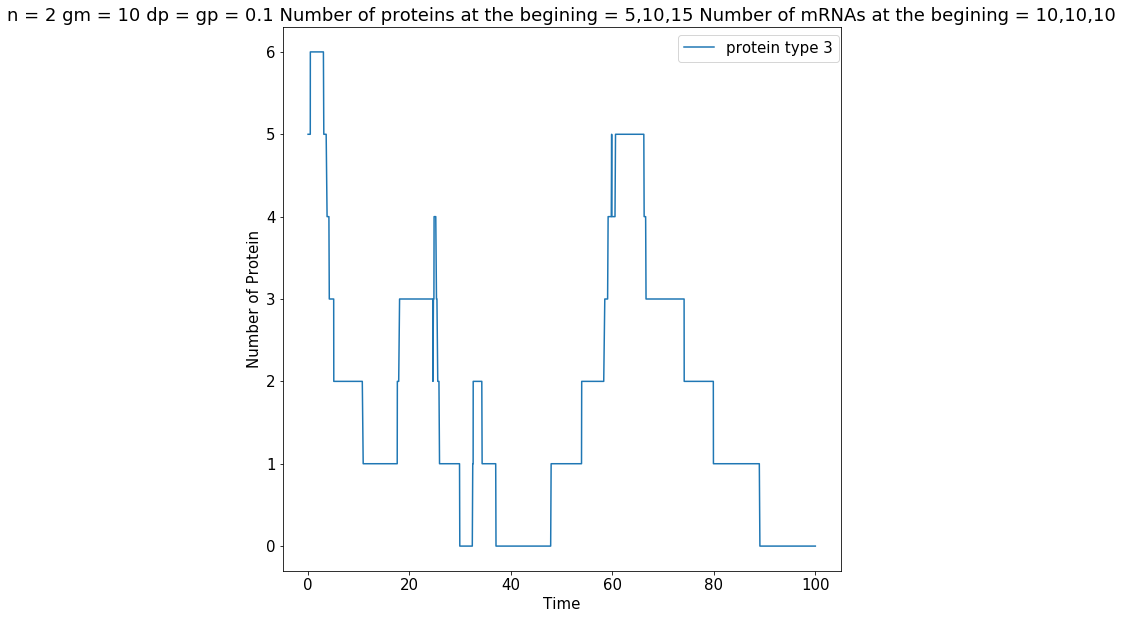

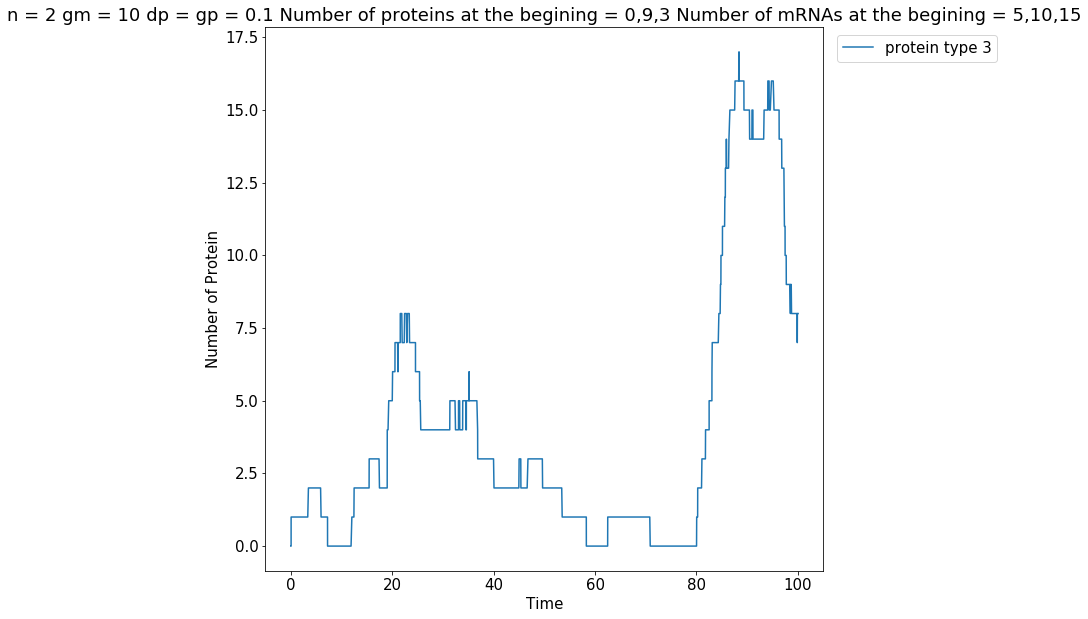

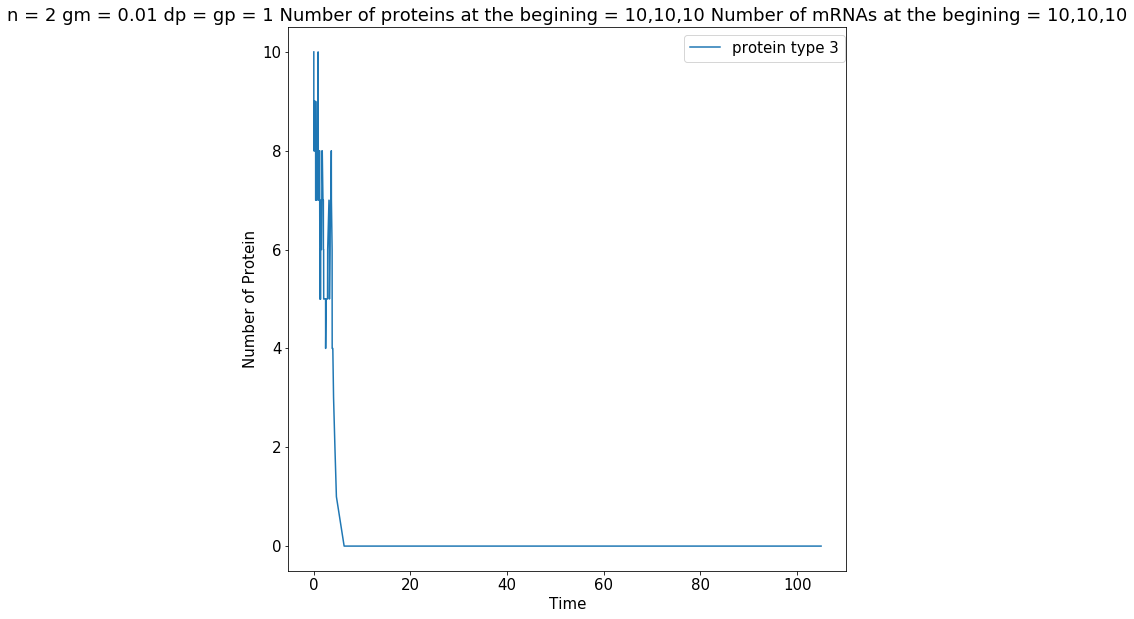

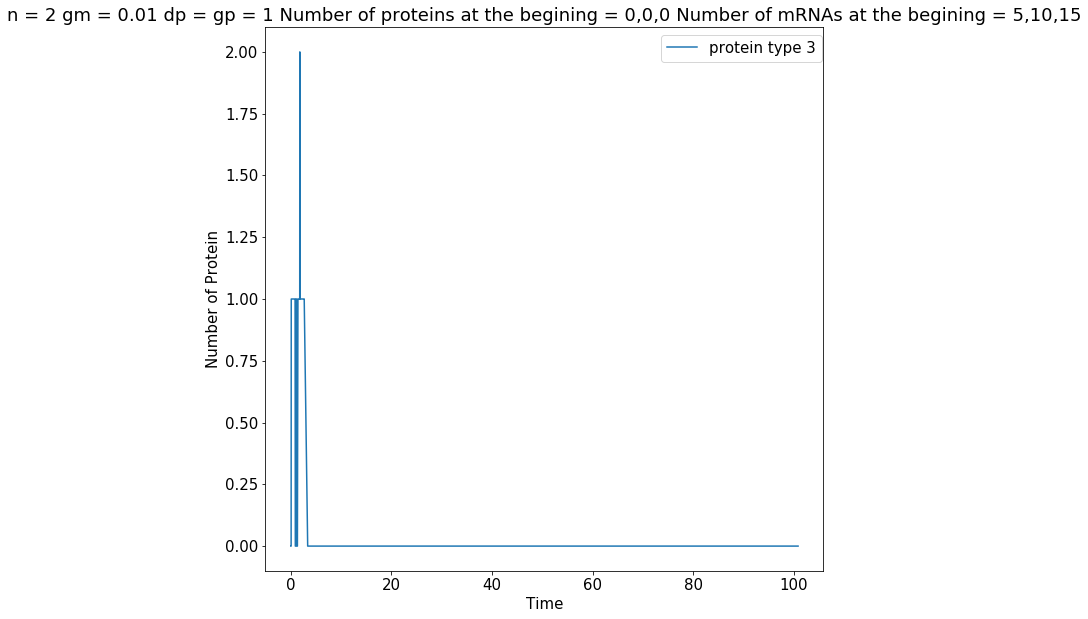

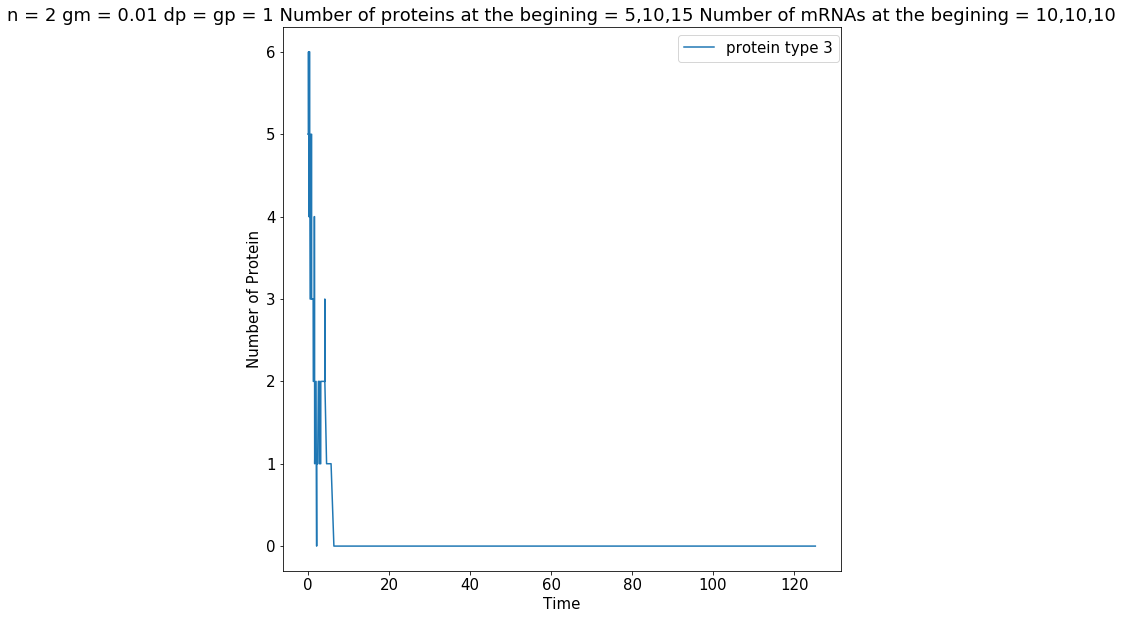

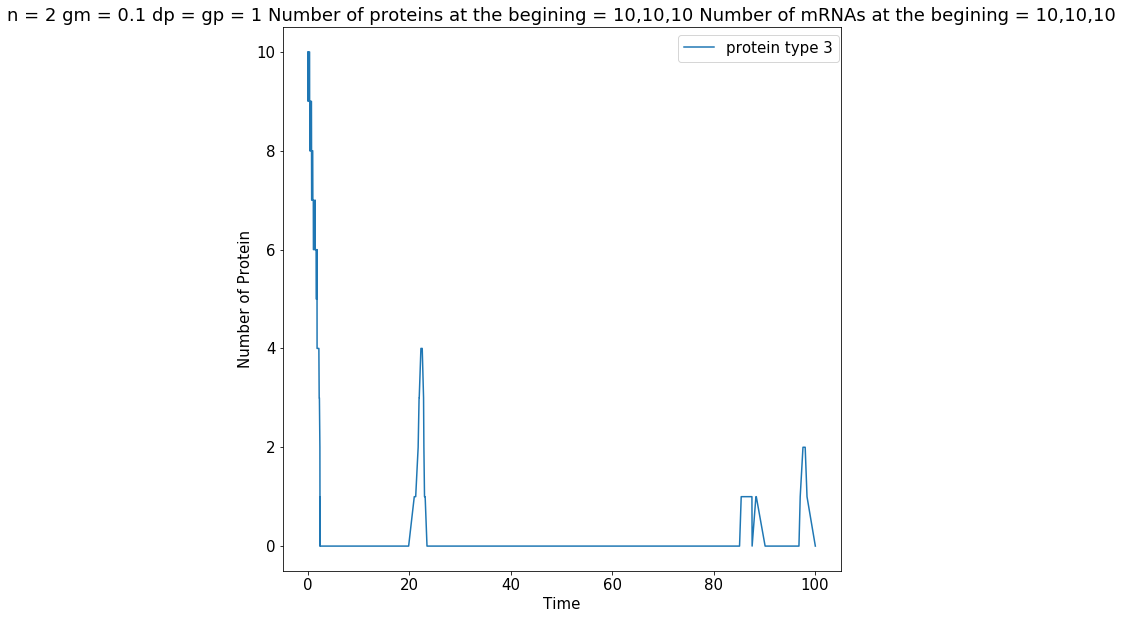

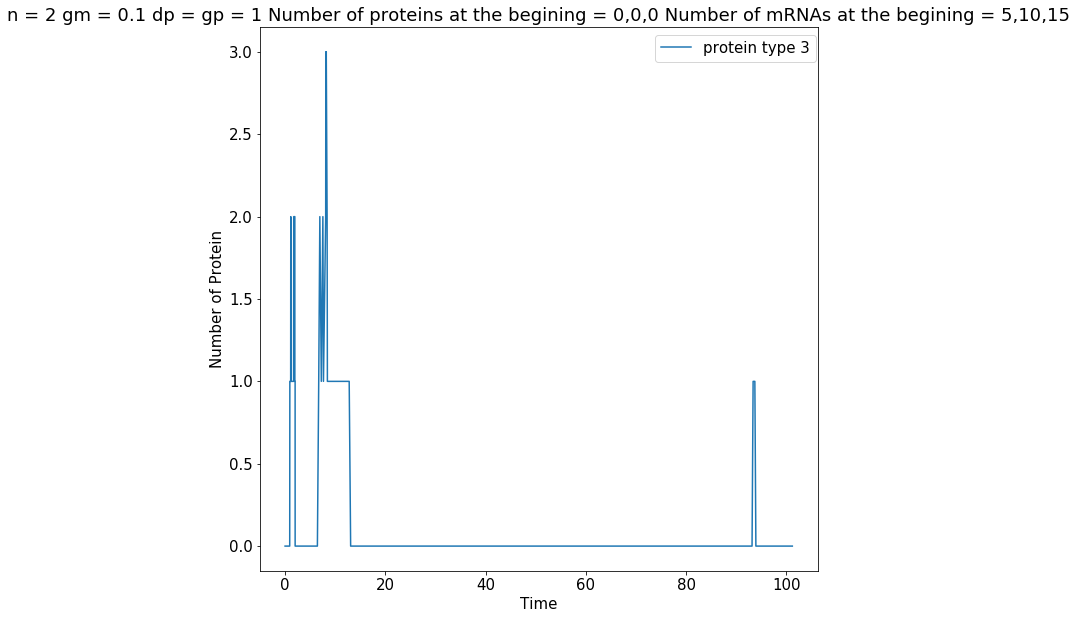

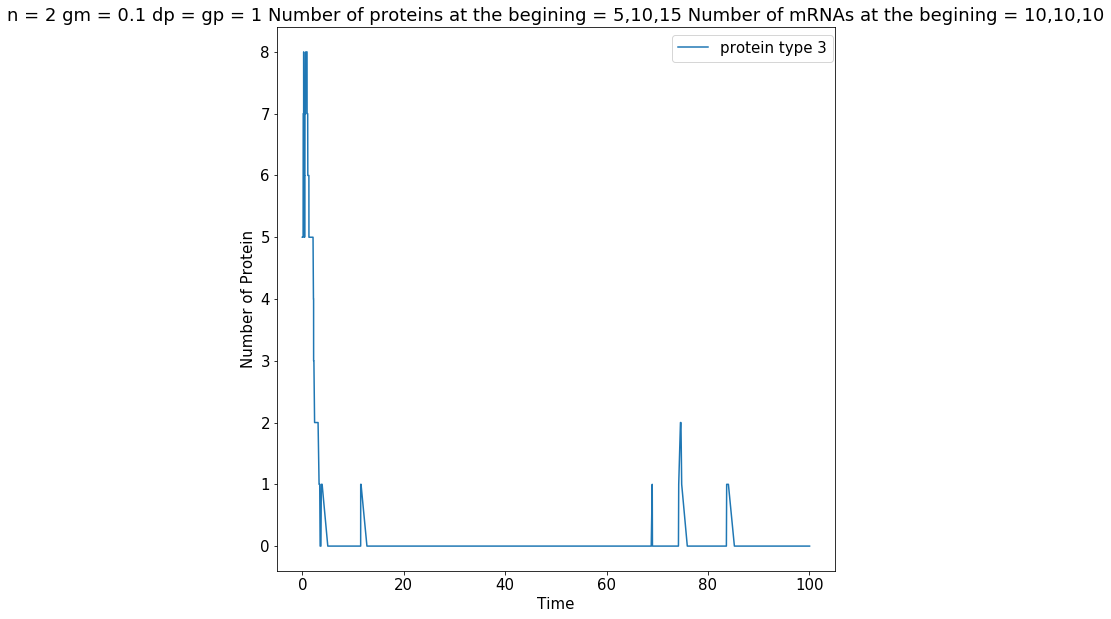

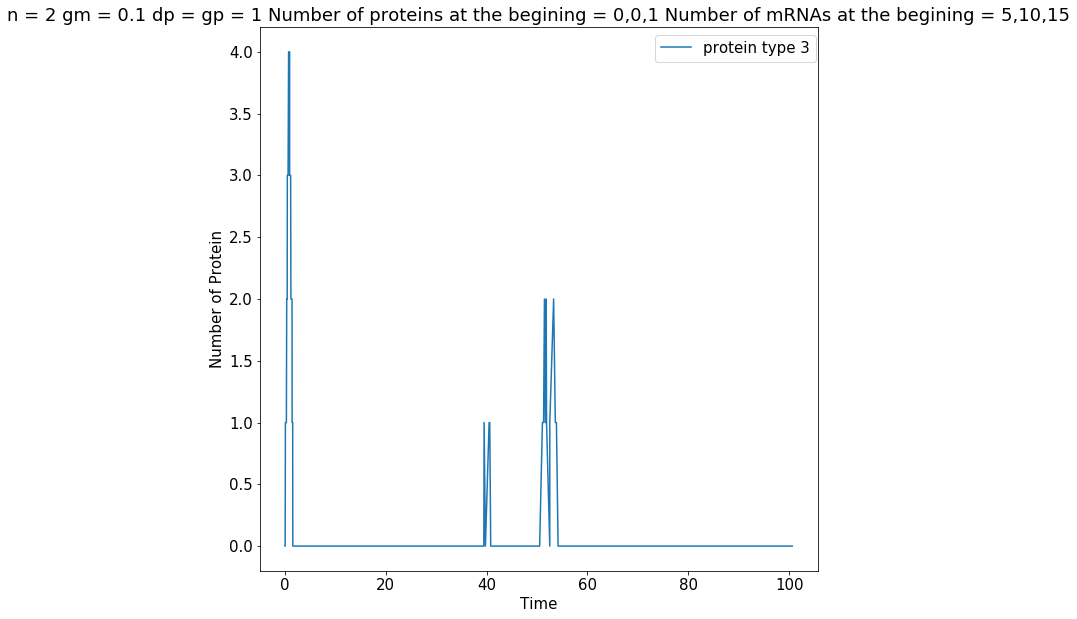

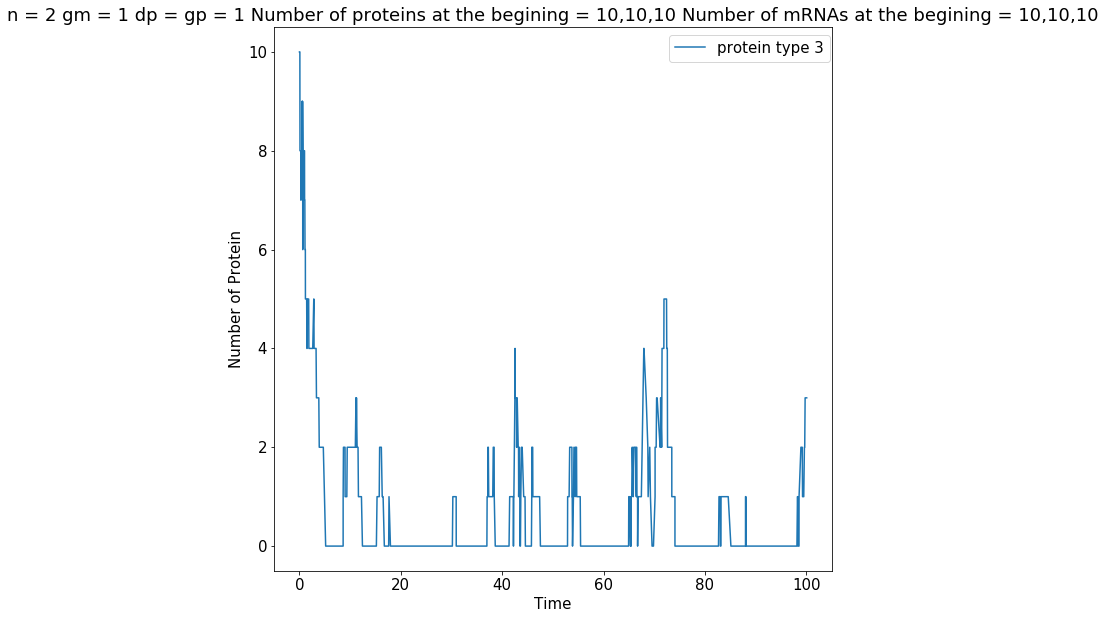

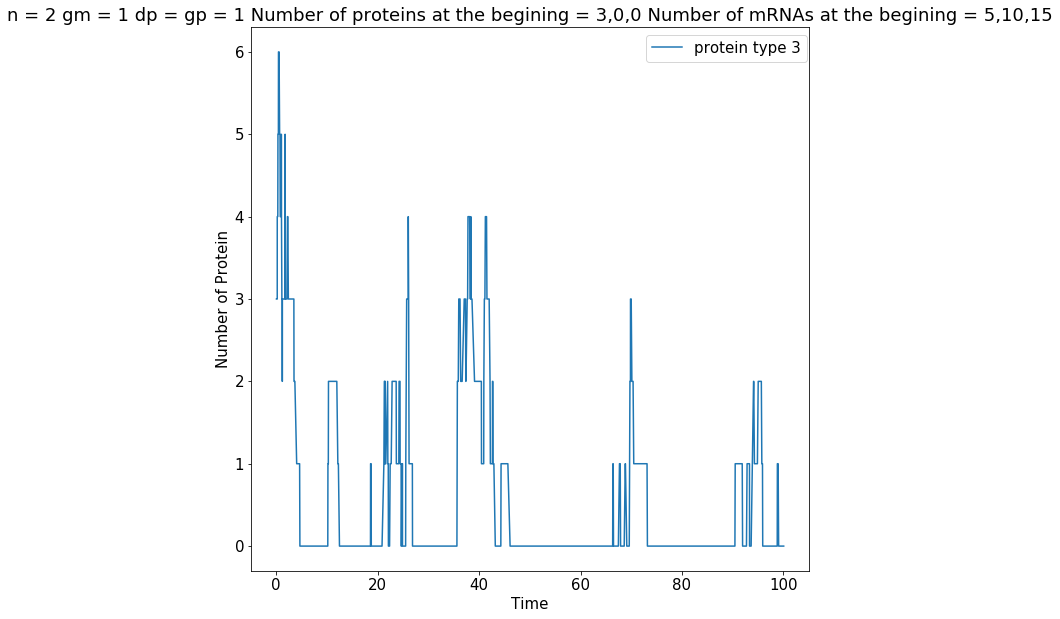

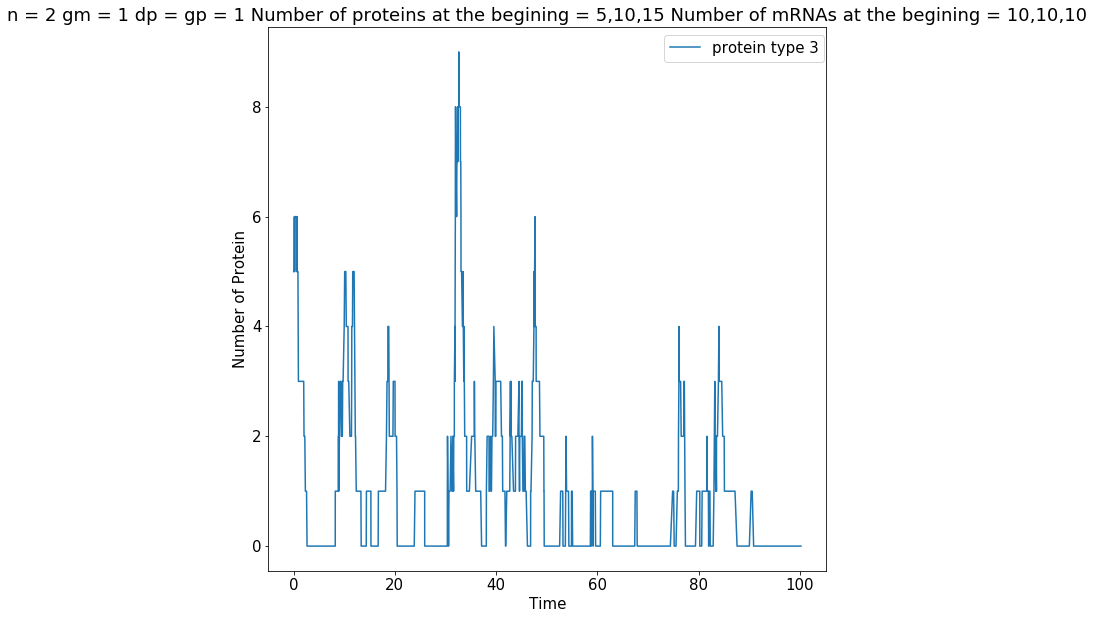

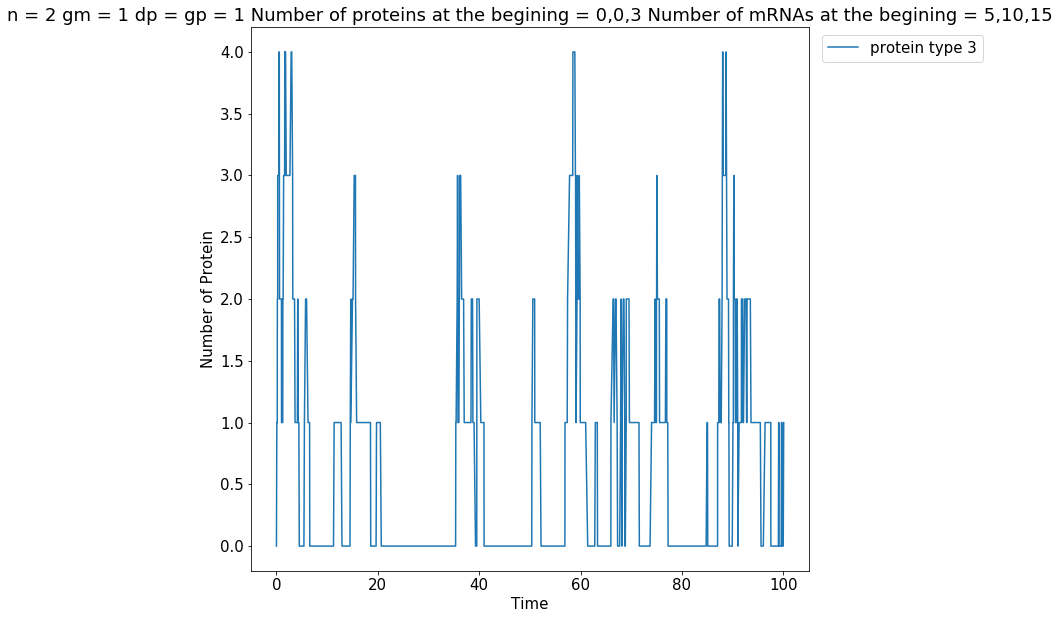

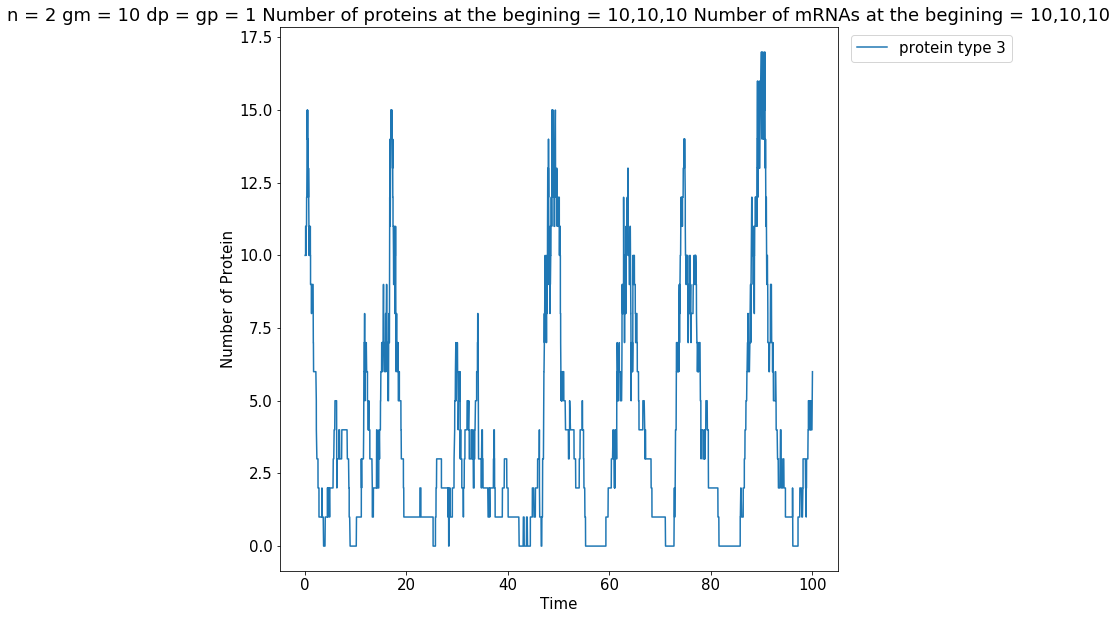

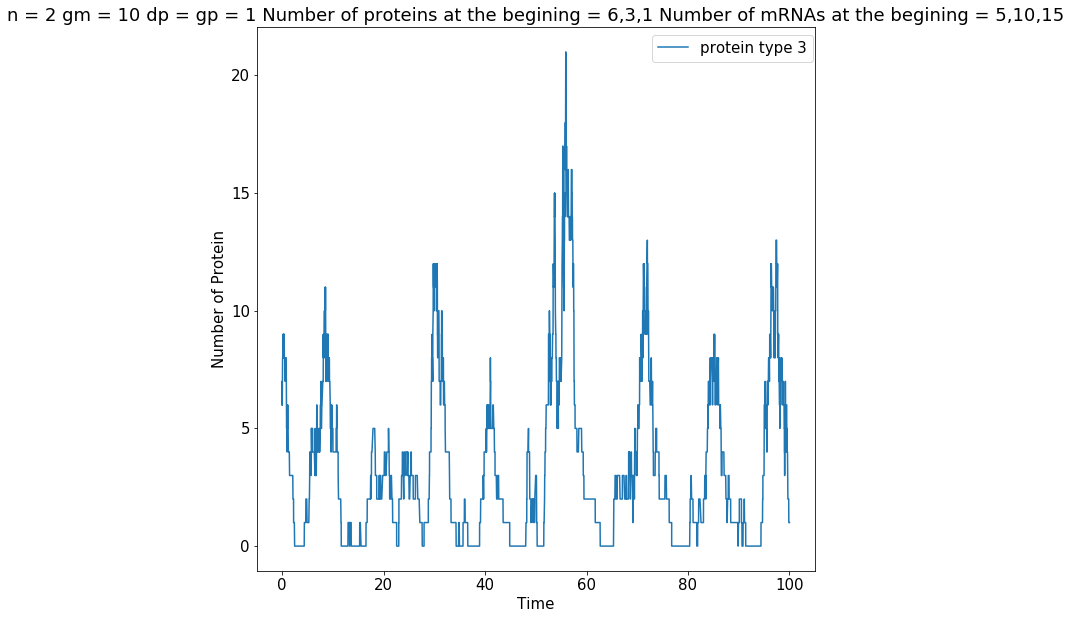

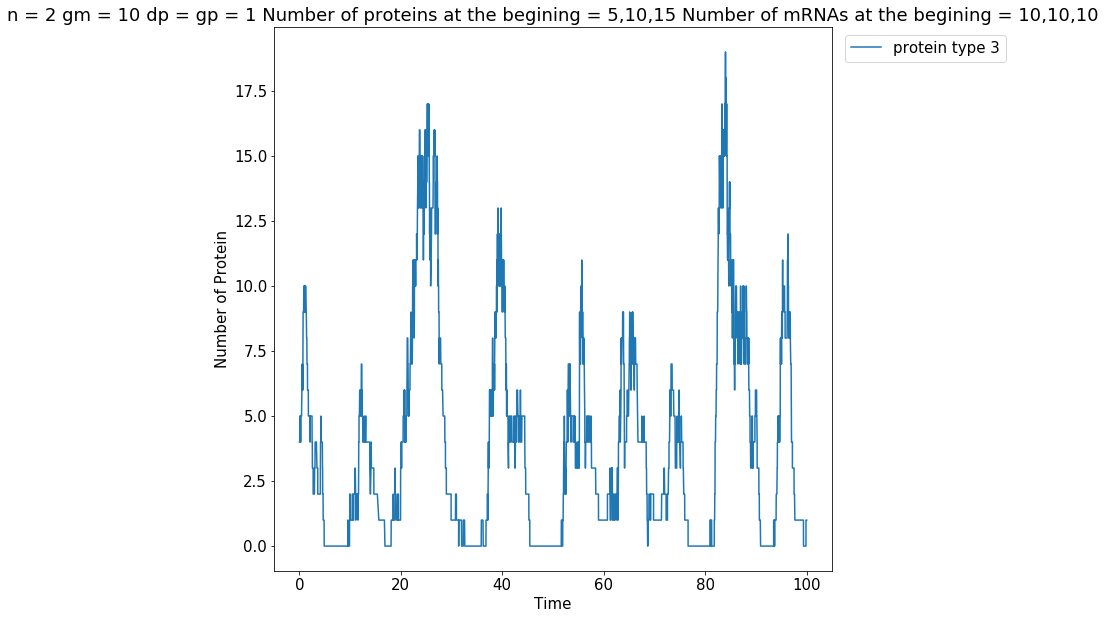

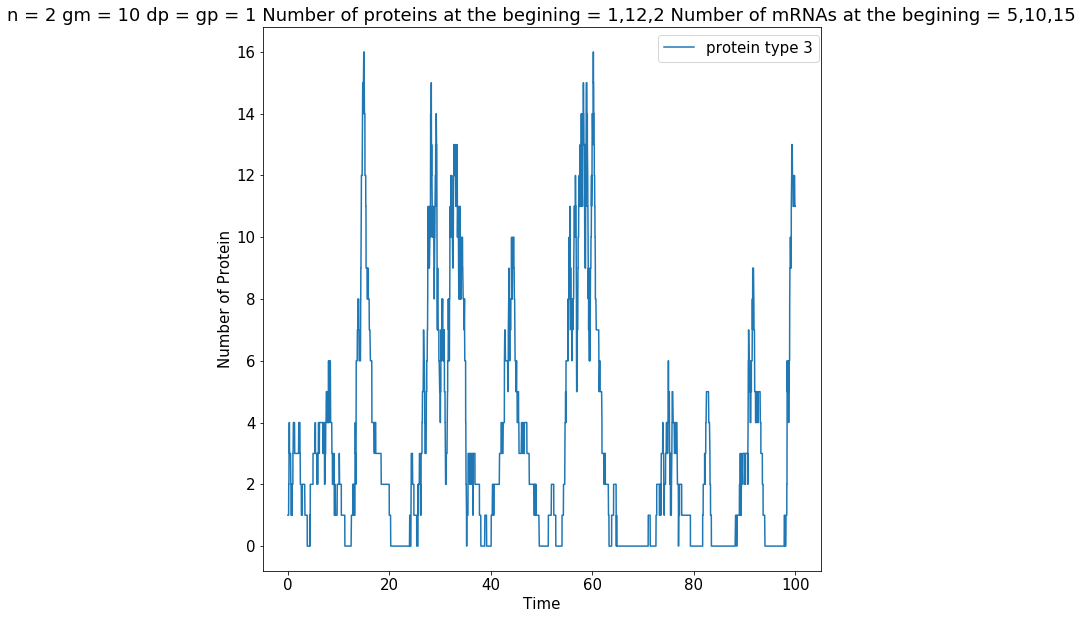

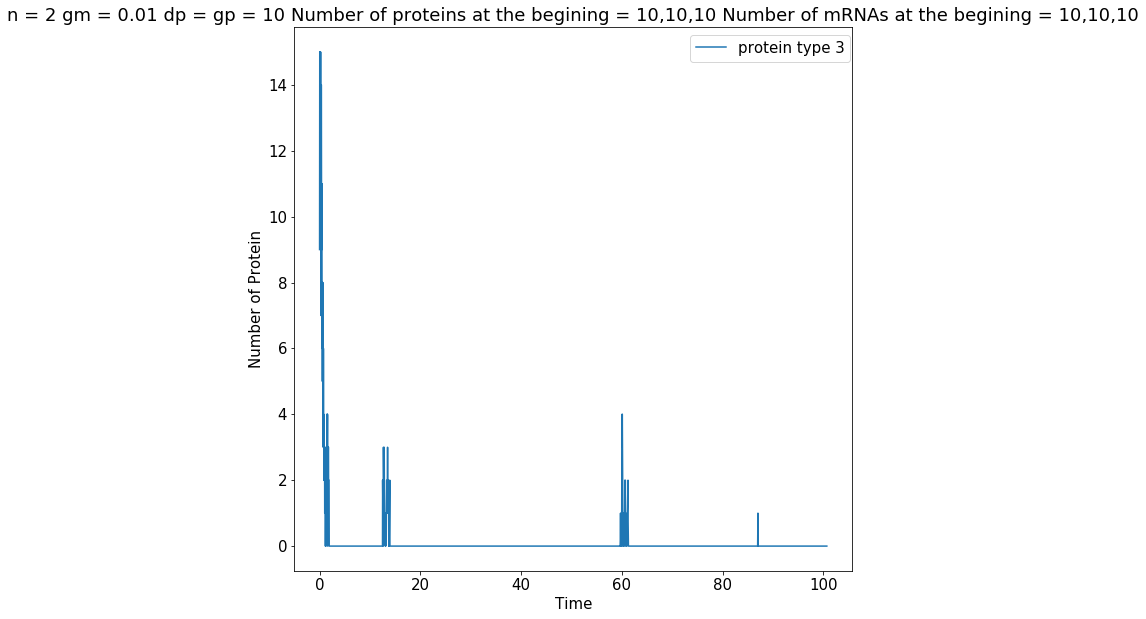

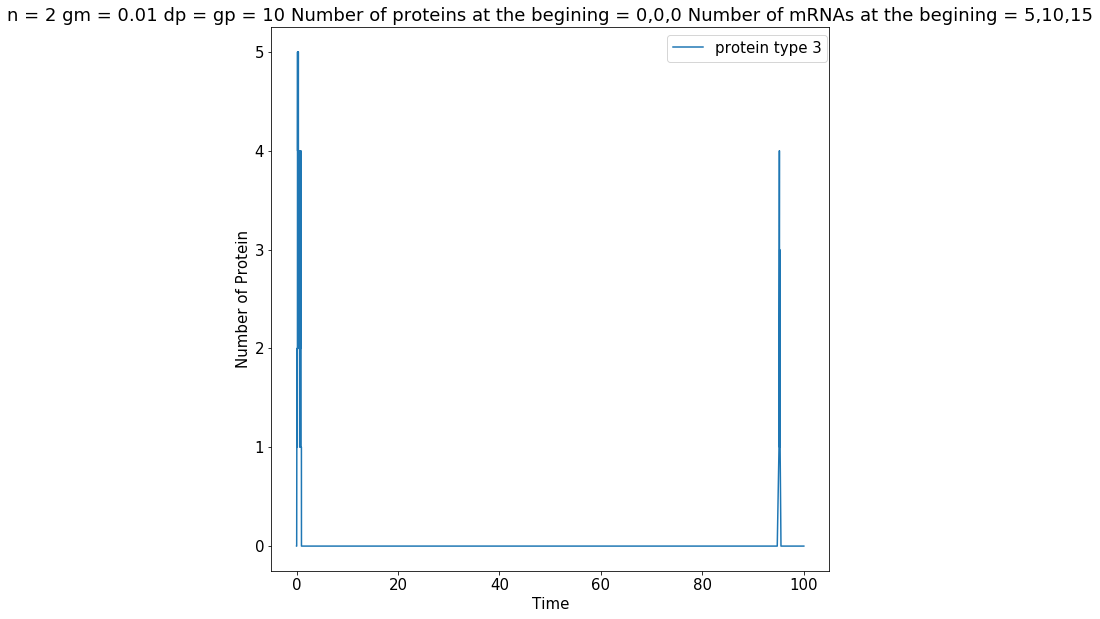

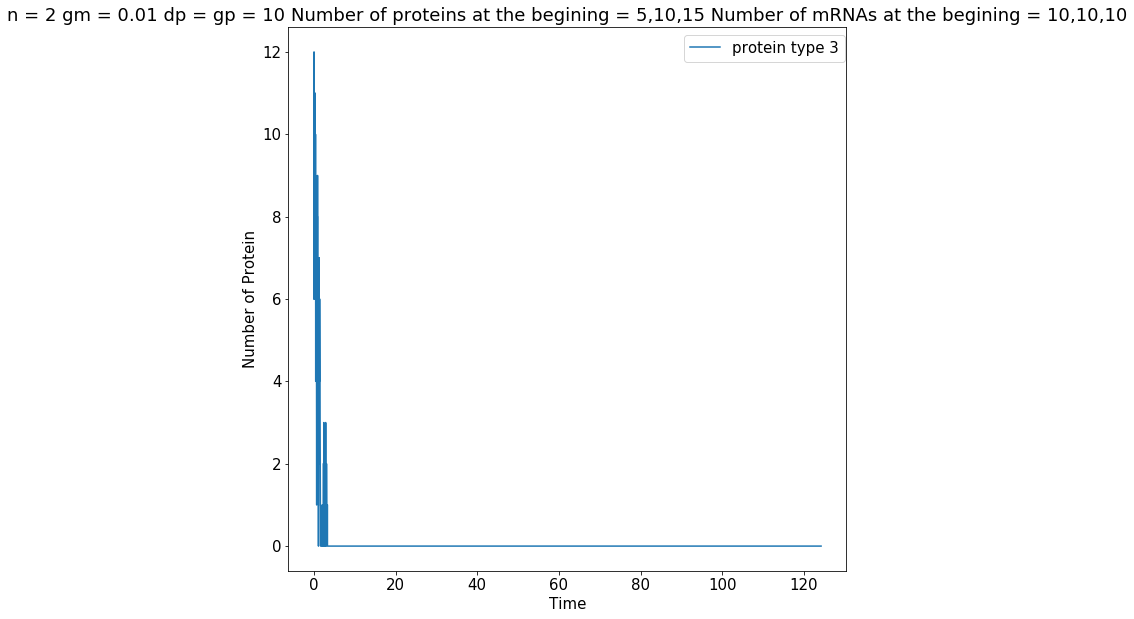

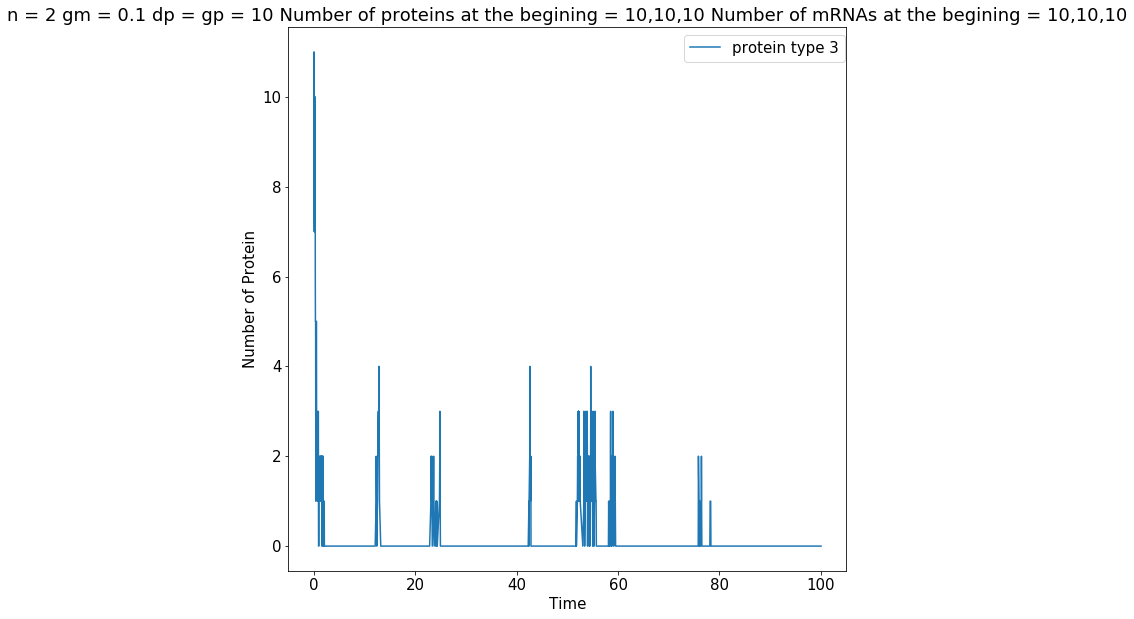

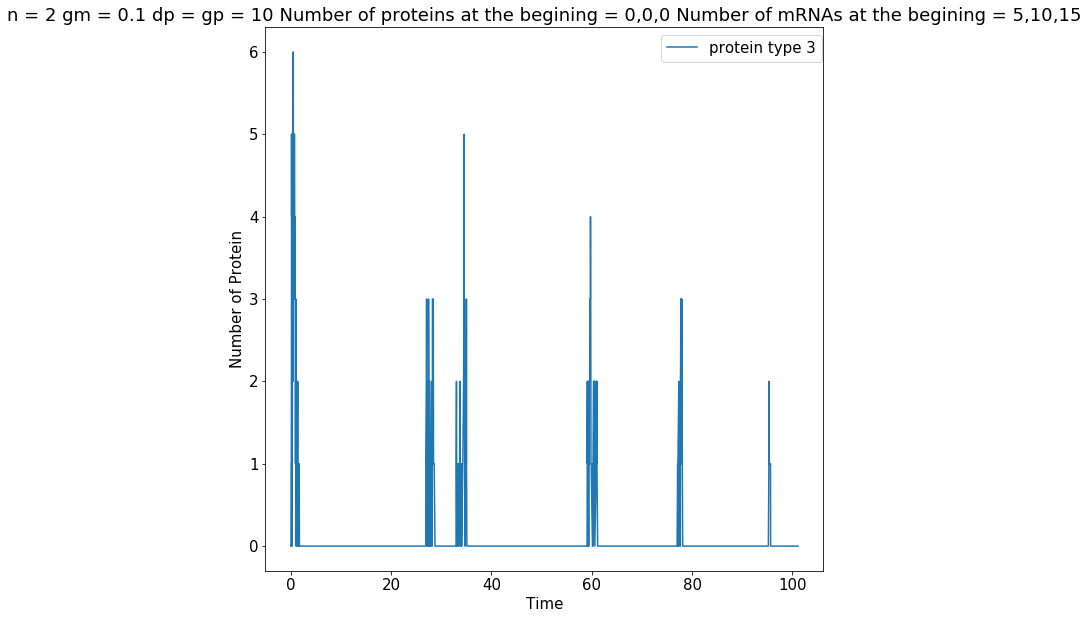

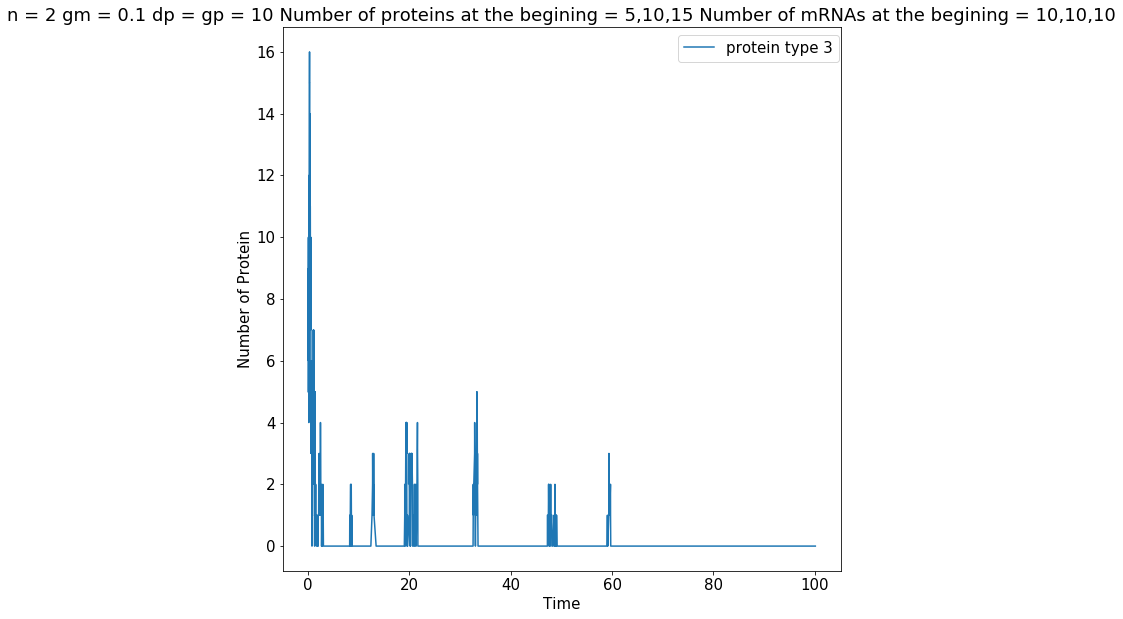

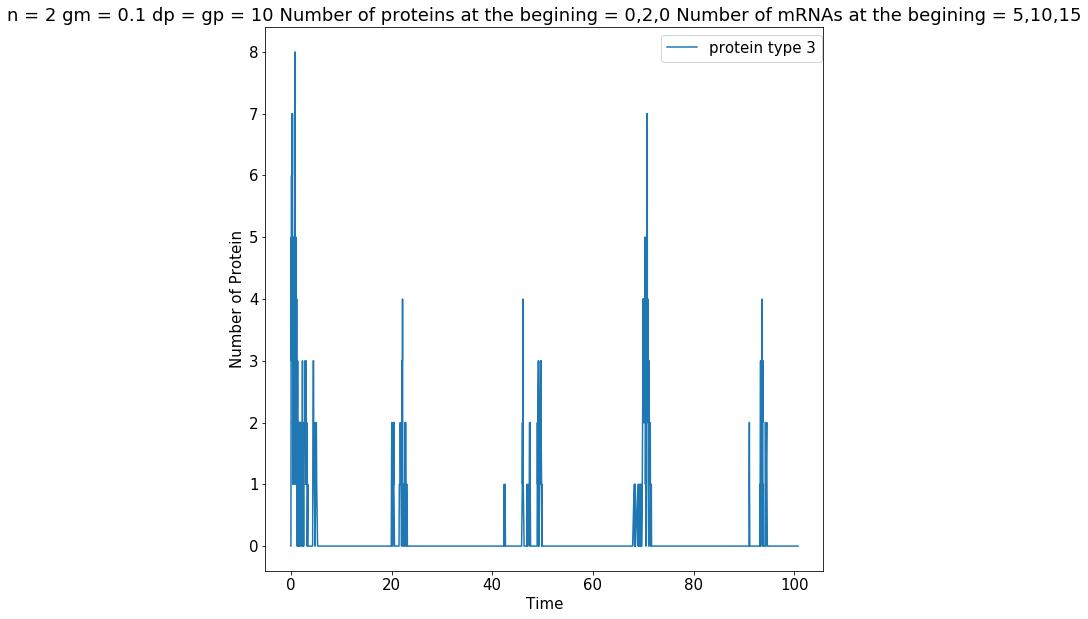

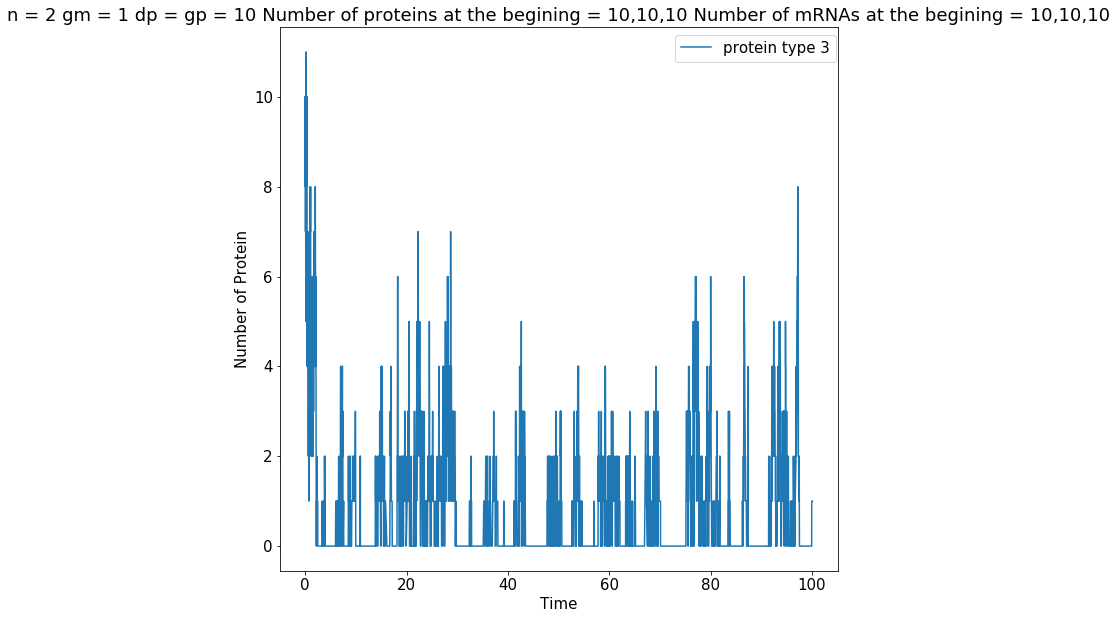

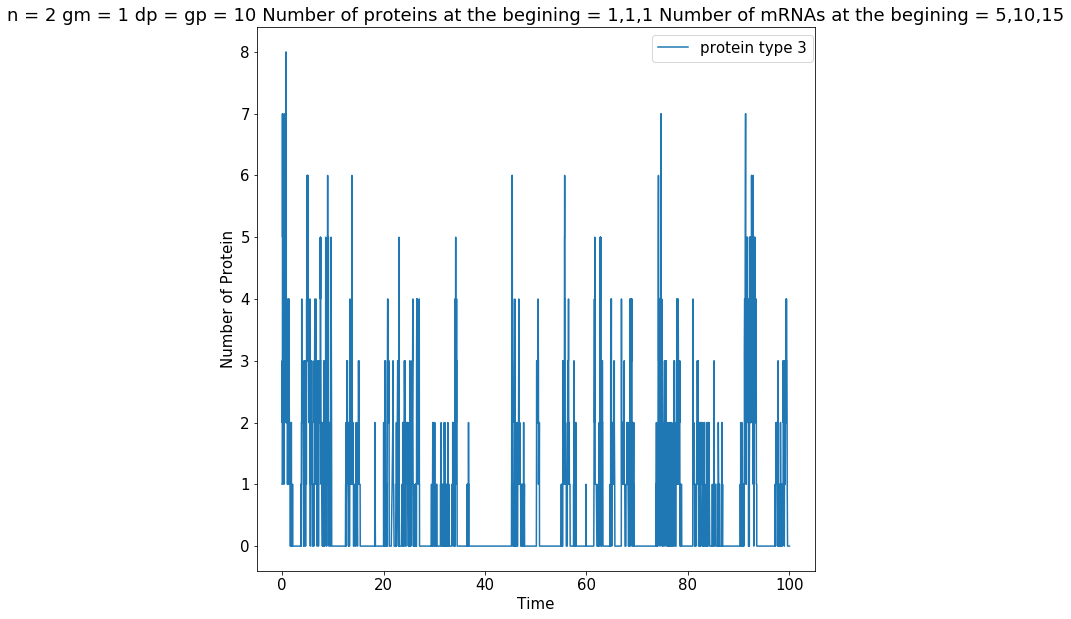

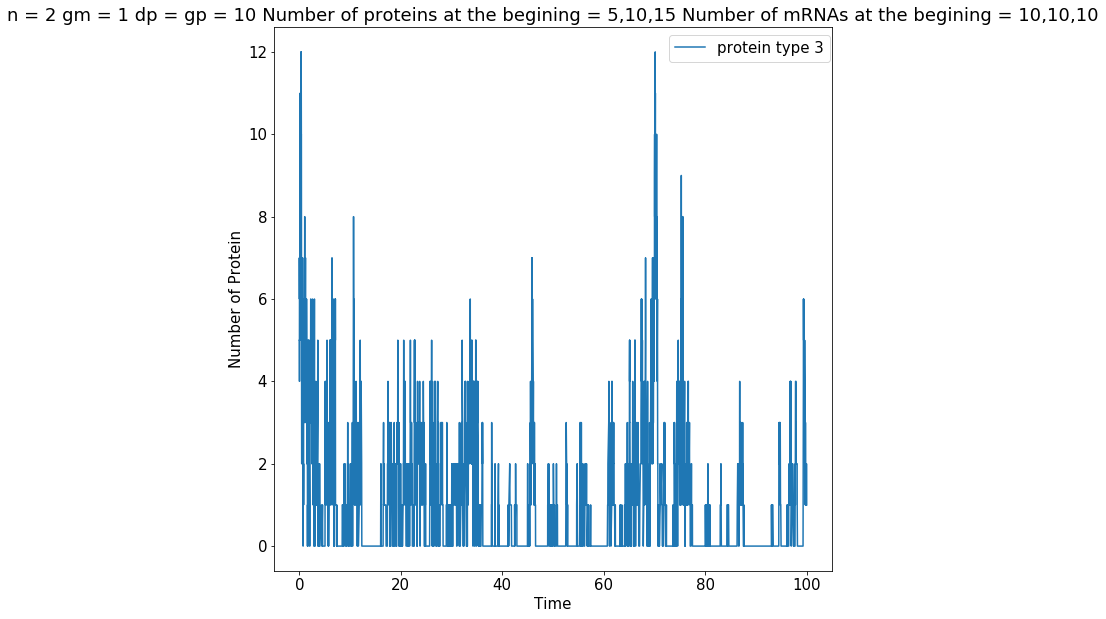

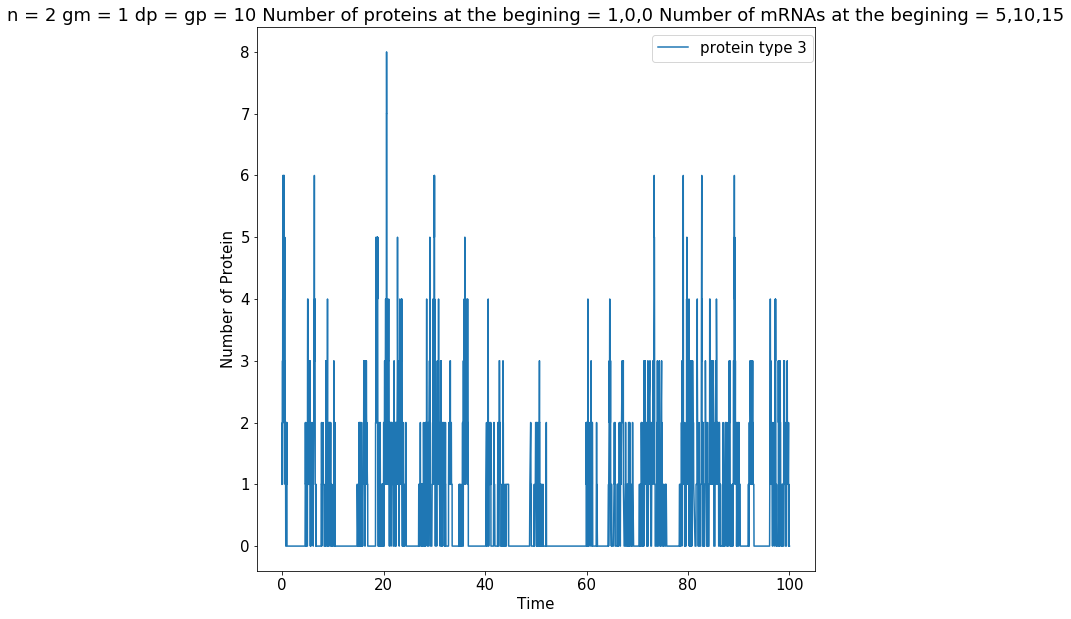

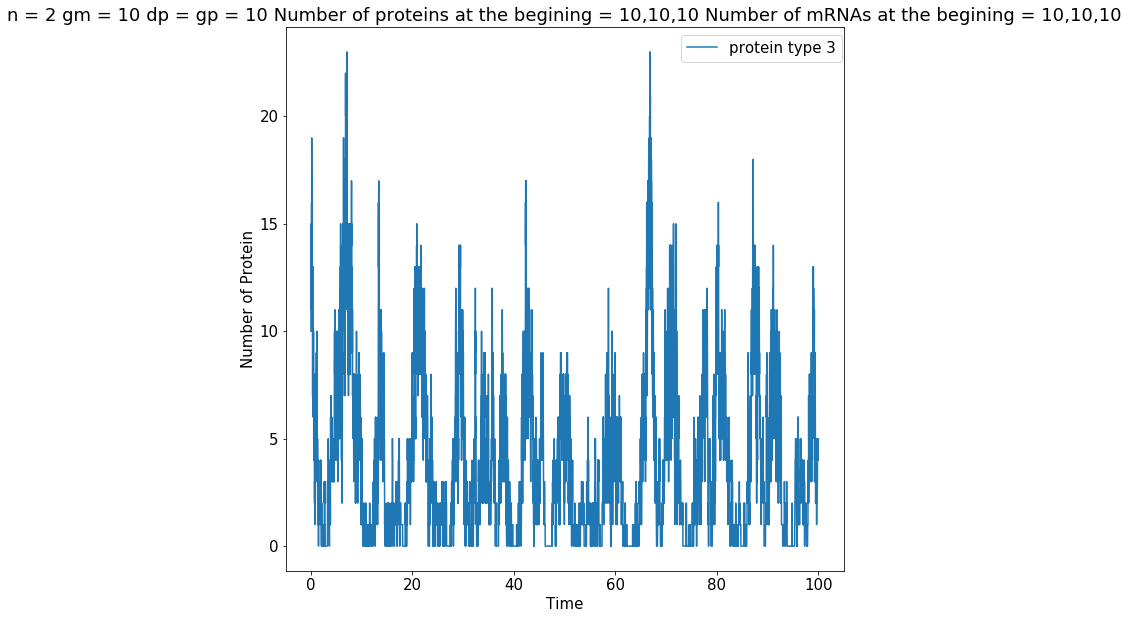

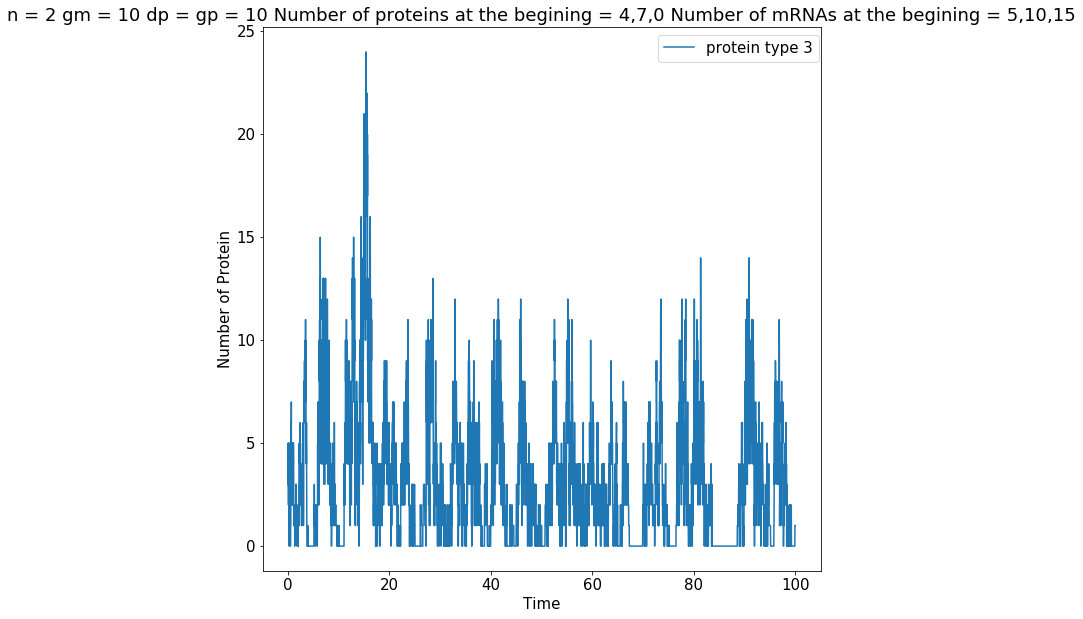

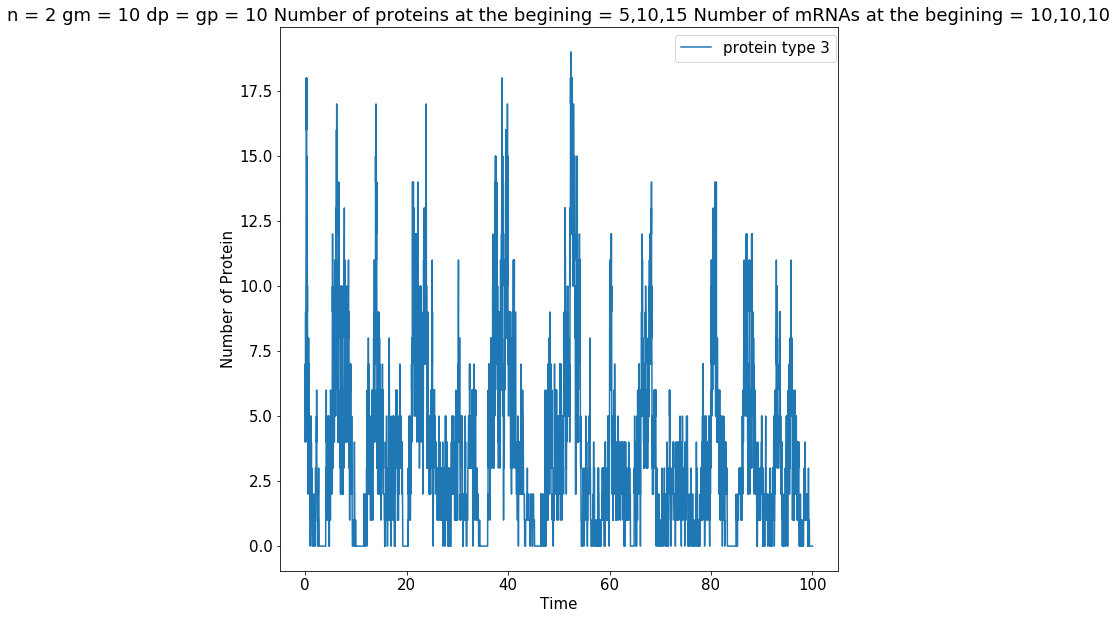

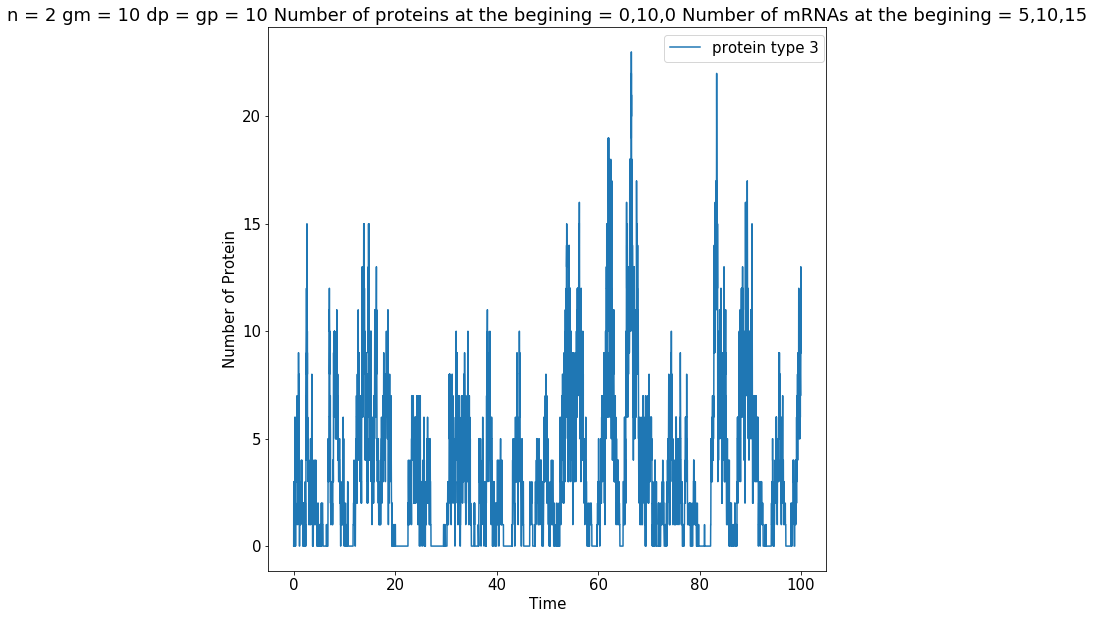

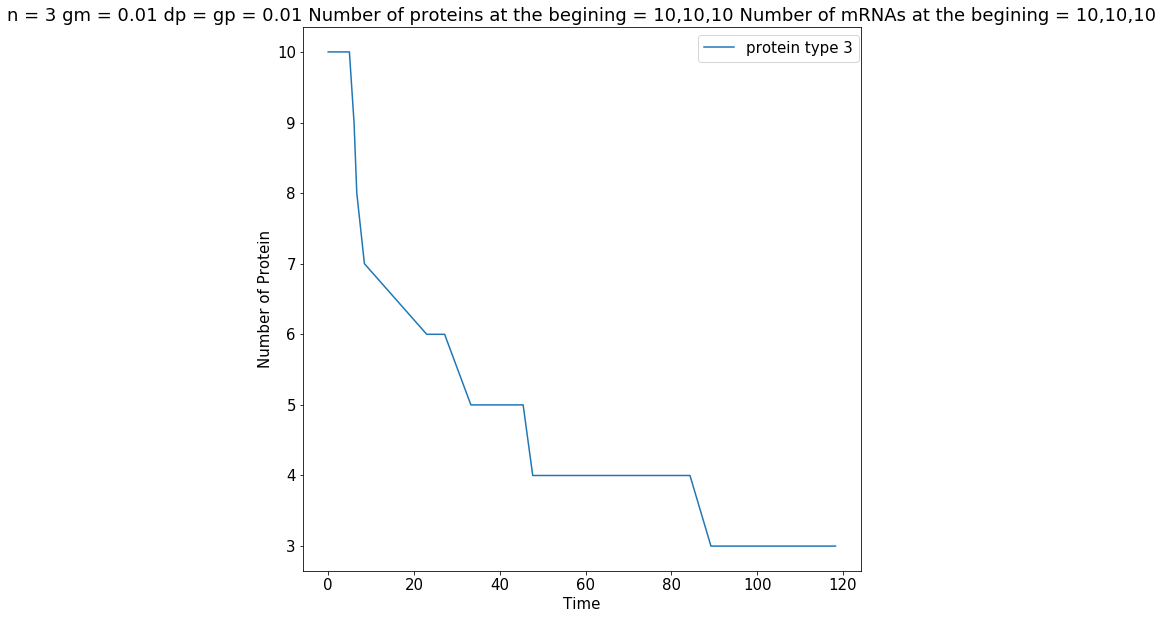

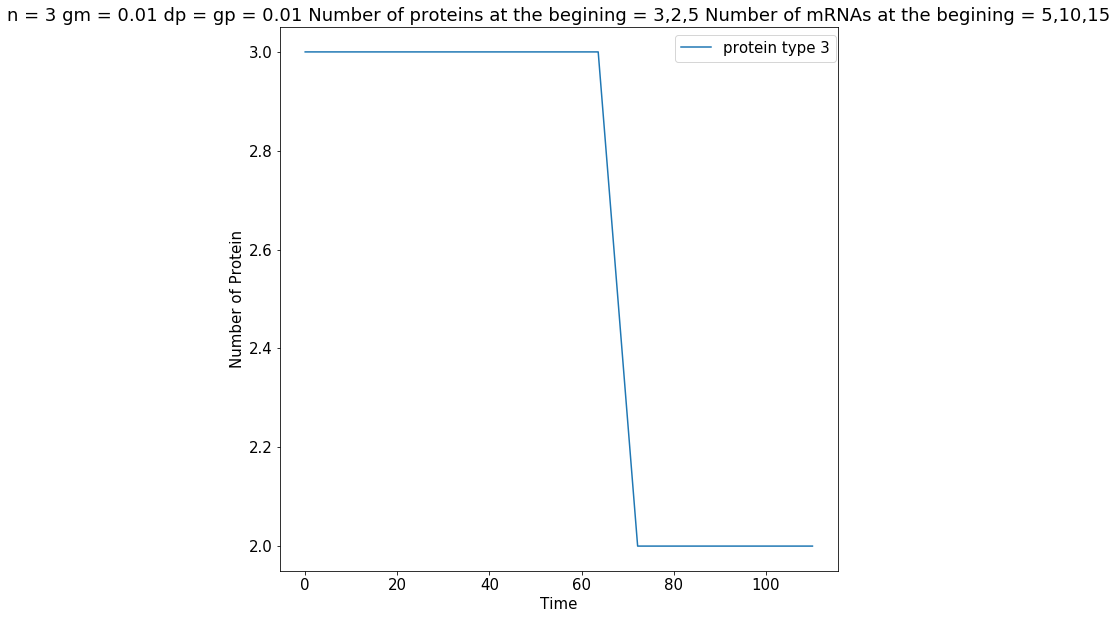

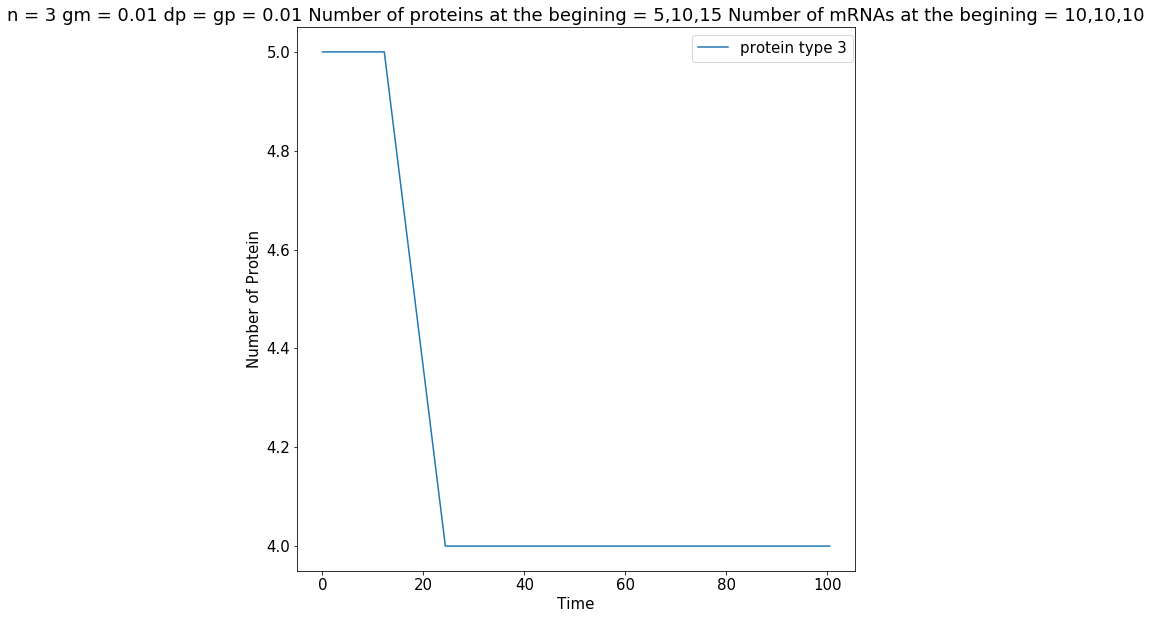

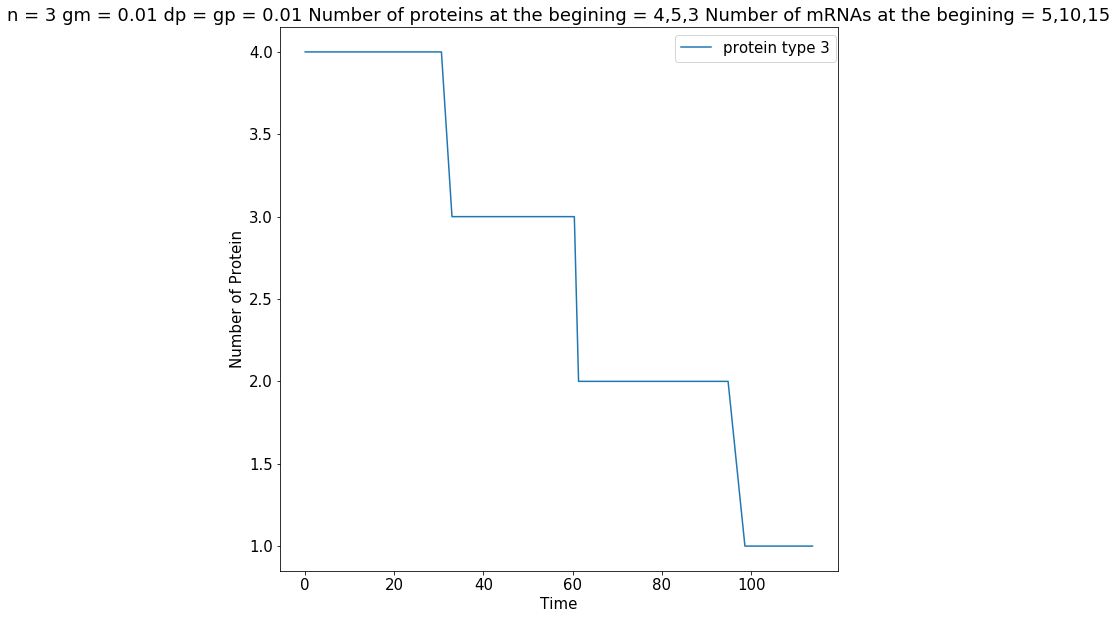

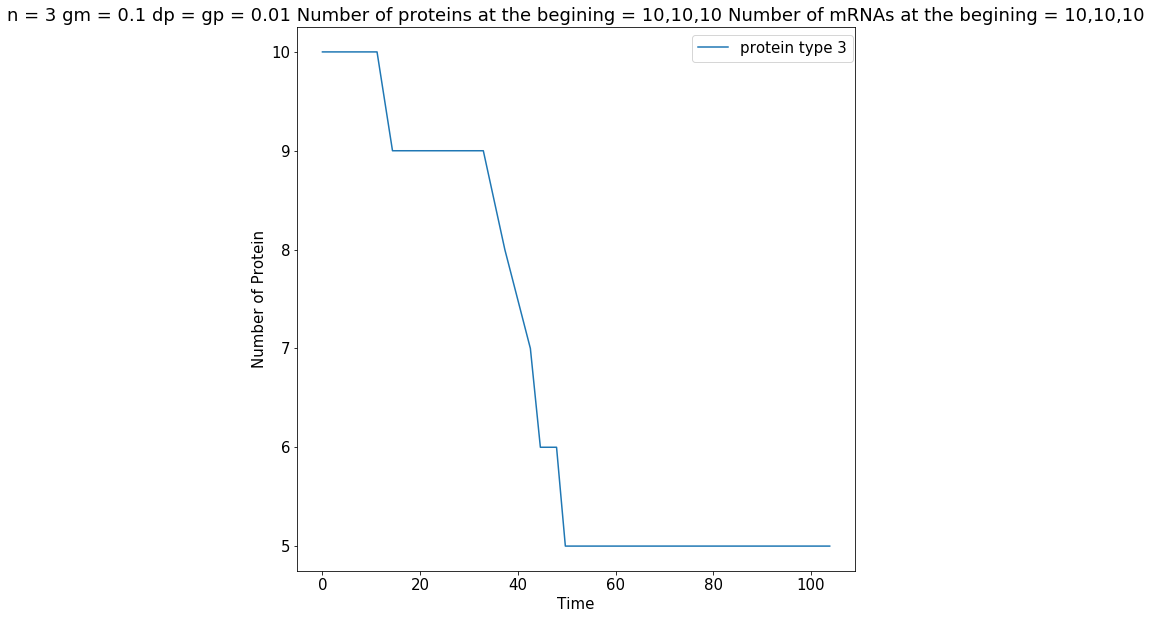

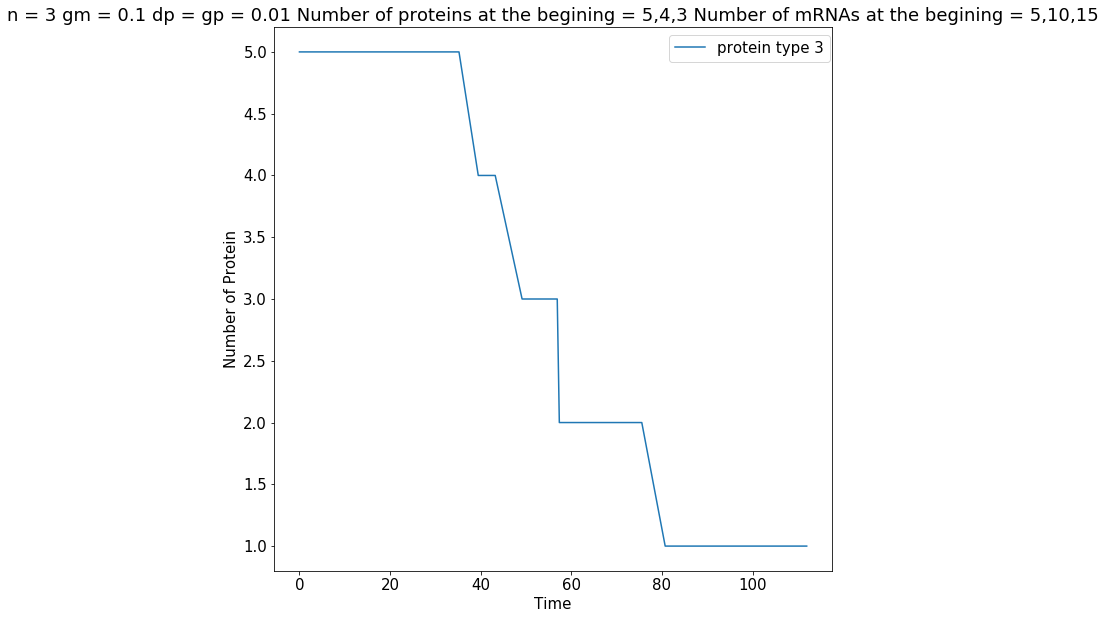

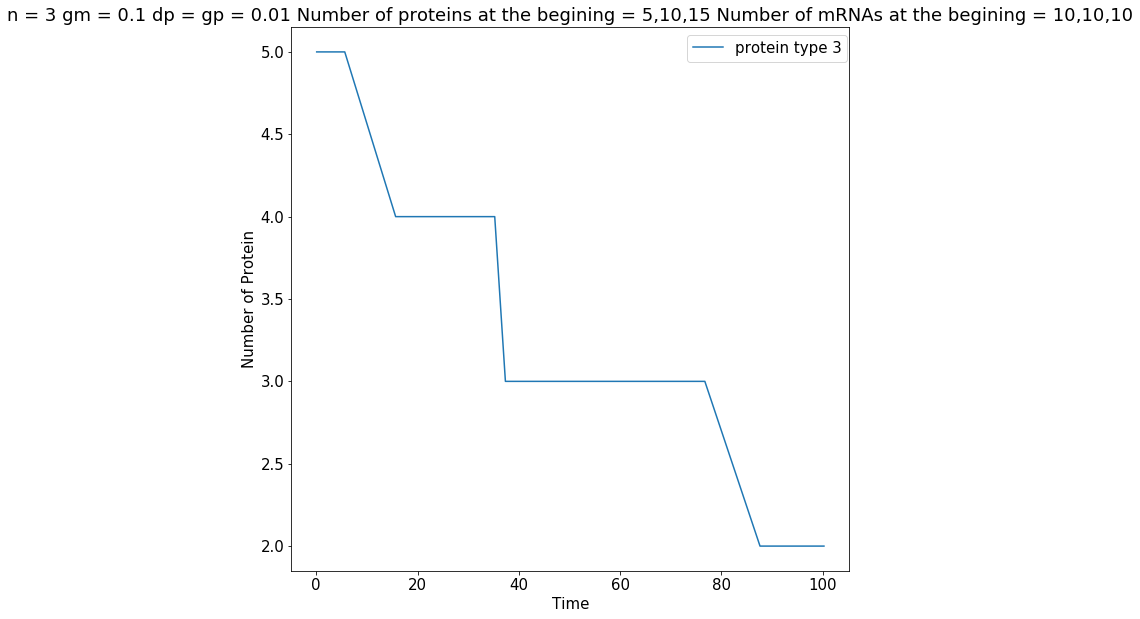

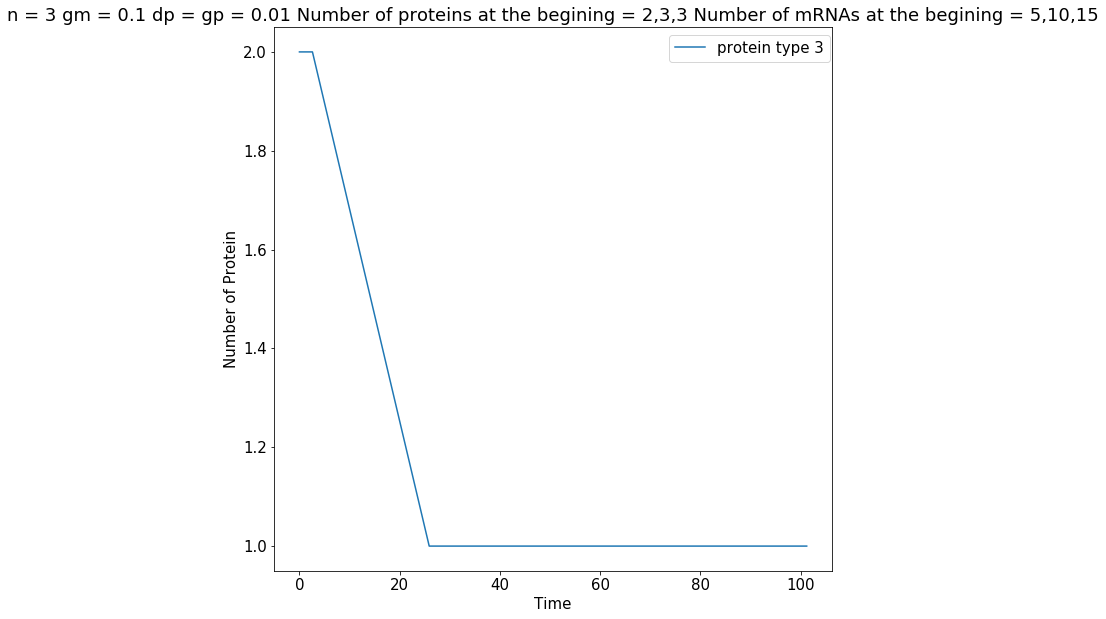

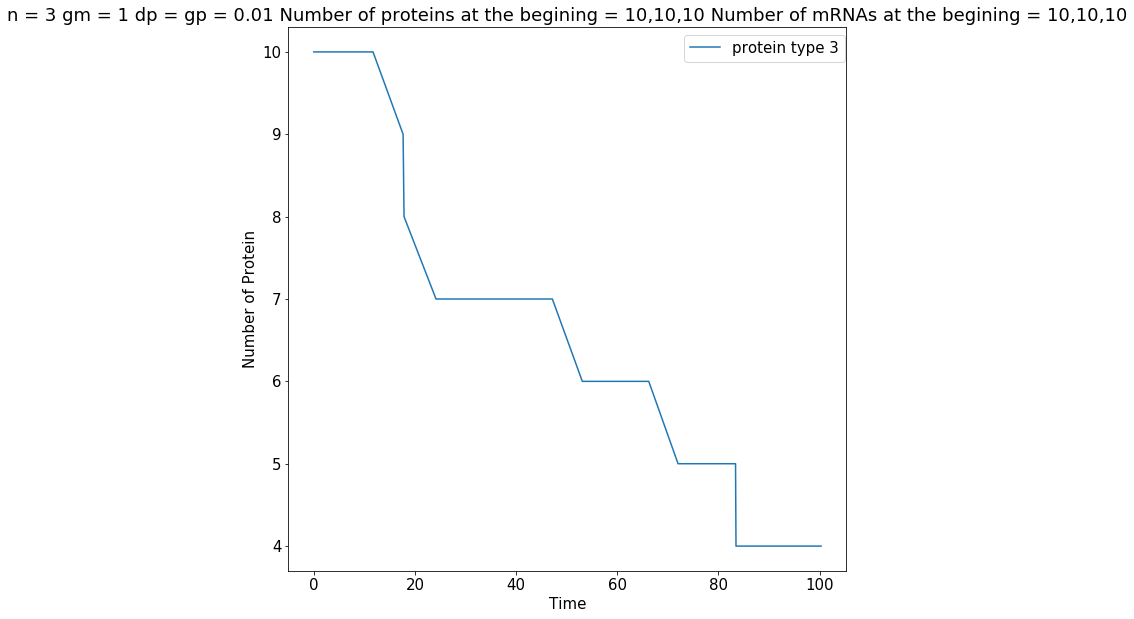

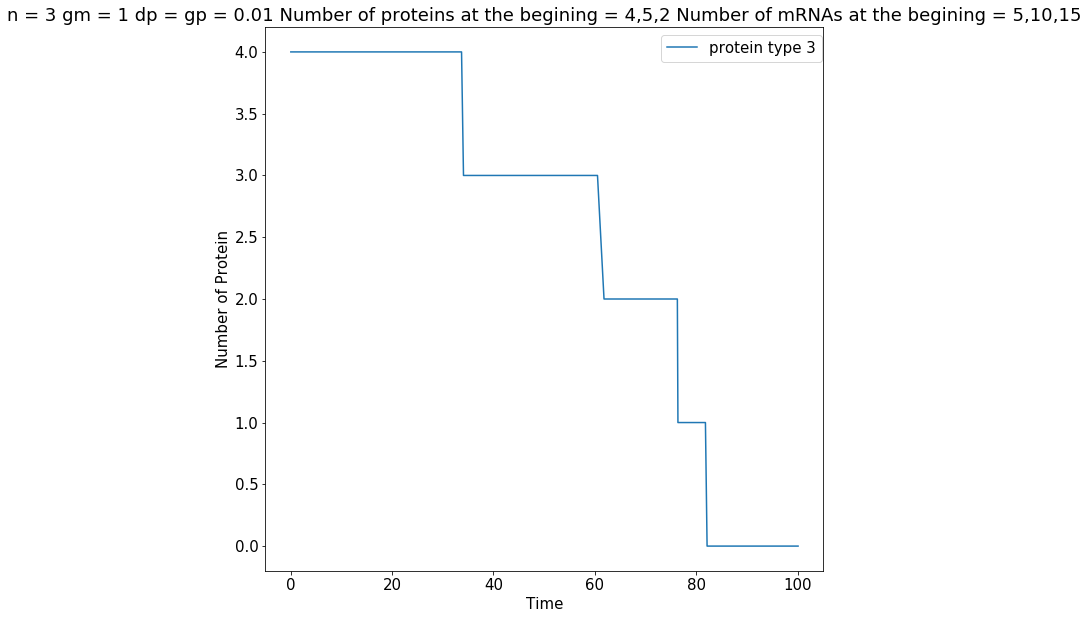

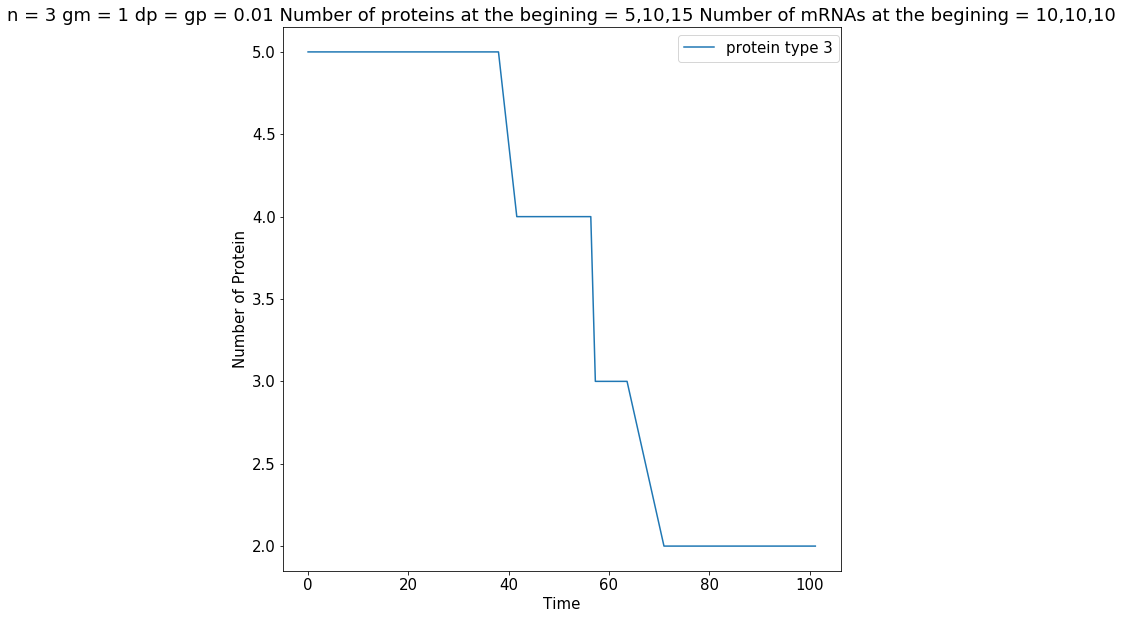

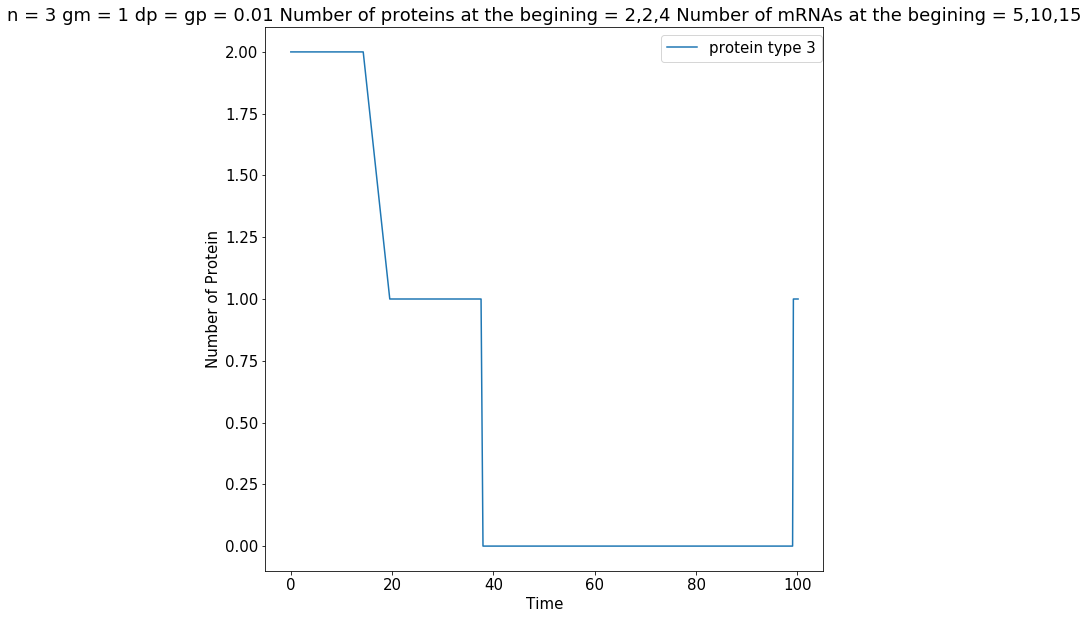

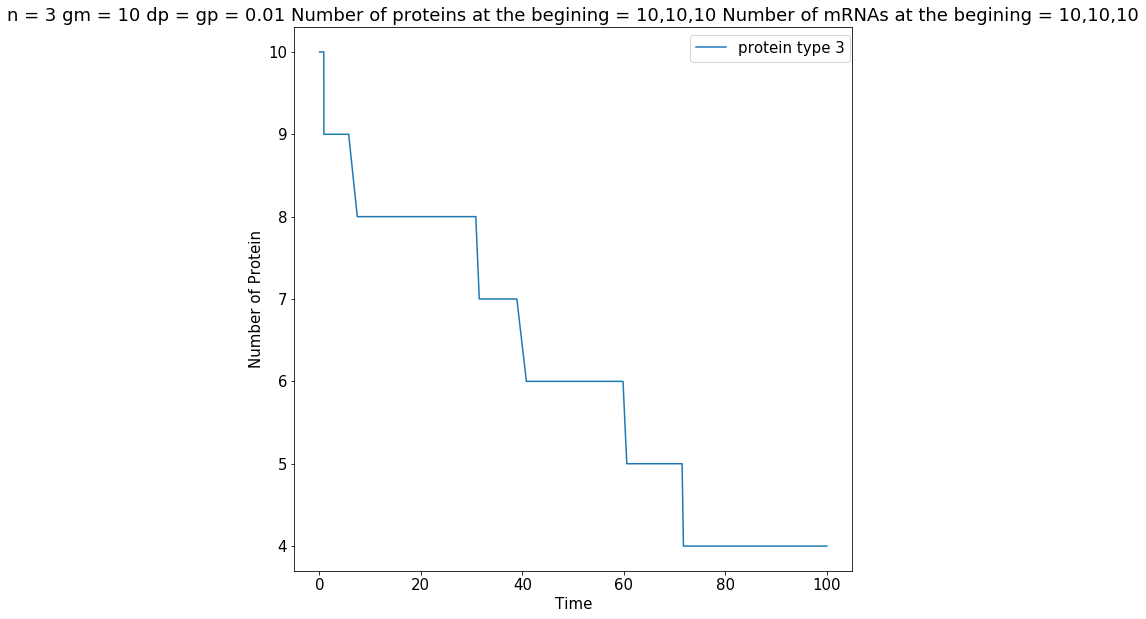

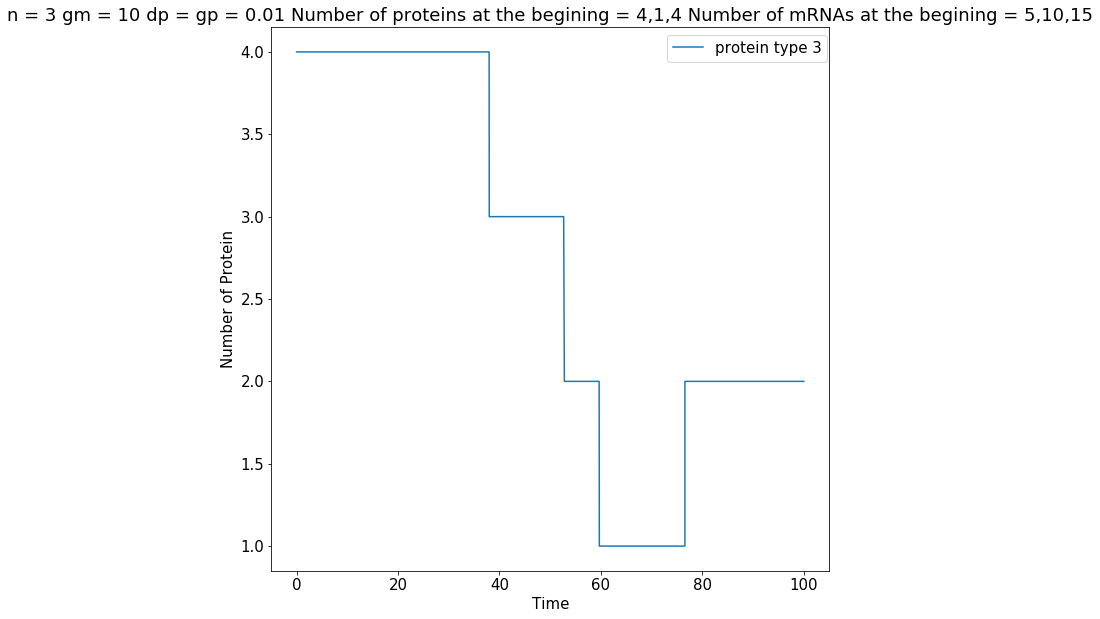

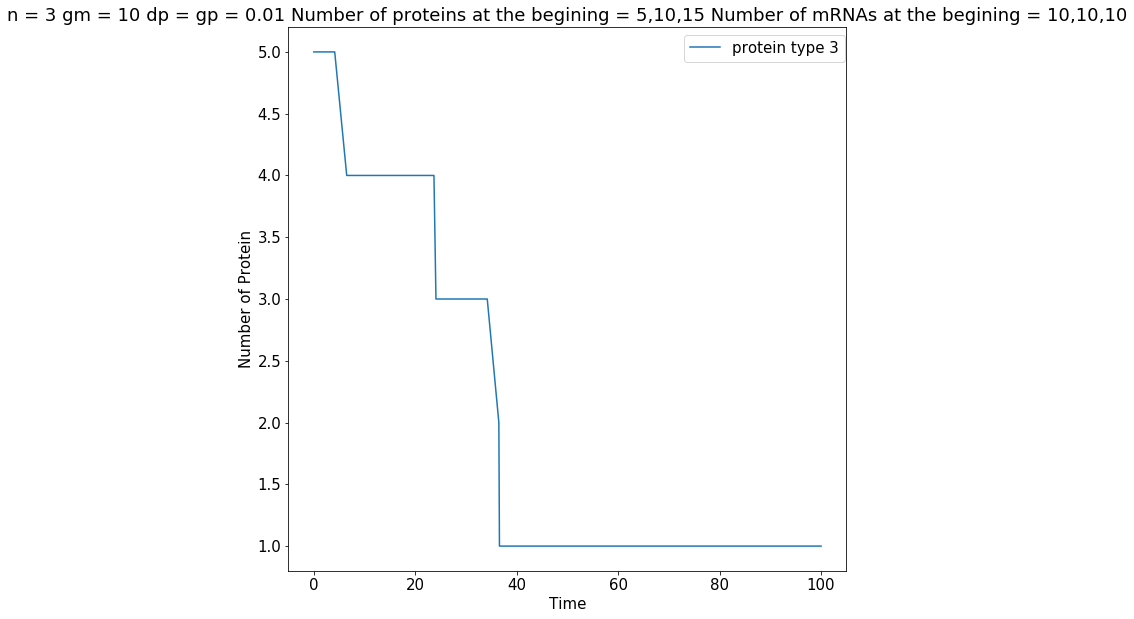

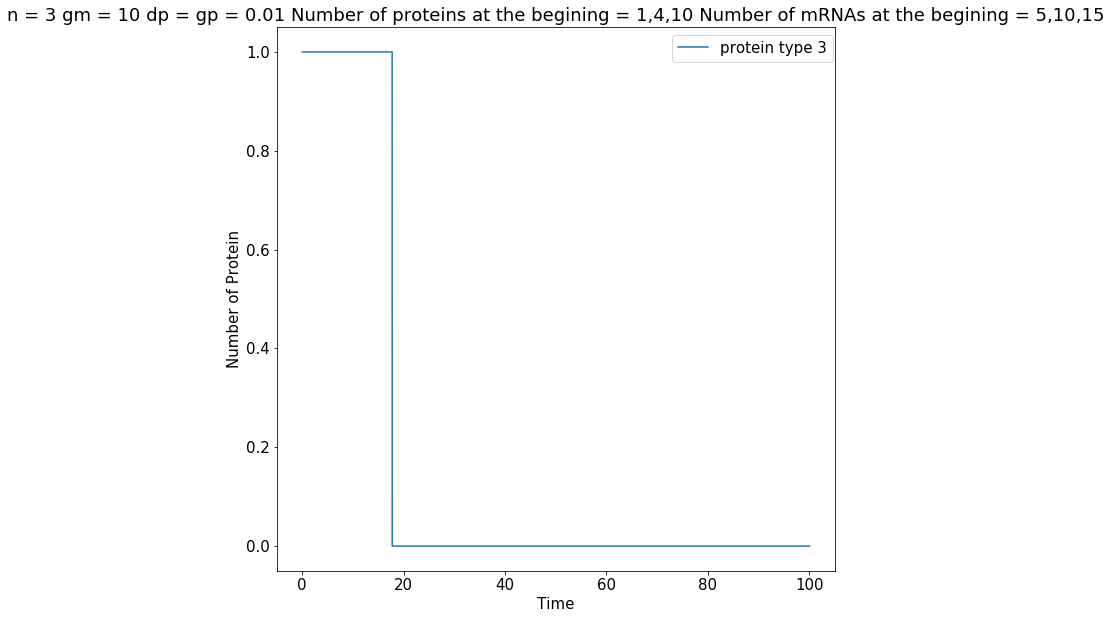

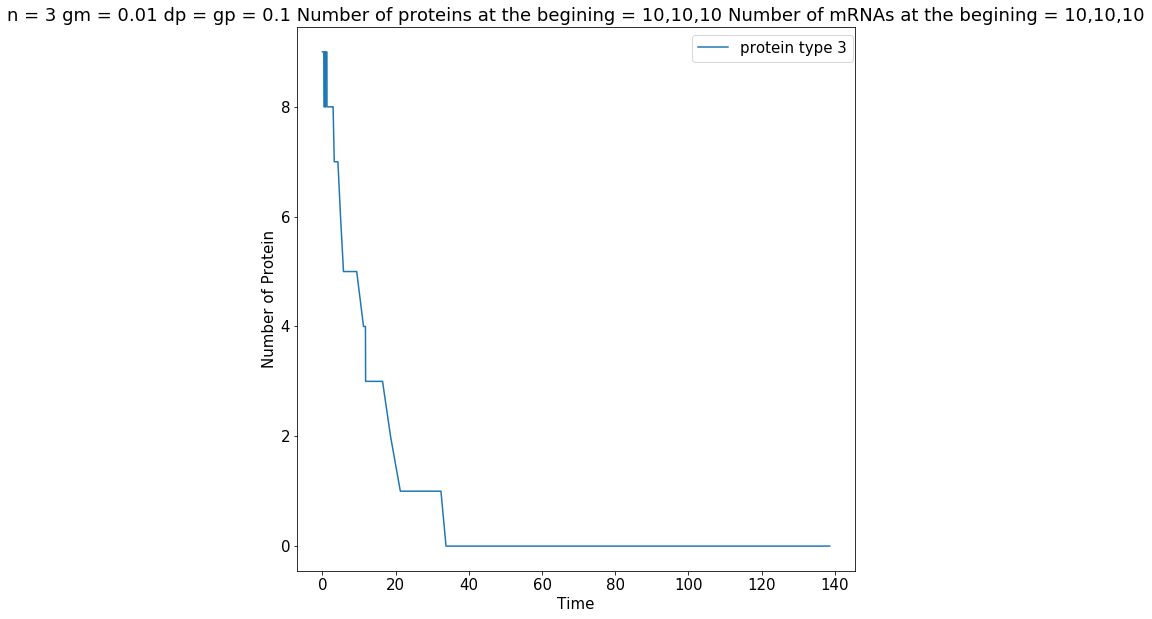

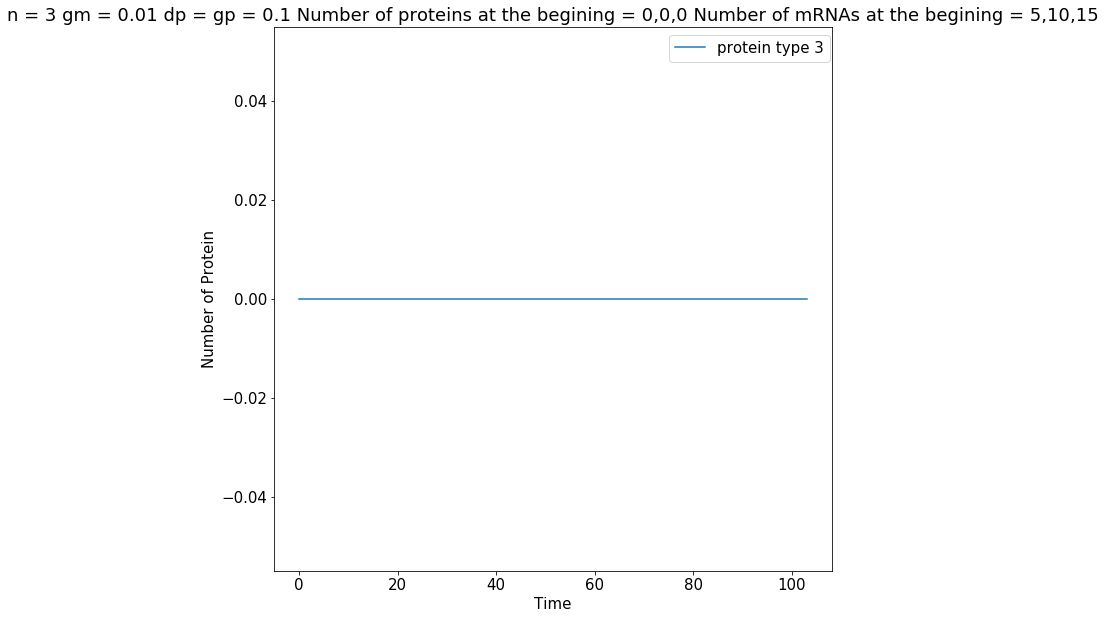

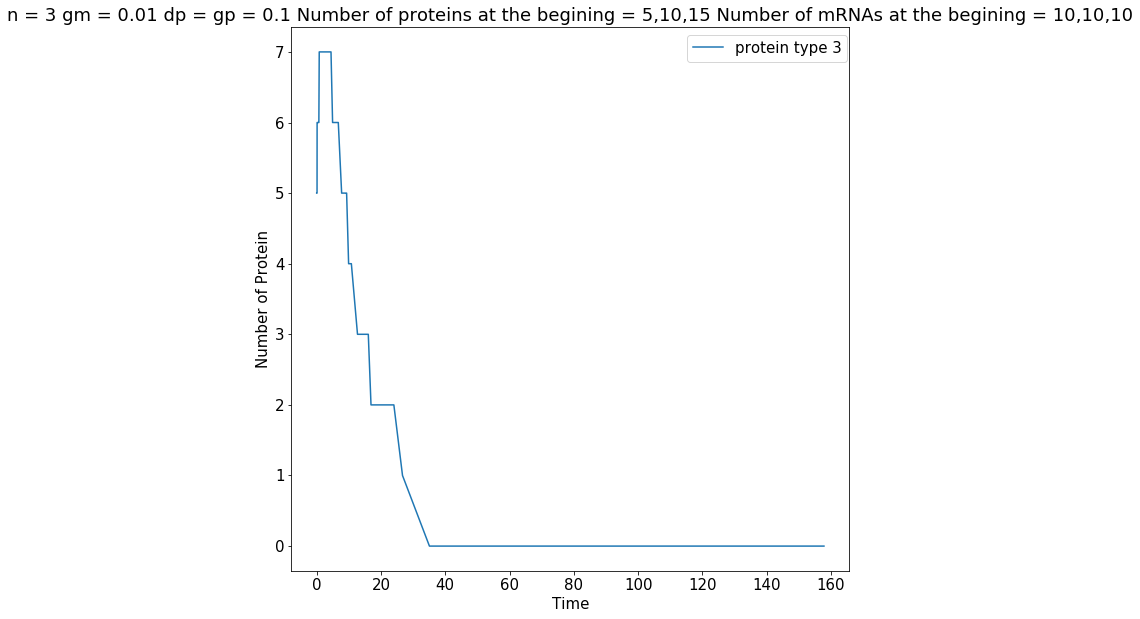

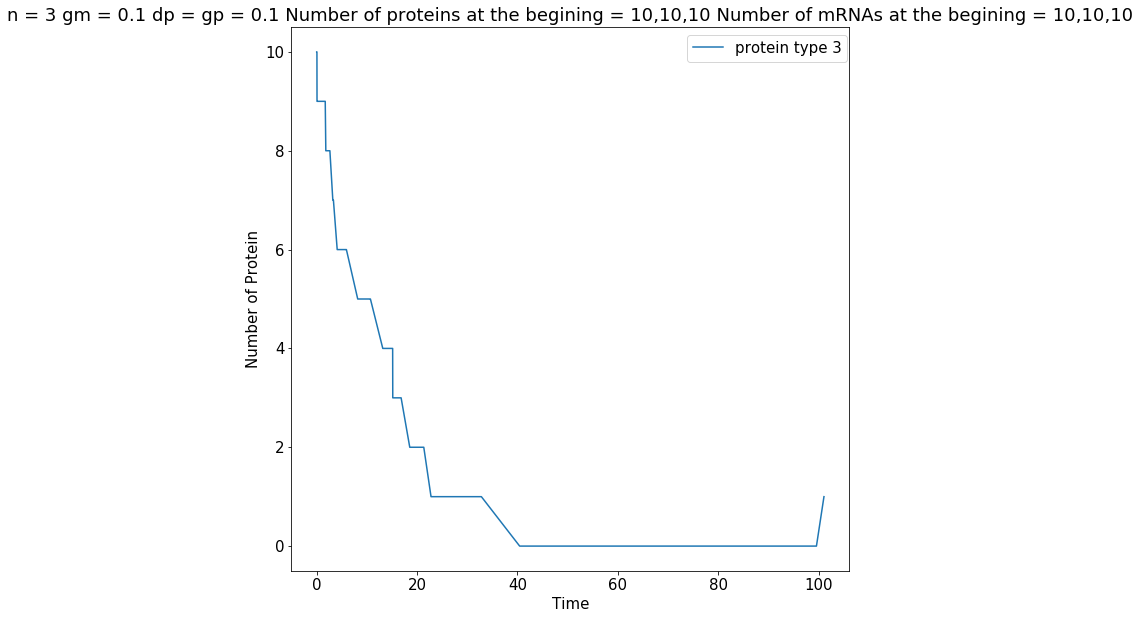

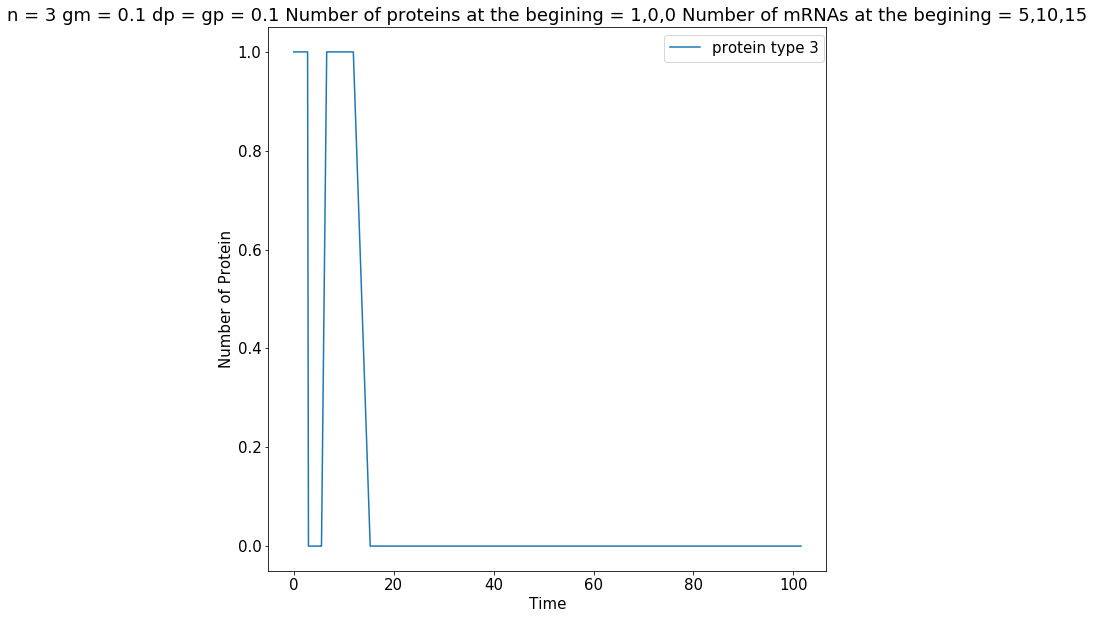

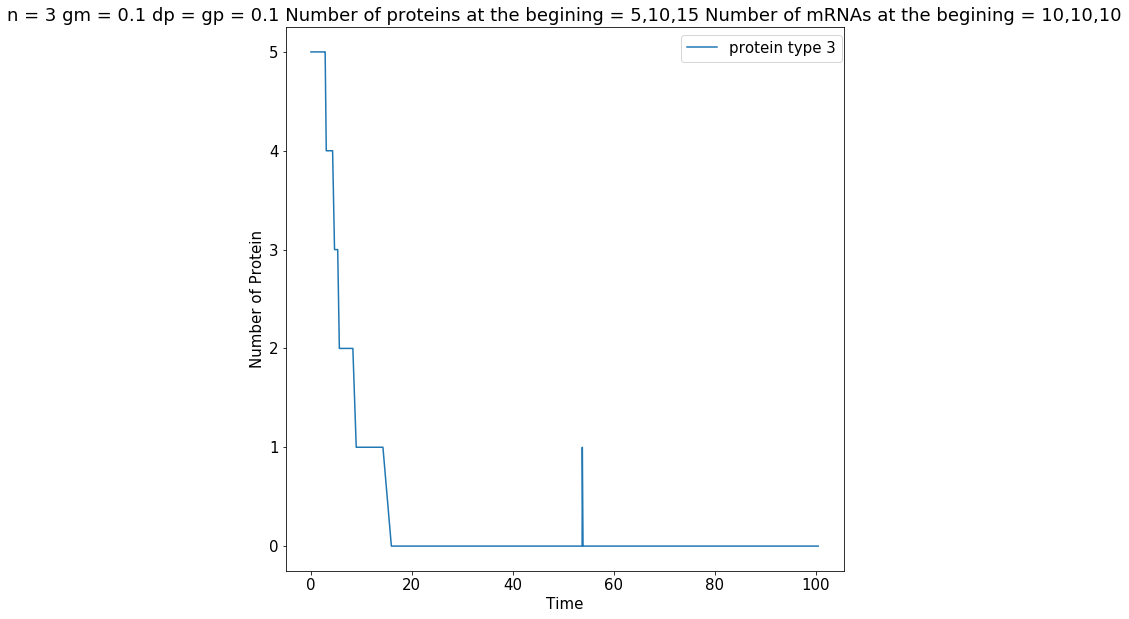

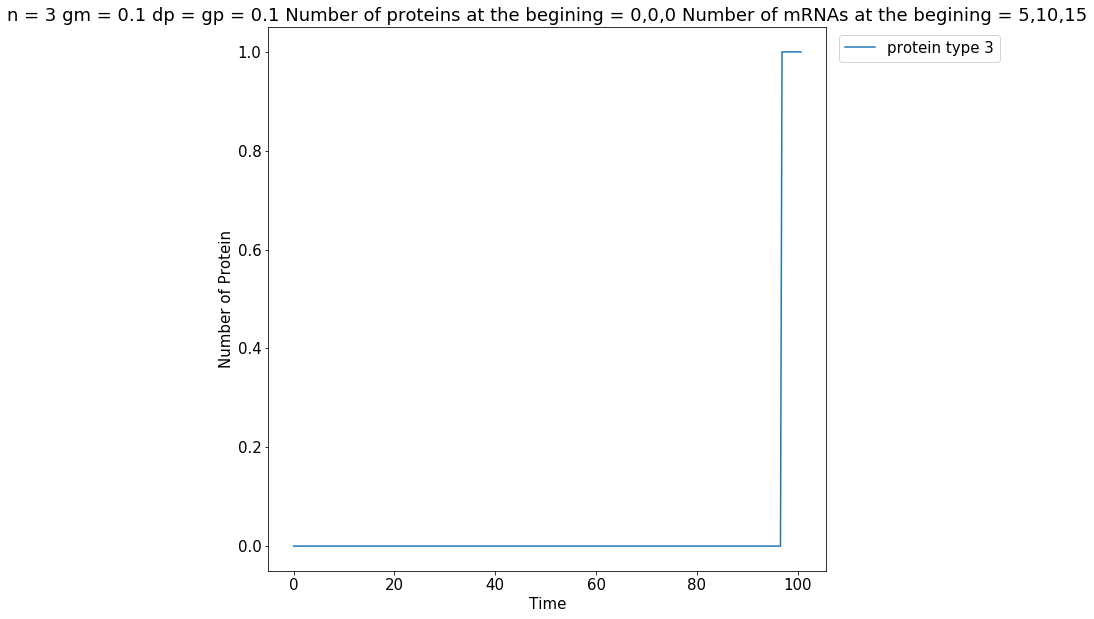

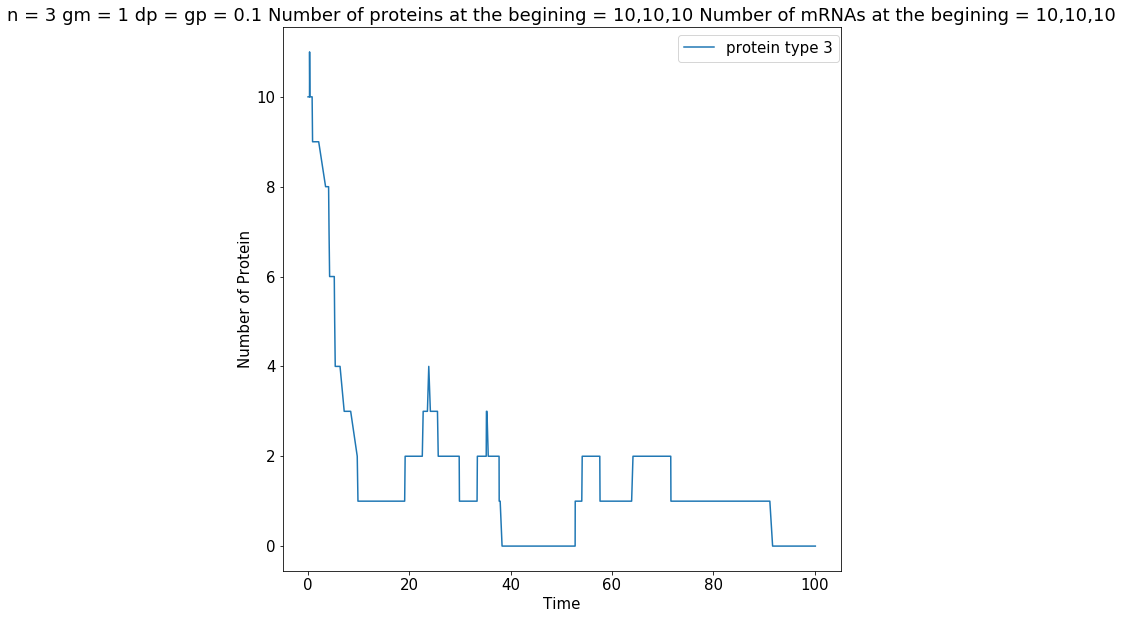

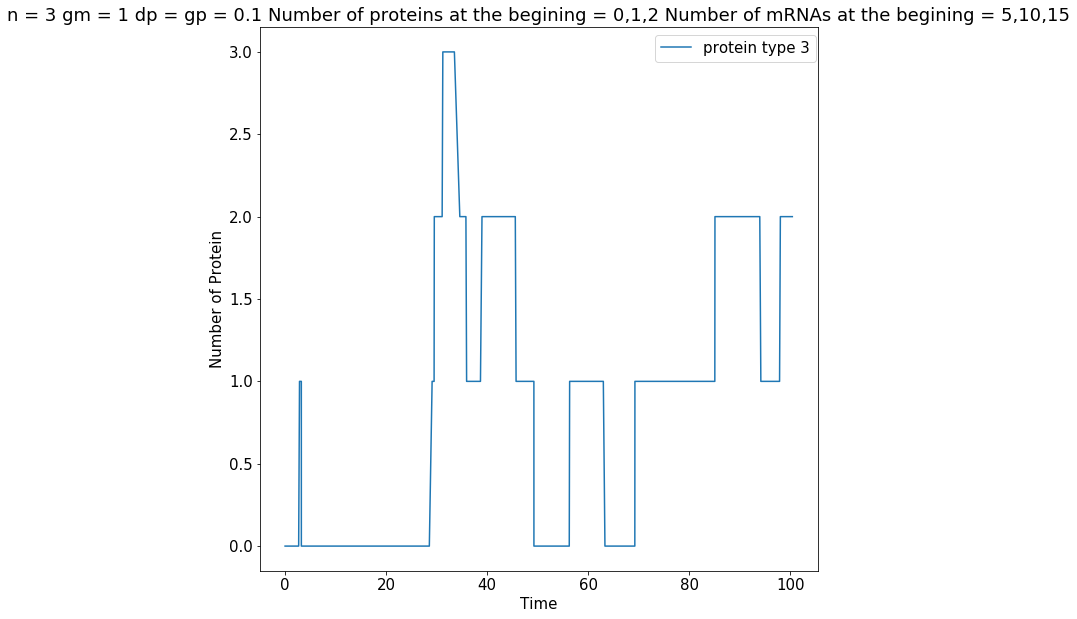

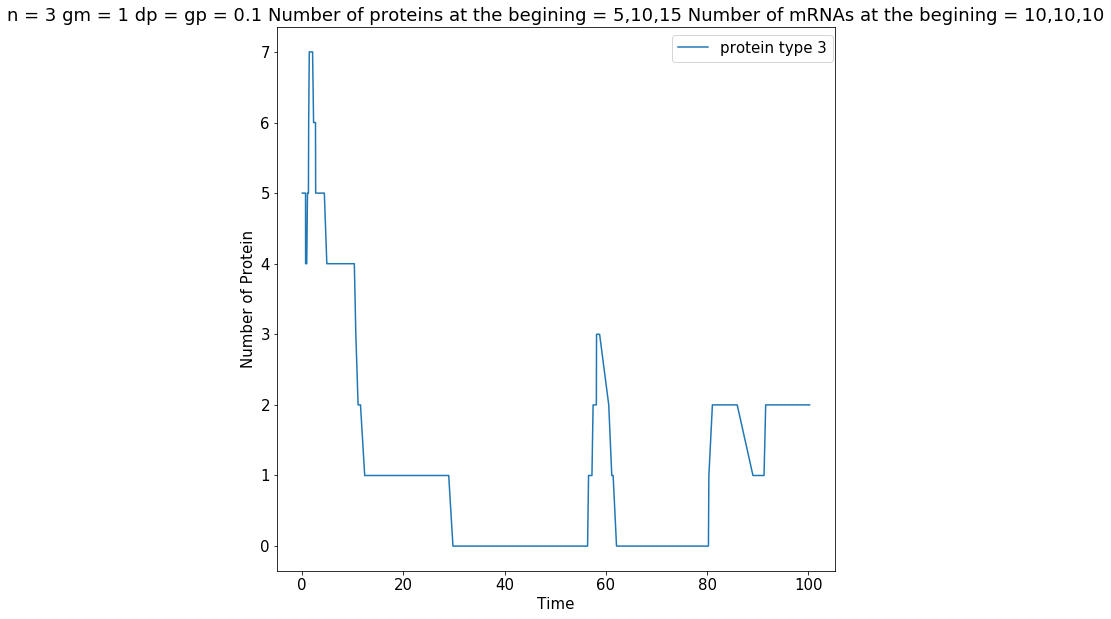

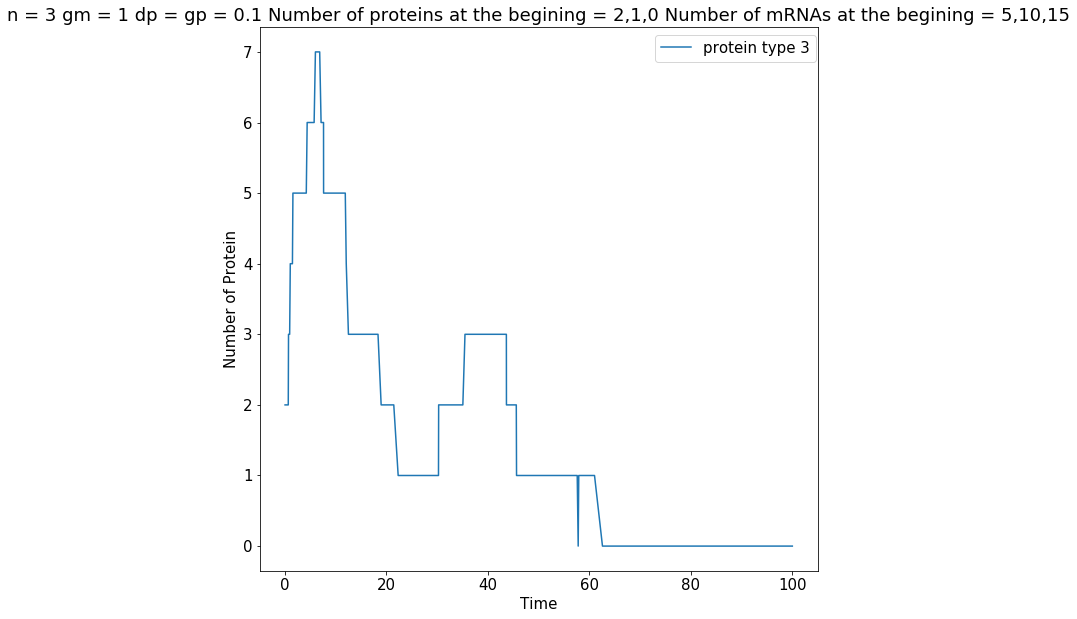

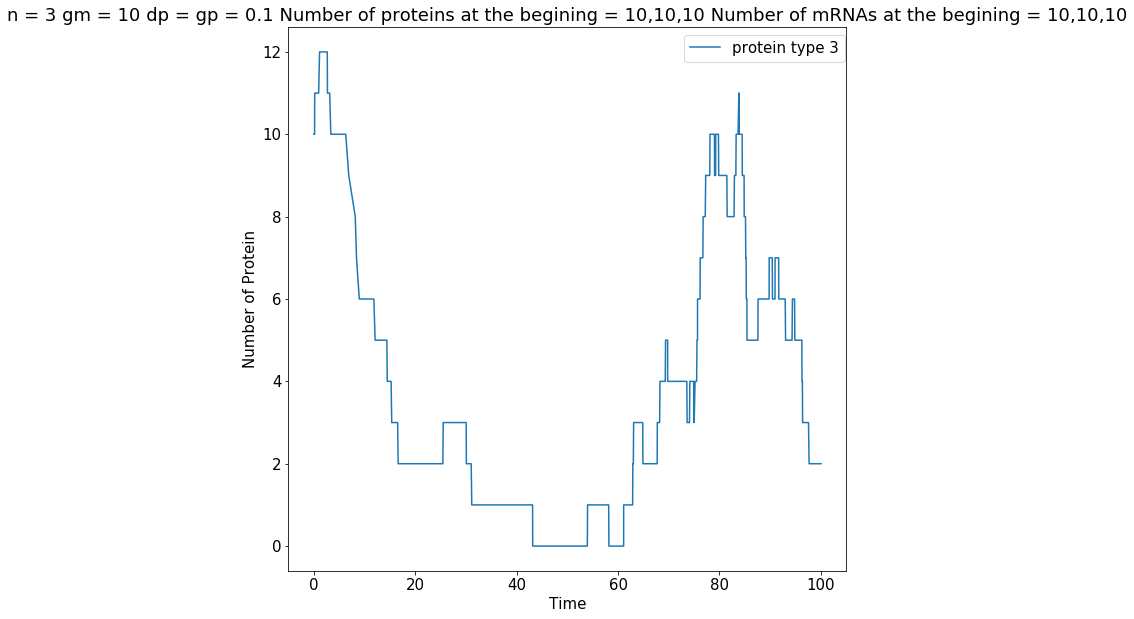

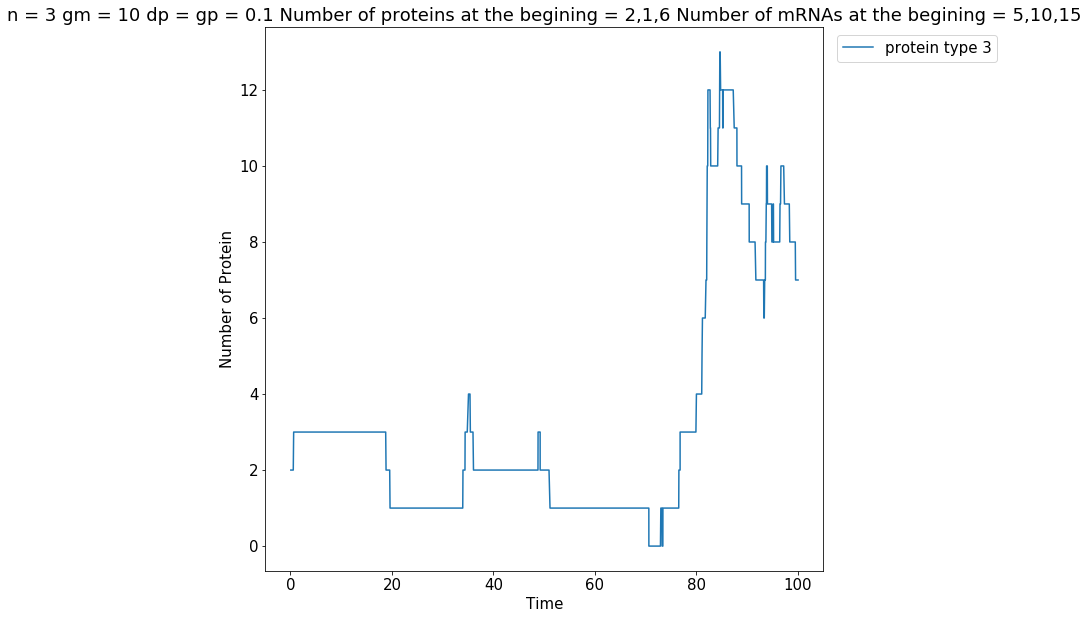

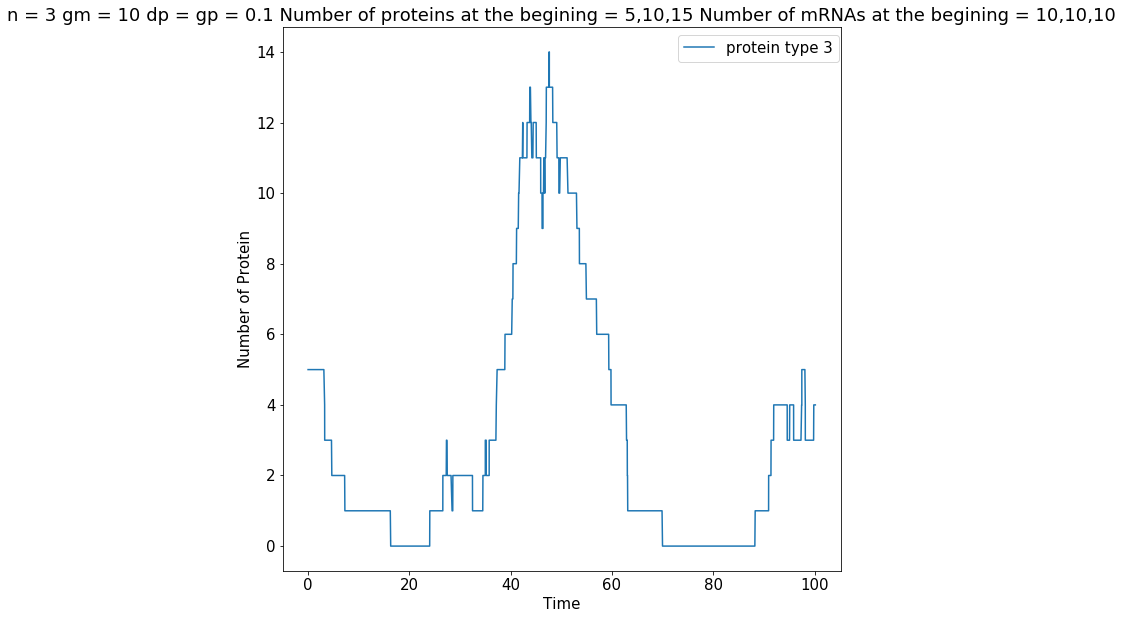

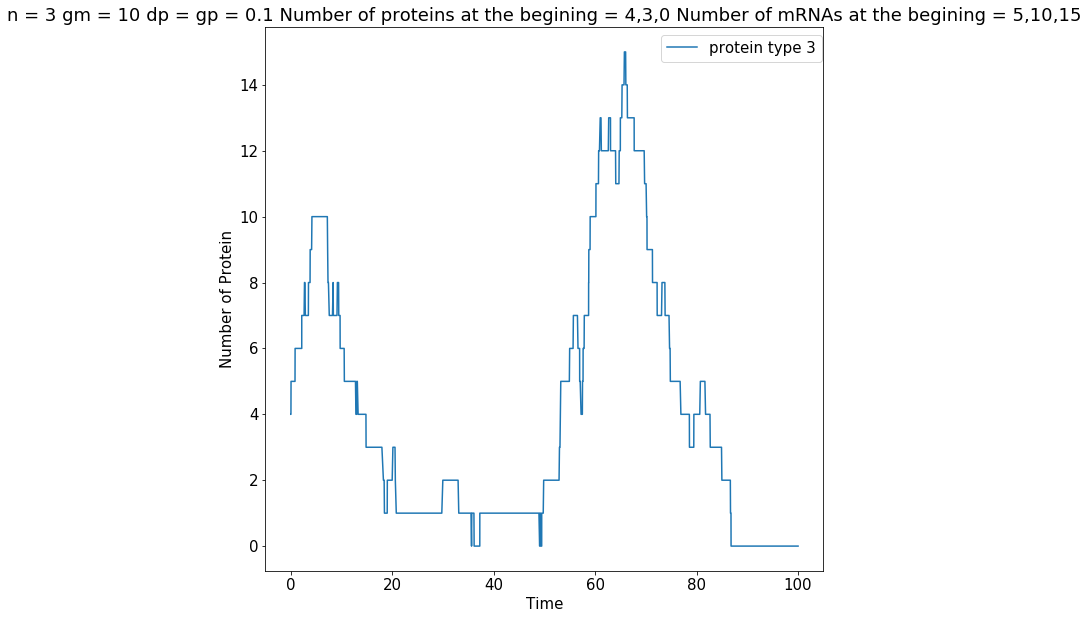

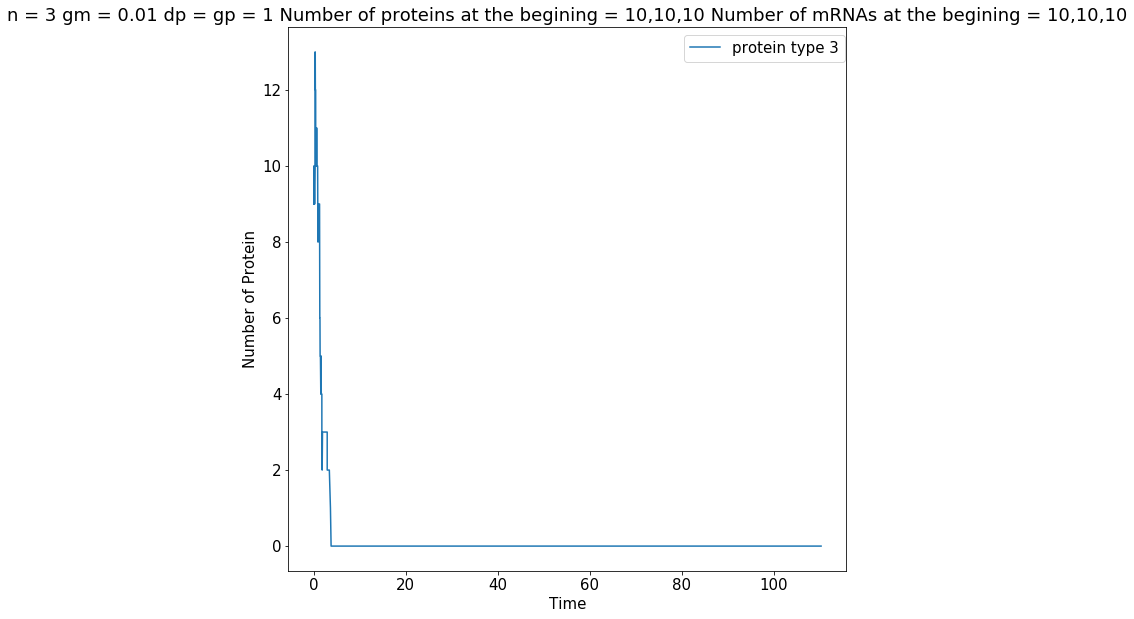

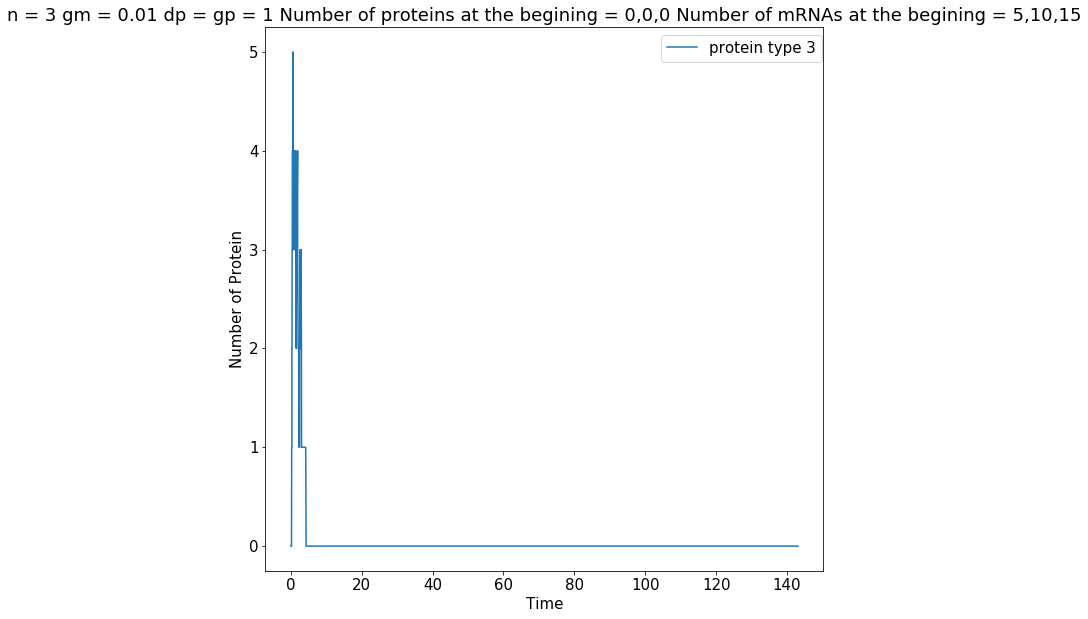

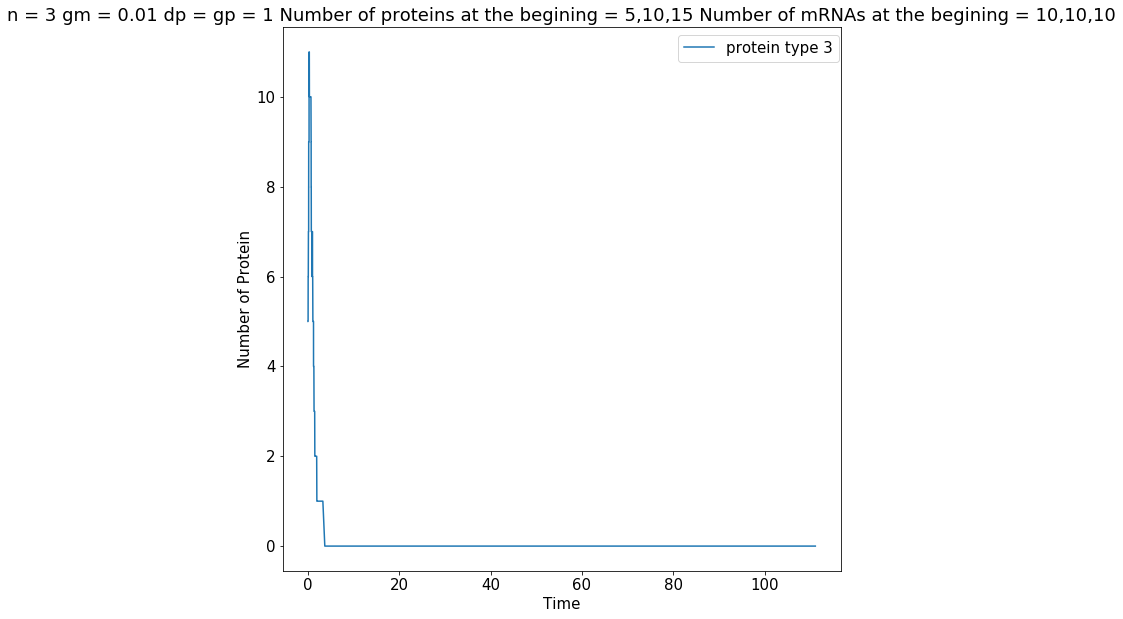

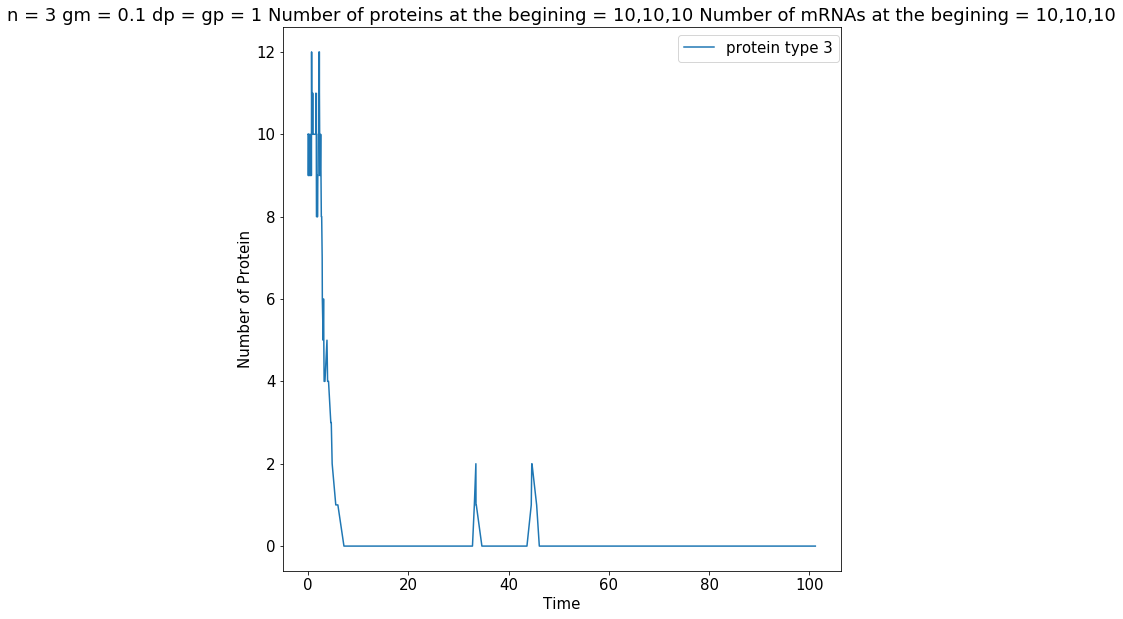

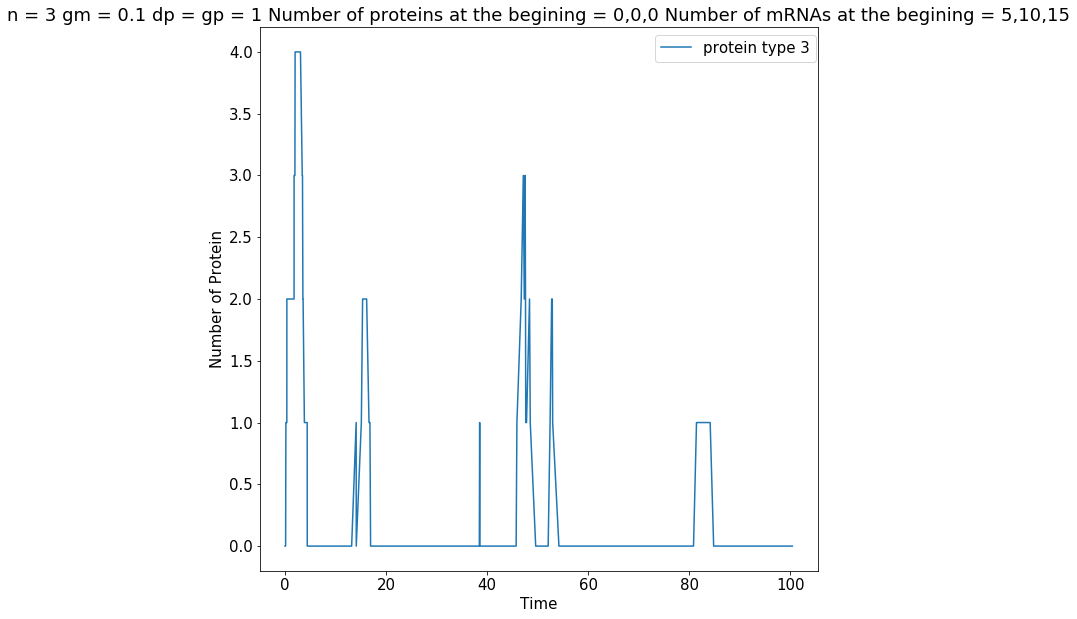

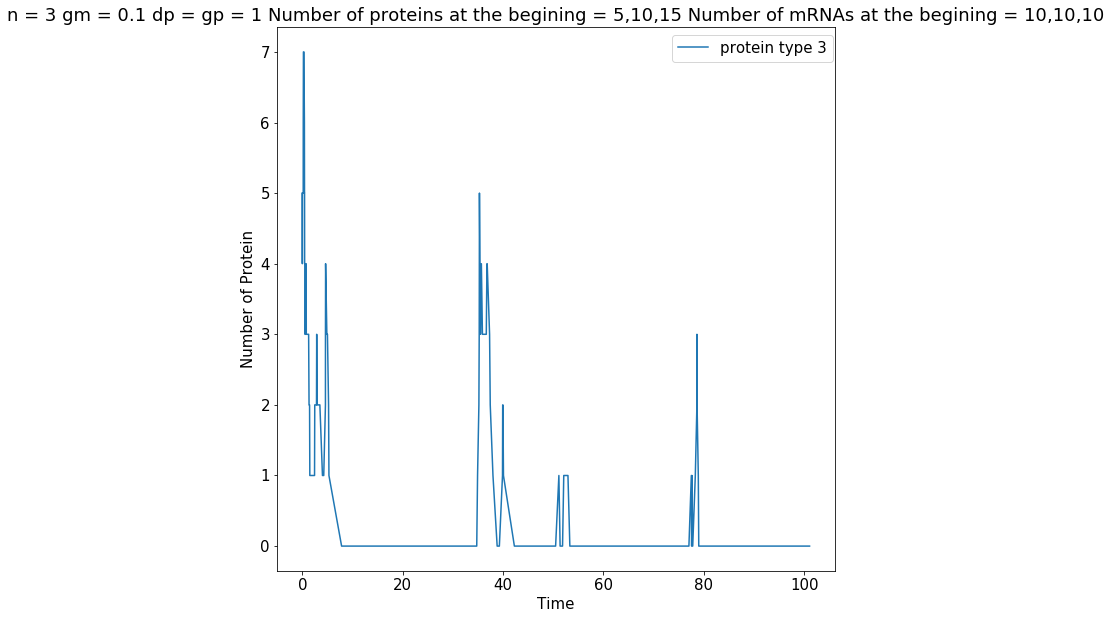

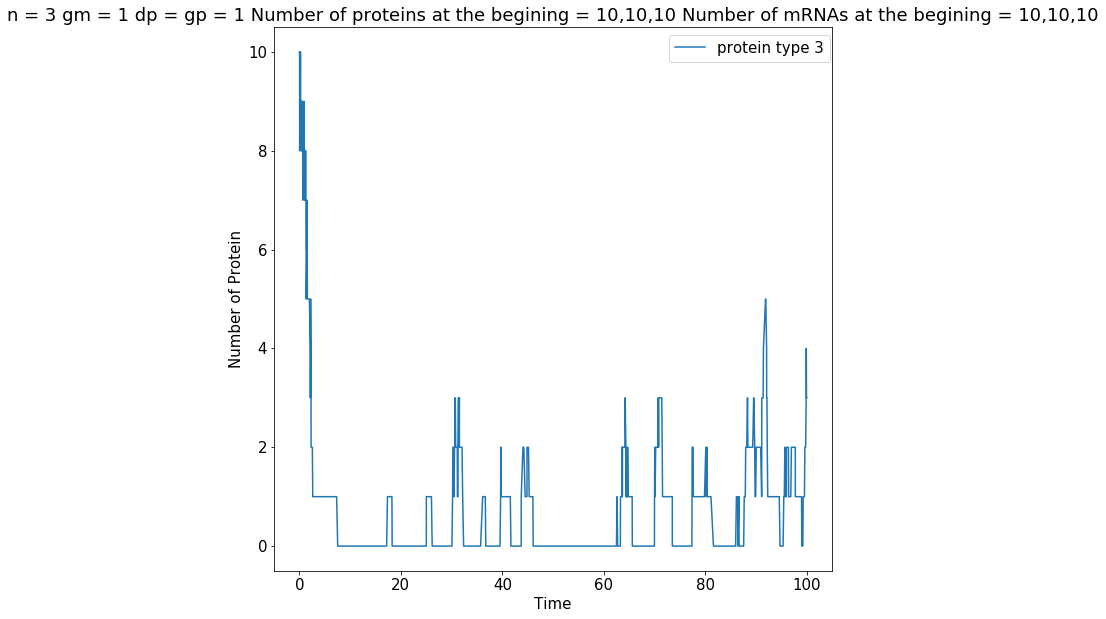

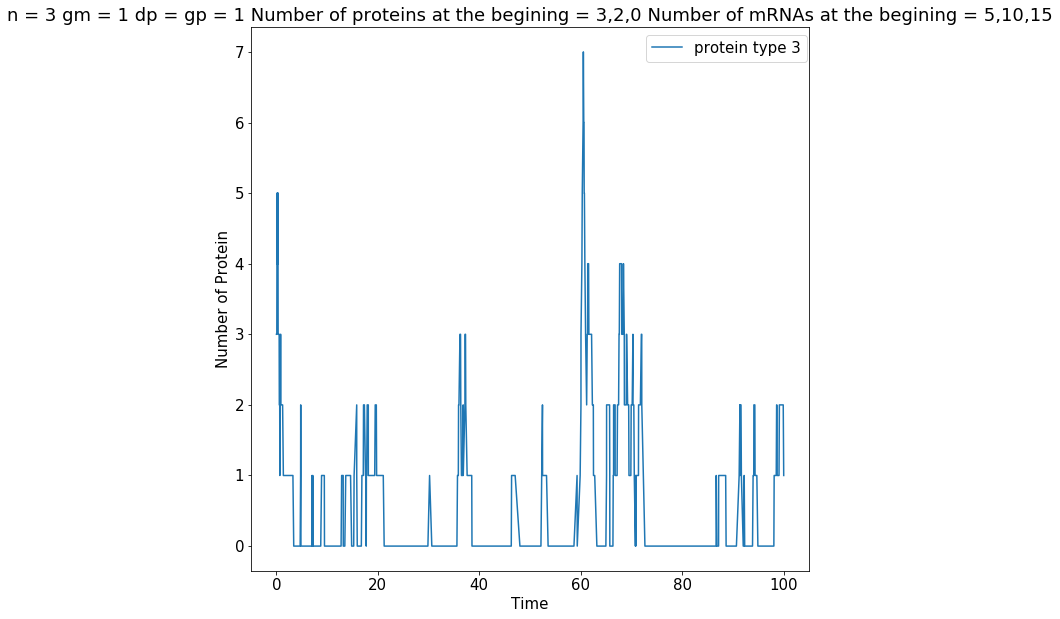

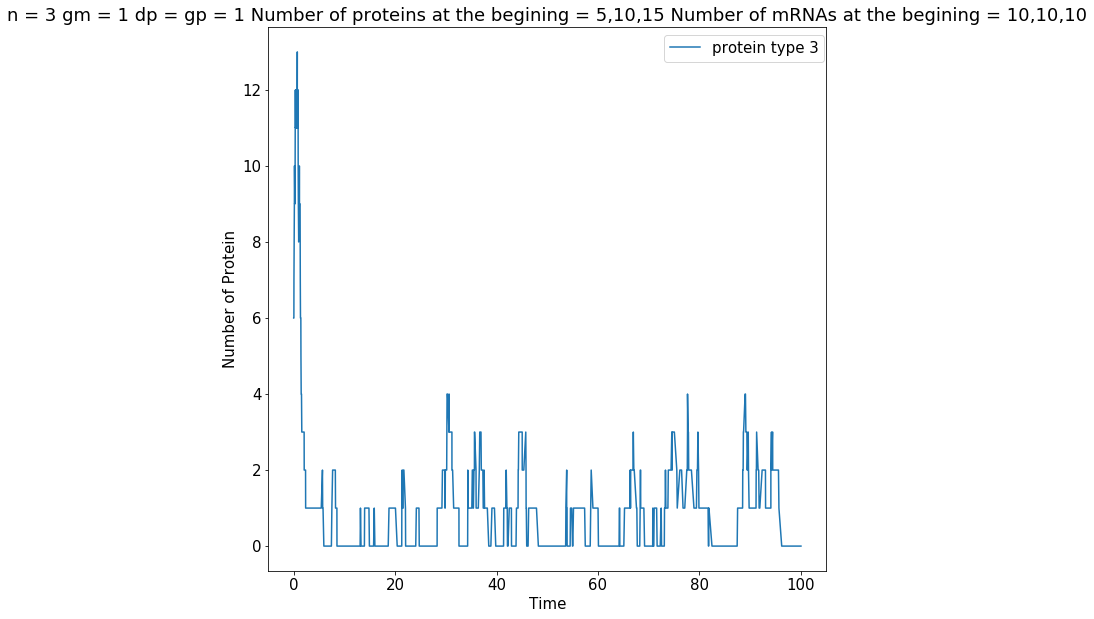

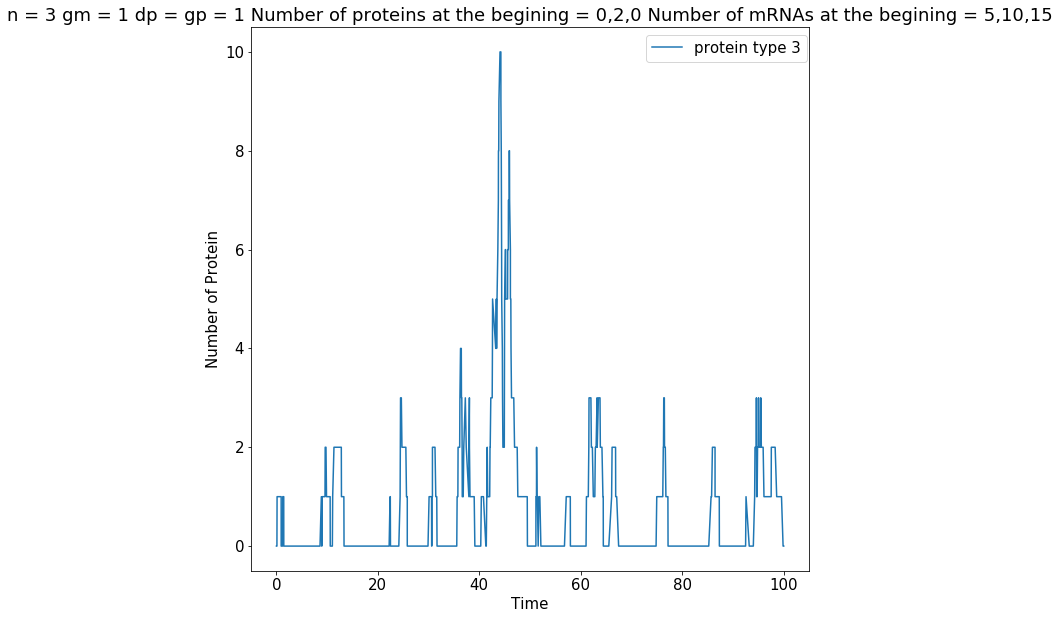

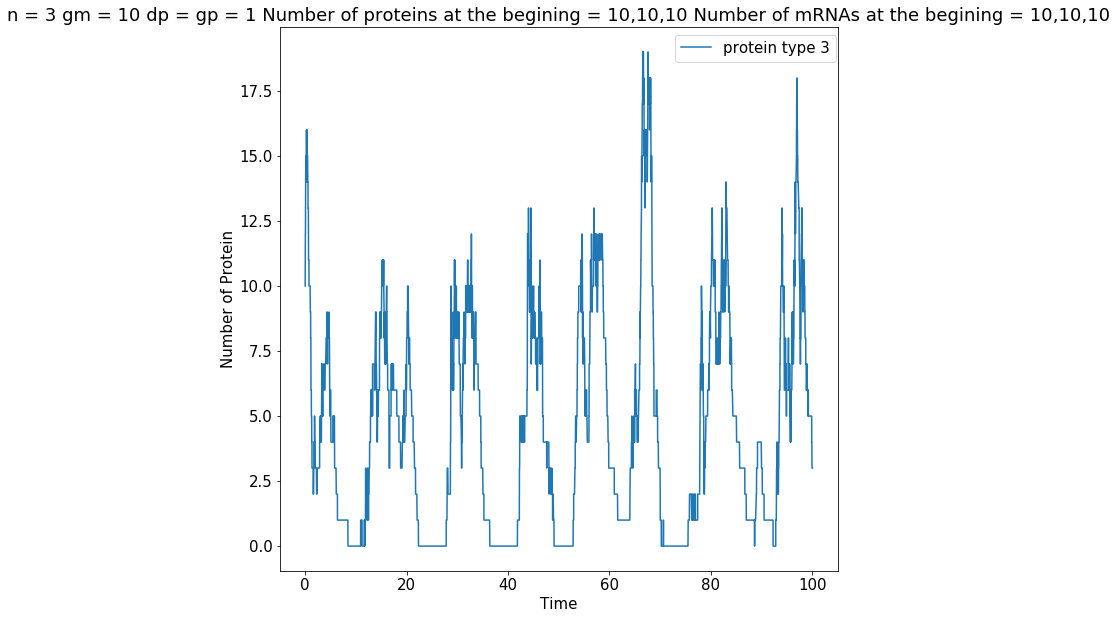

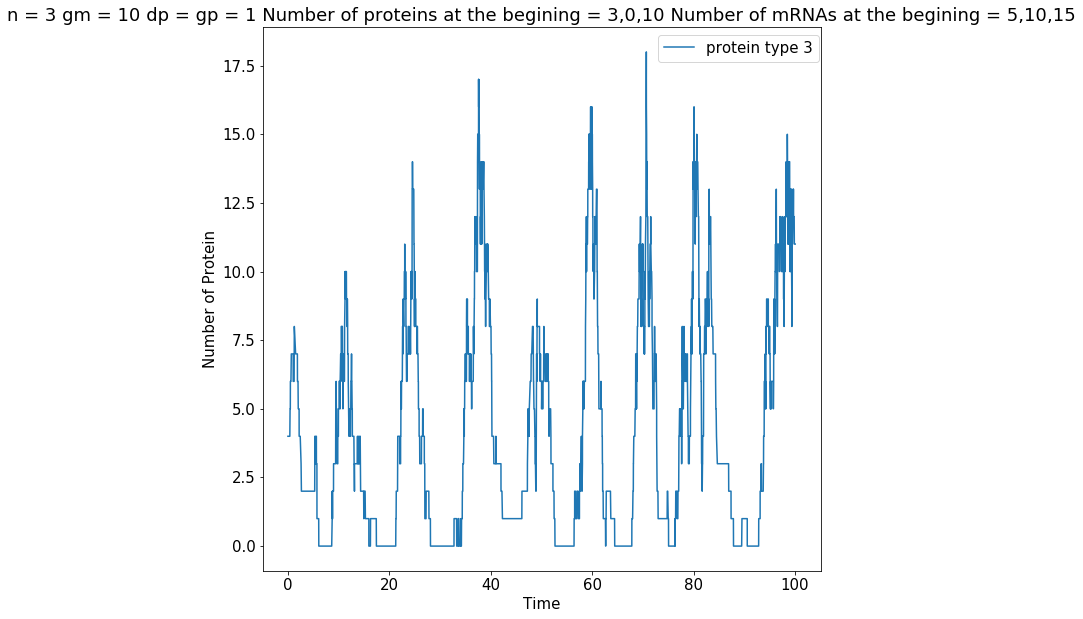

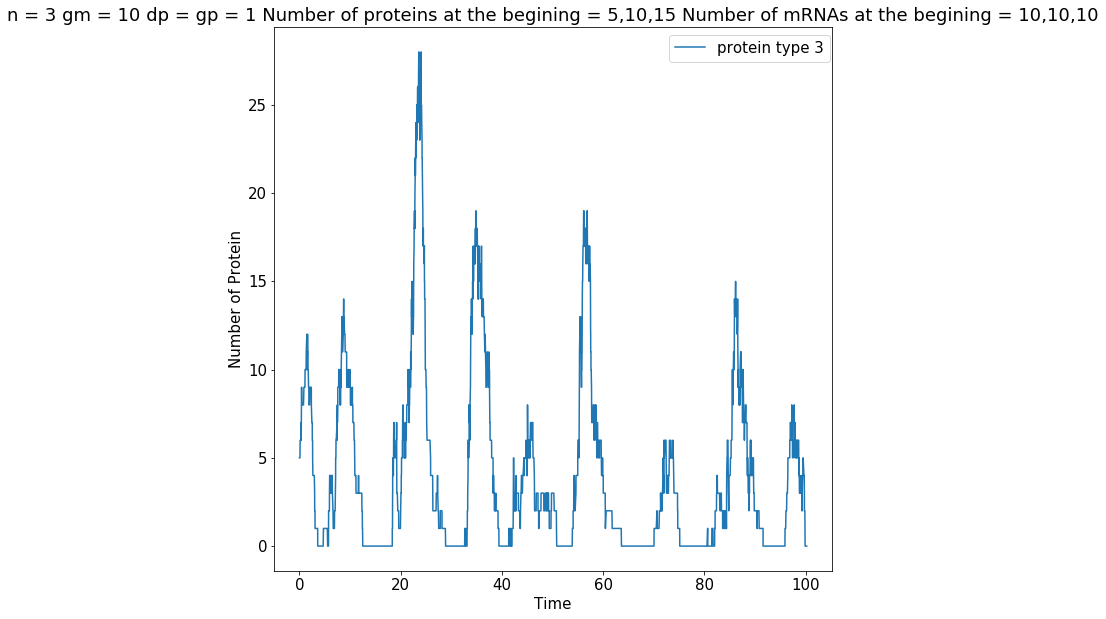

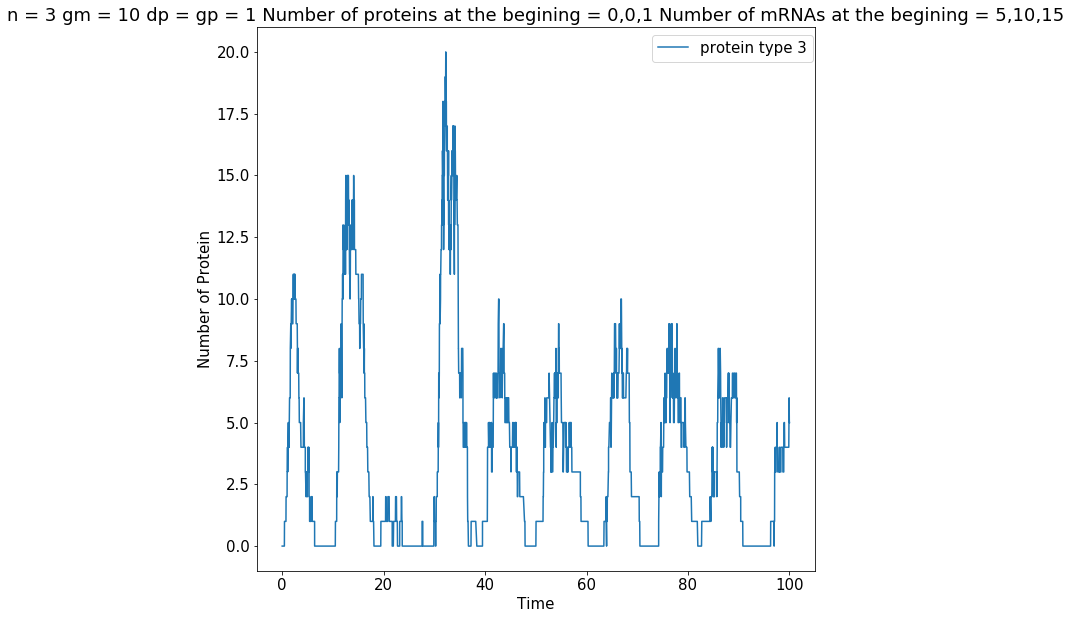

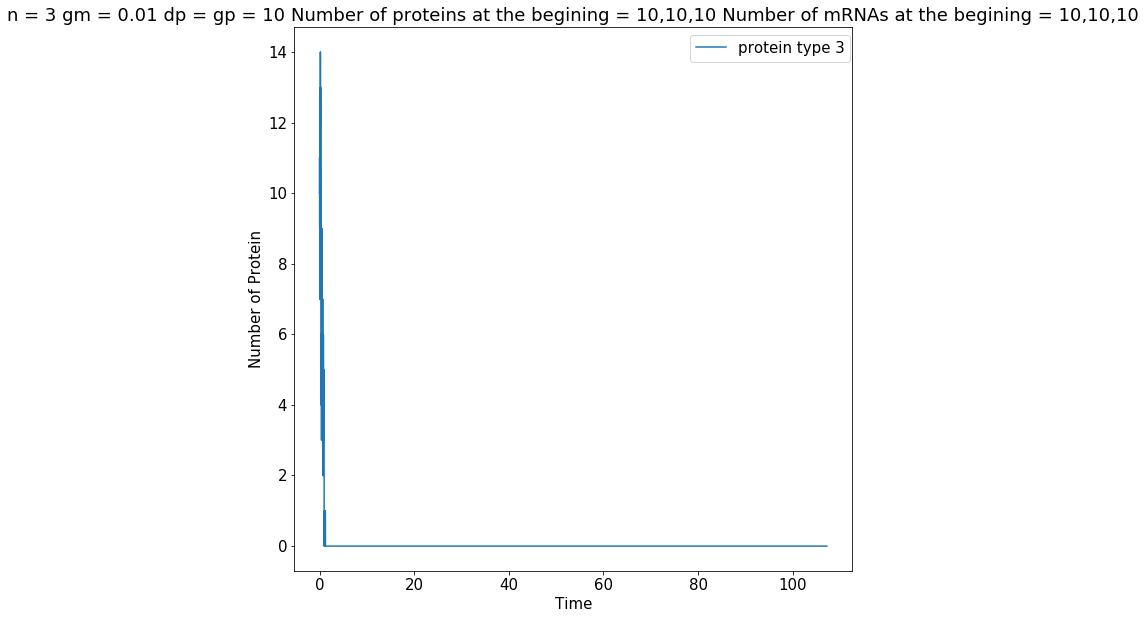

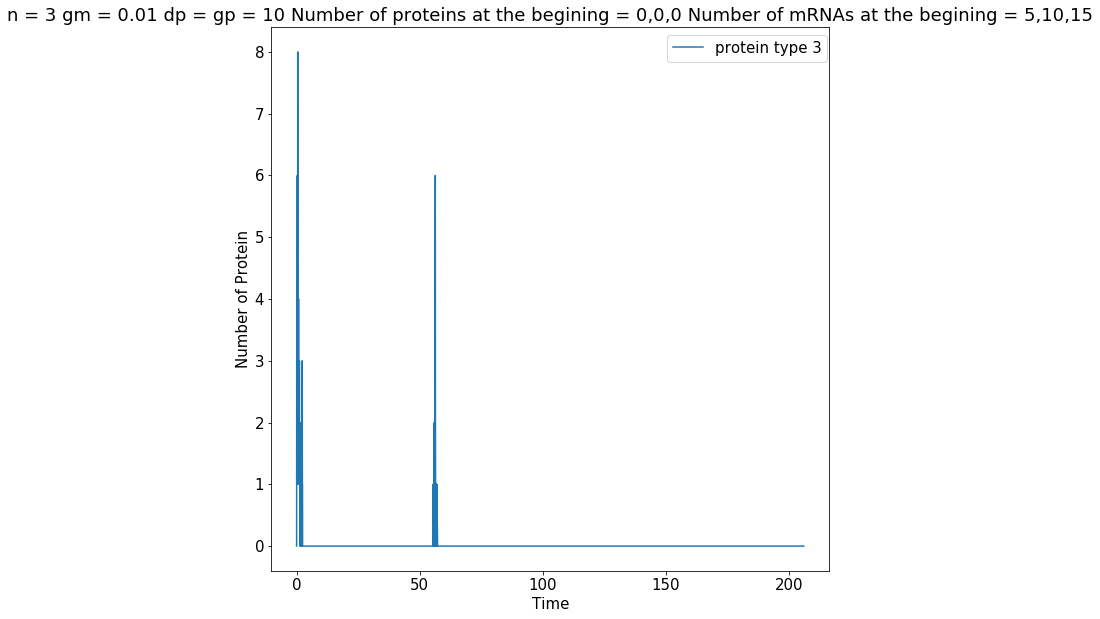

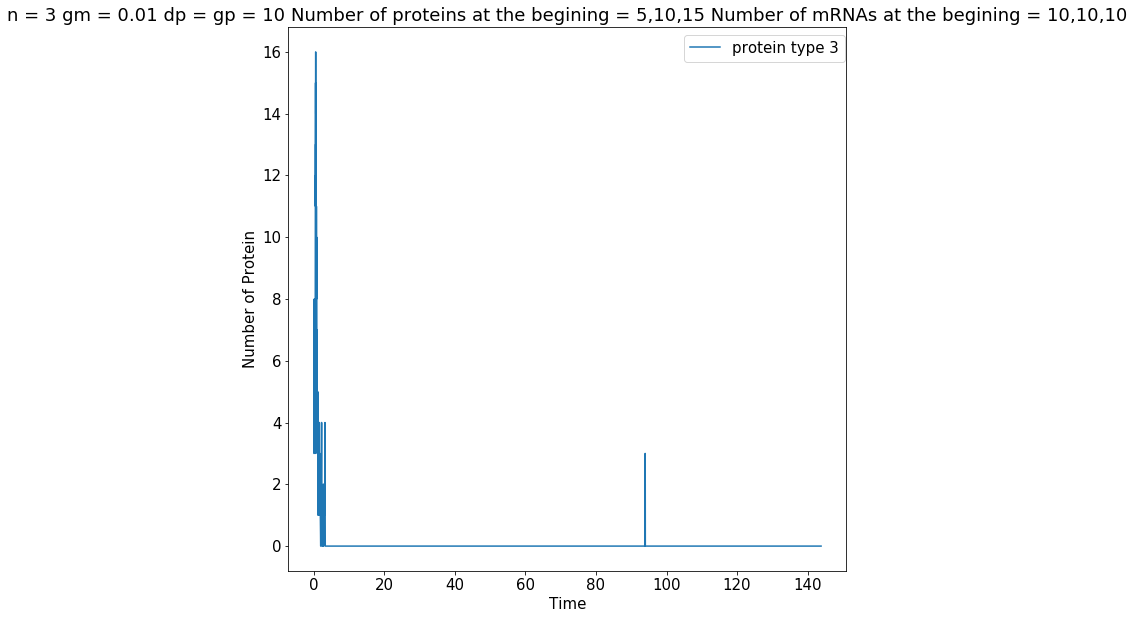

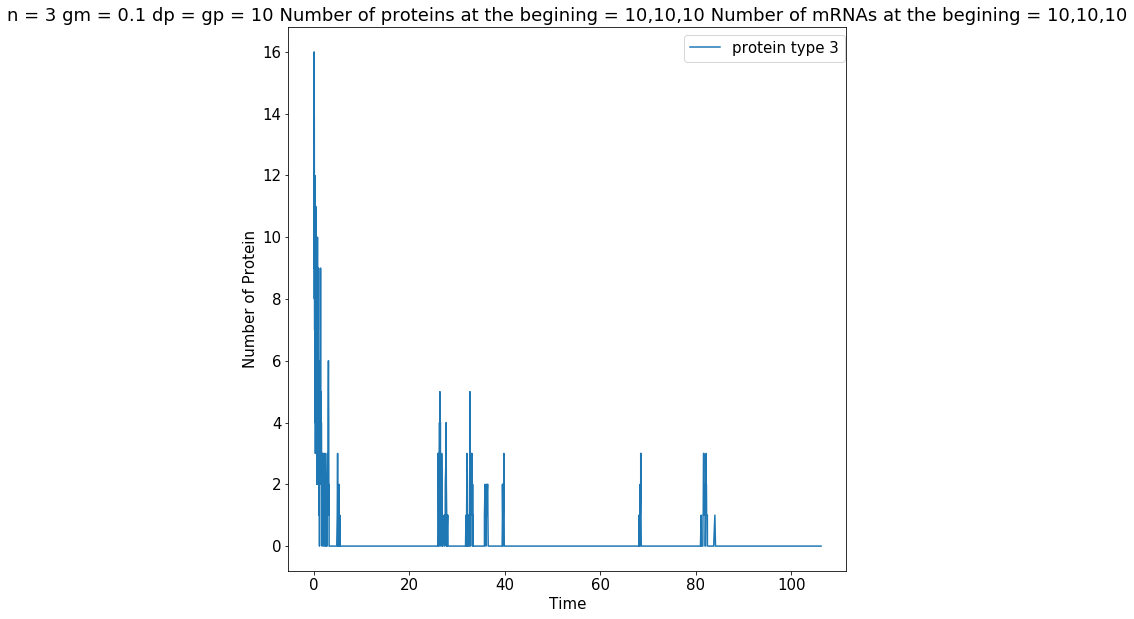

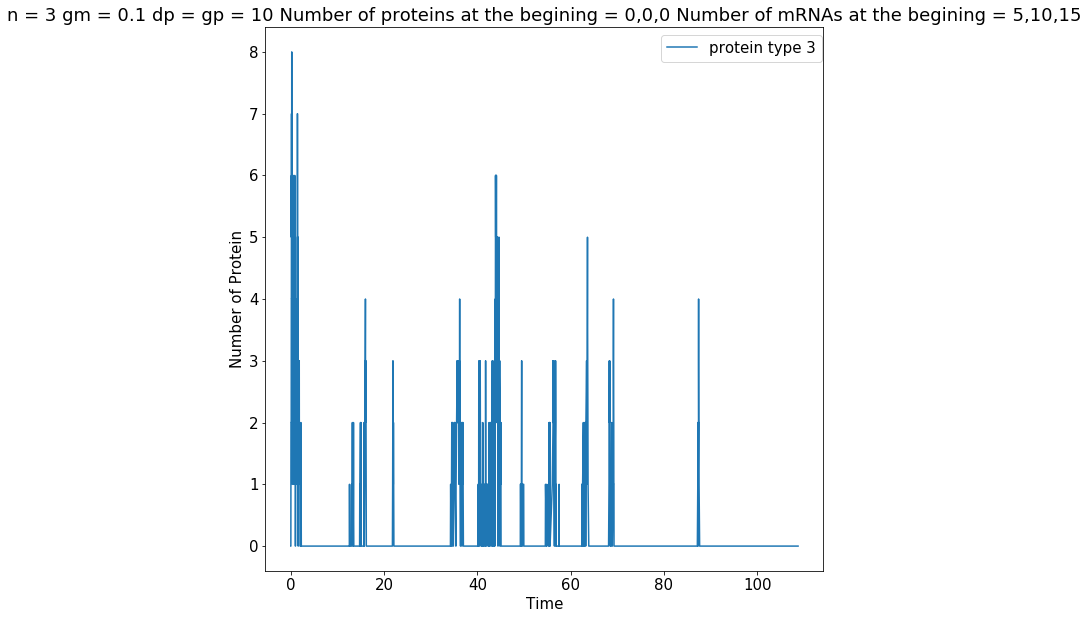

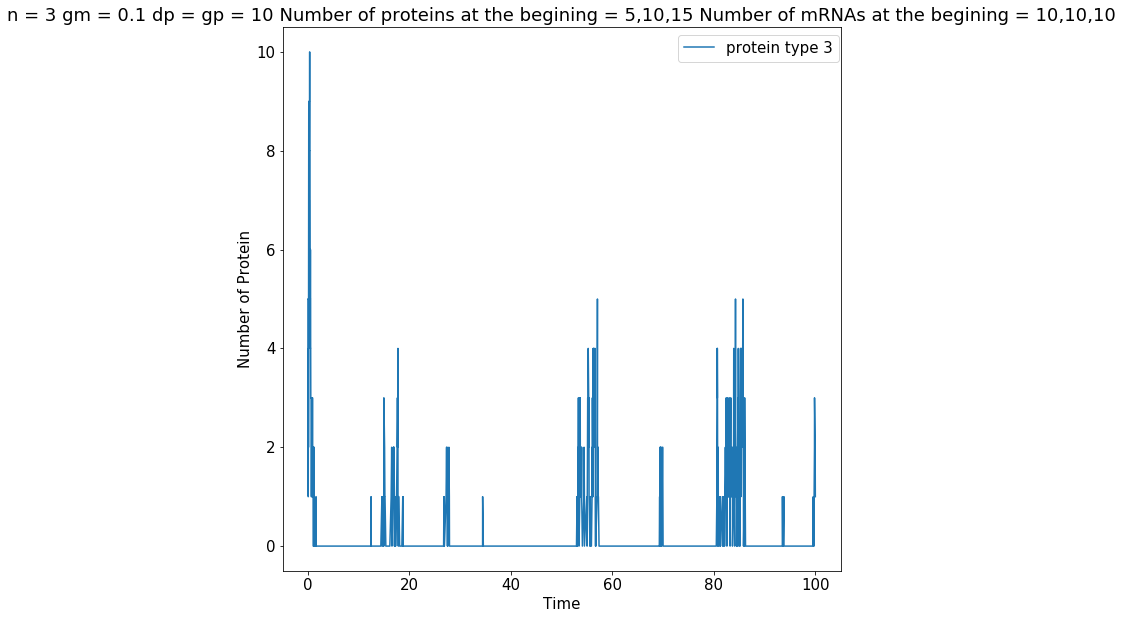

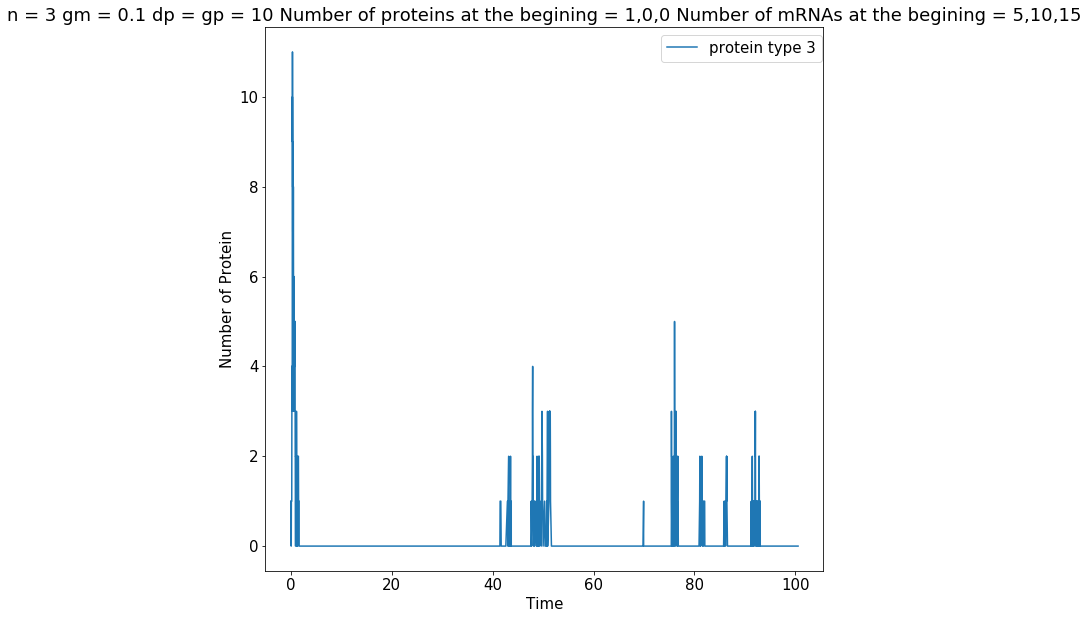

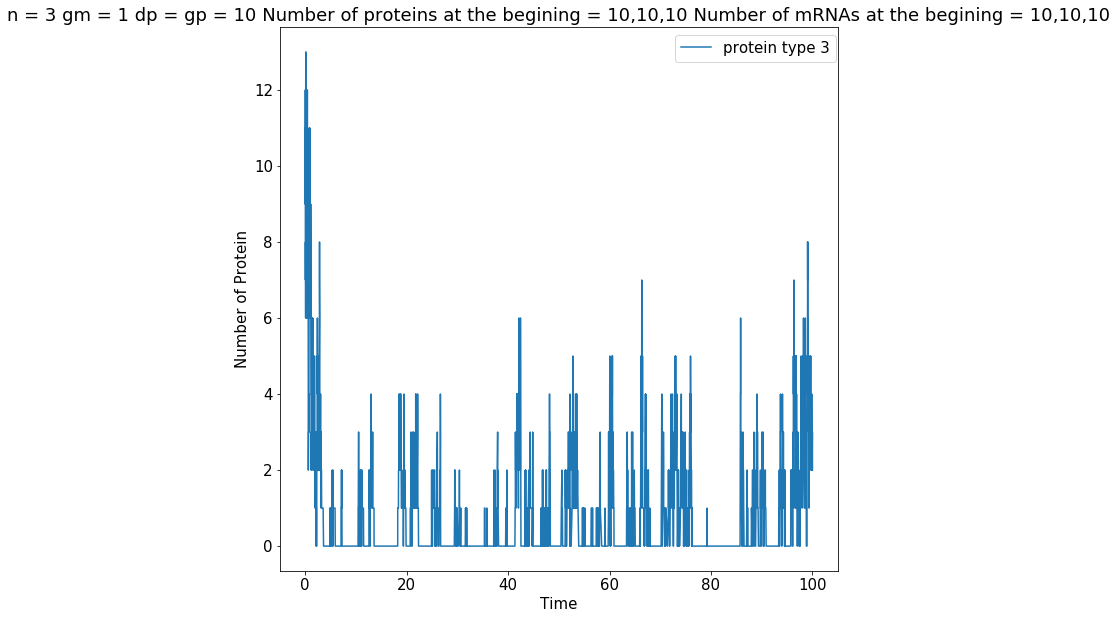

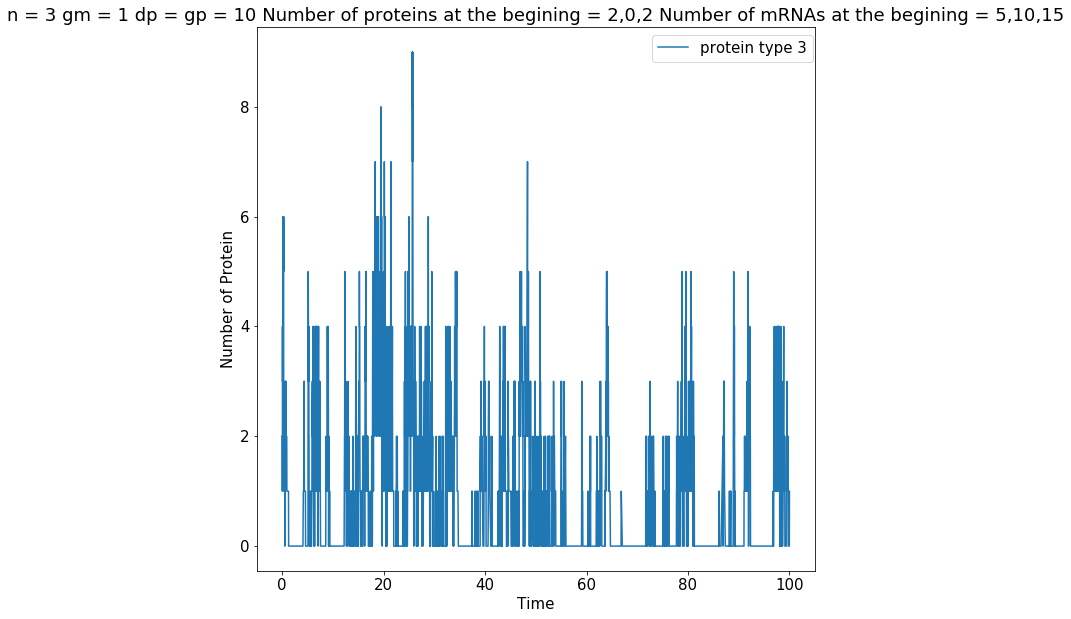

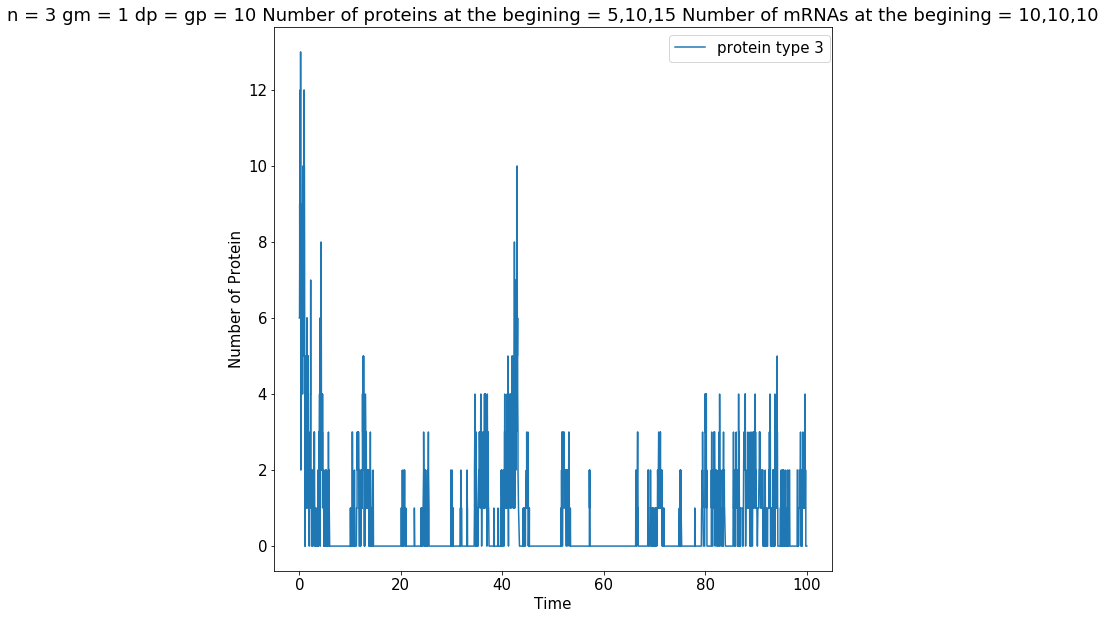

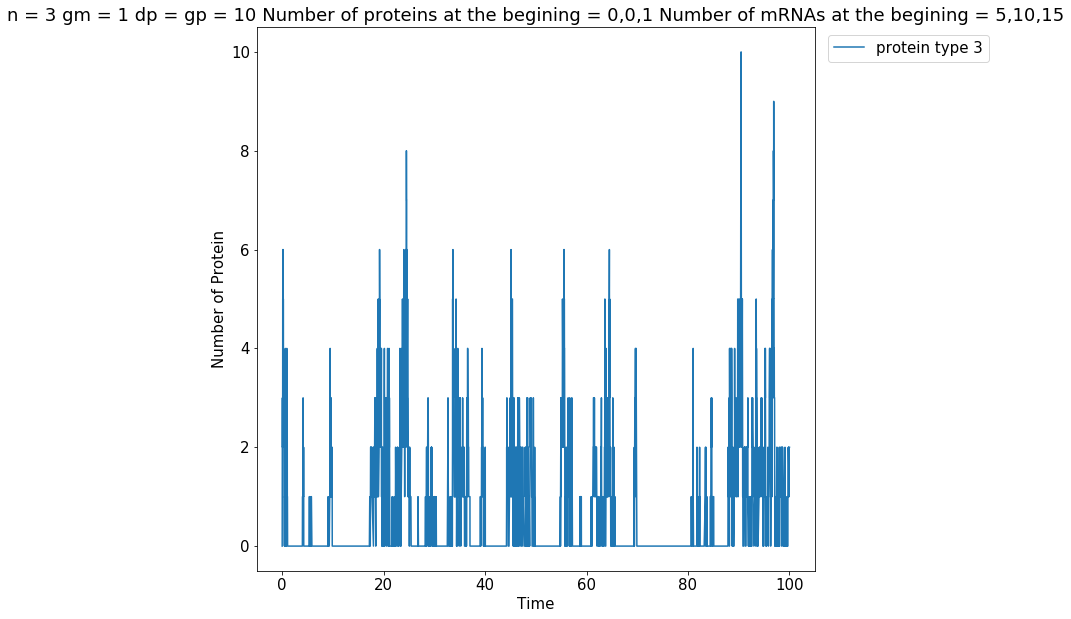

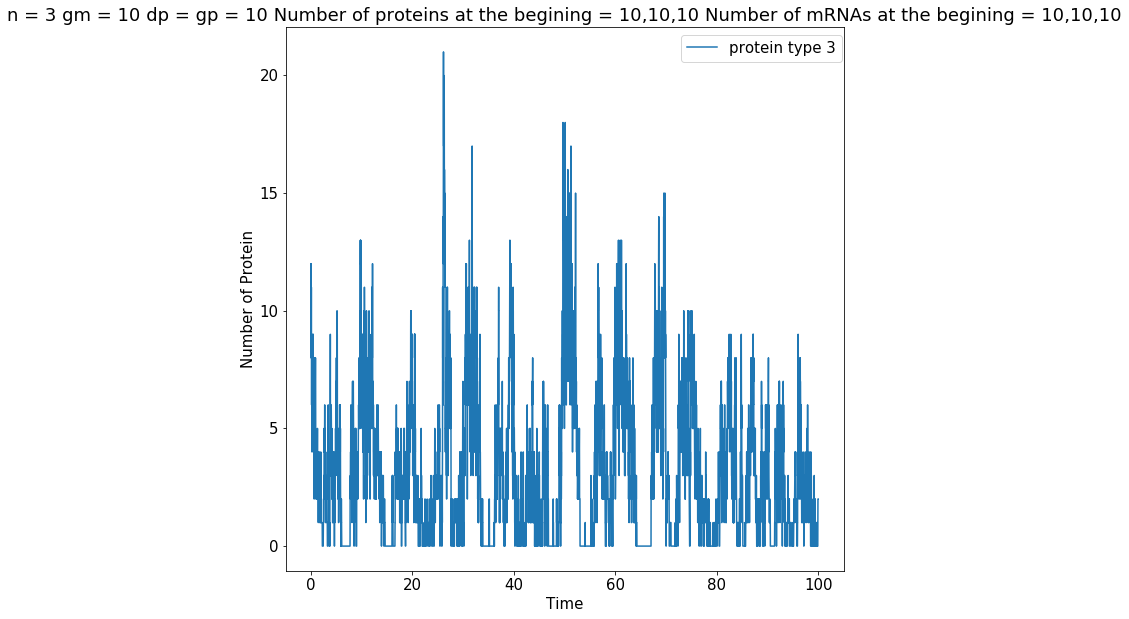

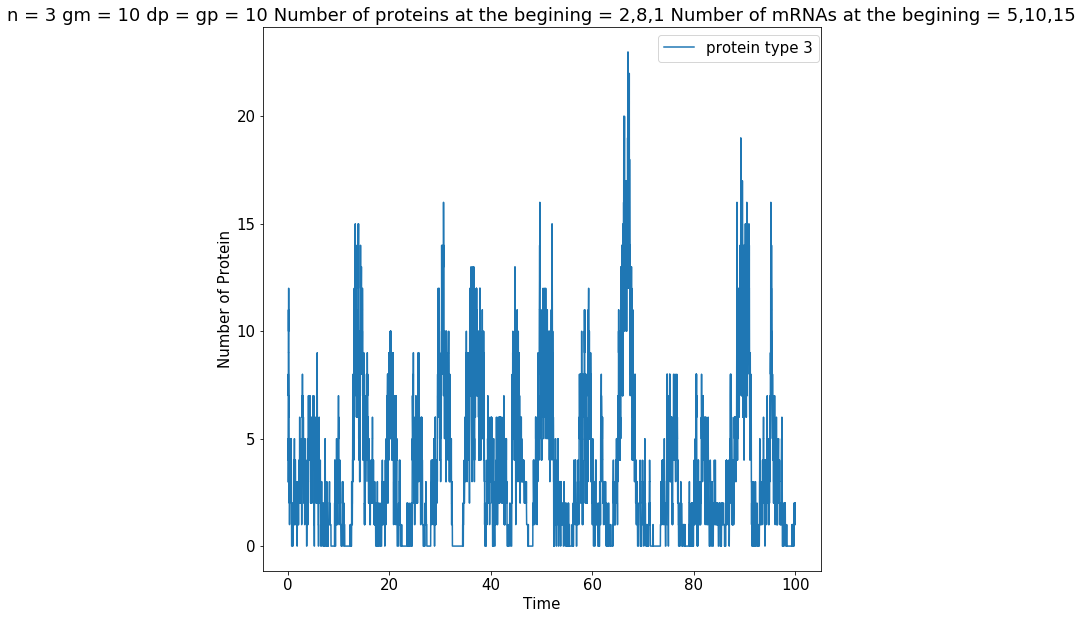

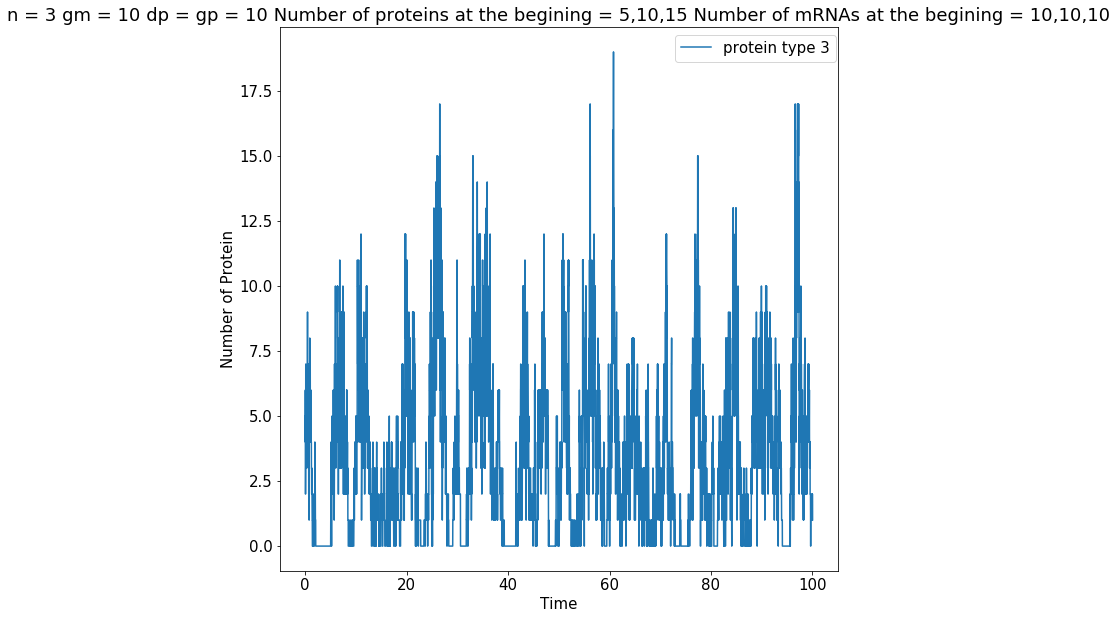

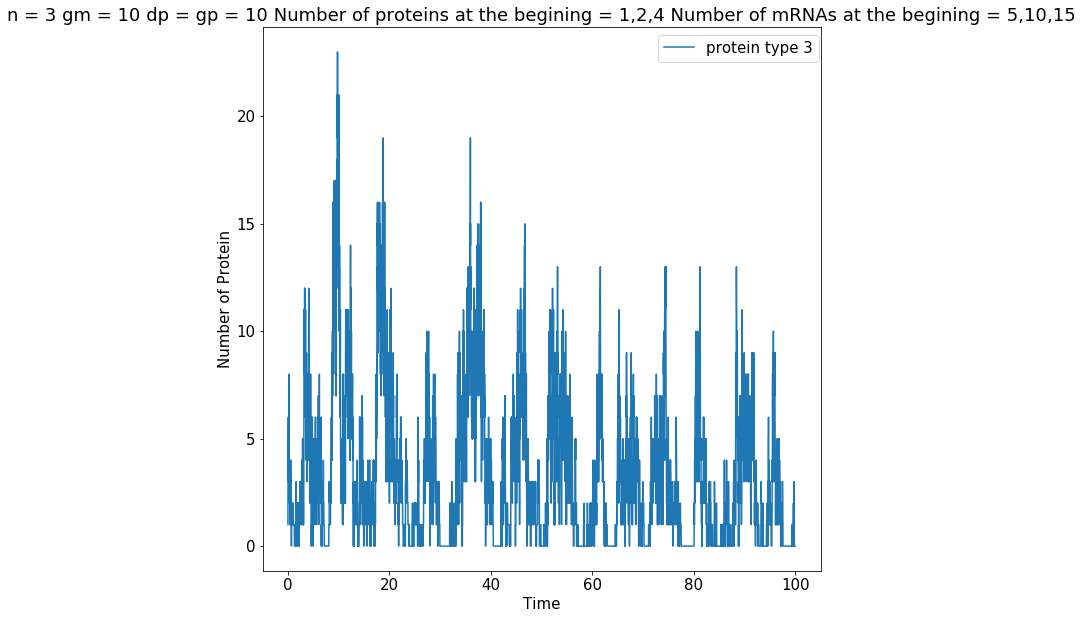

In [7]:
i=3
for name in list(time.keys()):
    plt.title( name)
    plt.xlabel("Time")
    plt.ylabel("Number of Protein")
    plt.rcParams.update({'font.size': 15})
    plt.plot(time[name],protein_tracker[name][i%3],label="protein type "+str(i))
    plt.rcParams['figure.figsize'] = 10, 10
    plt.legend(bbox_to_anchor=(1.01, 1), loc='bottom right')
    plt.show()

In [8]:
name="n = "+str(3)+" gm = "+str(10)+" dp = gp = " +str(10) +\
                        " Number of proteins at the begining = "+str(10)+','+str(10)+\
                        ','+str(10)+ " Number of mRNAs at the begining = "+str(10)+\
                        ','+str(10)+',' +str(10)
print(name)

n = 3 gm = 10 dp = gp = 10 Number of proteins at the begining = 10,10,10 Number of mRNAs at the begining = 10,10,10


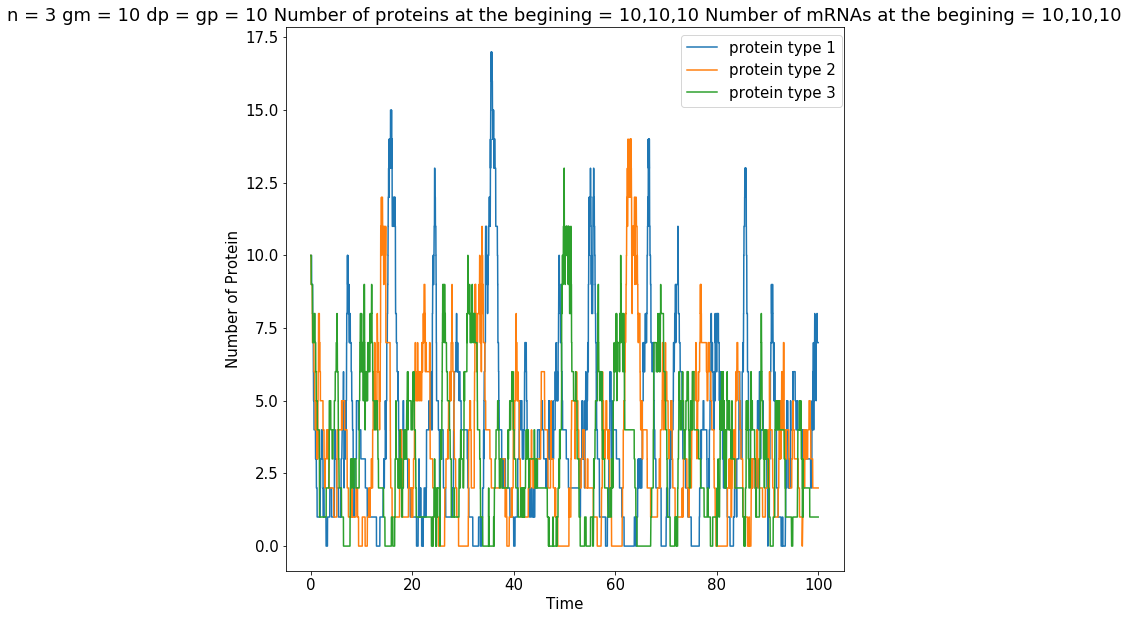

In [9]:
plt.title( name)
plt.xlabel("Time")
plt.ylabel("Number of Protein")
plt.rcParams.update({'font.size': 15})
for i in range(1,4):
    plt.plot(time[name],mRNA_tracker[name][i%3],label="protein type "+str(i))
plt.rcParams['figure.figsize'] = 10, 10
plt.legend(bbox_to_anchor=(1.01, 1), loc='bottom right')
plt.show()

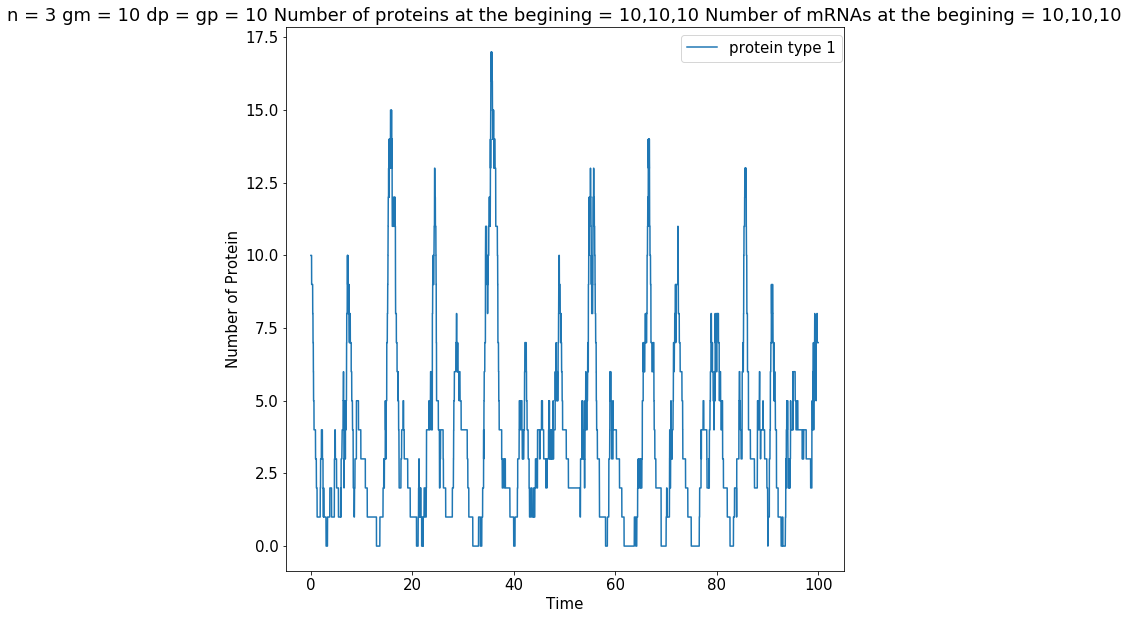

In [11]:
i=1
# for name in list(time.keys()):
    
plt.title( name)
plt.xlabel("Time")
plt.ylabel("Number of Protein")
plt.rcParams.update({'font.size': 15})
plt.plot(time[name],mRNA_tracker[name][i%3],label="protein type "+str(i))
plt.rcParams['figure.figsize'] = 10, 10
plt.legend(bbox_to_anchor=(1.01, 1), loc='bottom right')
plt.show()

In [12]:
def oscillator_finder(x,threshold):
    x=np.array(x)
    localmax = np.add(np.where(np.diff(np.sign(np.diff(x))) == -2),2)

    localmin = np.add(np.where(np.diff(np.diff(np.sign(np.diff(x)))) == +2),2)
    
    if len(localmax.reshape(-1))> 1 and len(localmin.reshape(-1)) > 1:
        amp = np.max(x[localmax[0]])  - np.min((x[localmin[0]]))
        if amp > threshold:
            return ("oscillation")
        else:
            return ("no-oscillation")
    else:
        return ("no-oscillation")

In [13]:
for name1 in list(time.keys()):
    for i in range(3):
        print("For " + name1 +" protein type "+str(i%4) +" we have "+oscillator_finder(mRNA_tracker[name][i],3))

For n = 1 gm = 0.01 dp = gp = 0.01 Number of proteins at the begining = 10,10,10 Number of mRNAs at the begining = 10,10,10 protein type 0 we have oscillation
For n = 1 gm = 0.01 dp = gp = 0.01 Number of proteins at the begining = 10,10,10 Number of mRNAs at the begining = 10,10,10 protein type 1 we have oscillation
For n = 1 gm = 0.01 dp = gp = 0.01 Number of proteins at the begining = 10,10,10 Number of mRNAs at the begining = 10,10,10 protein type 2 we have oscillation
For n = 1 gm = 0.01 dp = gp = 0.01 Number of proteins at the begining = 3,8,1 Number of mRNAs at the begining = 5,10,15 protein type 0 we have oscillation
For n = 1 gm = 0.01 dp = gp = 0.01 Number of proteins at the begining = 3,8,1 Number of mRNAs at the begining = 5,10,15 protein type 1 we have oscillation
For n = 1 gm = 0.01 dp = gp = 0.01 Number of proteins at the begining = 3,8,1 Number of mRNAs at the begining = 5,10,15 protein type 2 we have oscillation
For n = 1 gm = 0.01 dp = gp = 0.01 Number of proteins at t

For n = 3 gm = 0.01 dp = gp = 1 Number of proteins at the begining = 0,0,0 Number of mRNAs at the begining = 5,10,15 protein type 0 we have oscillation
For n = 3 gm = 0.01 dp = gp = 1 Number of proteins at the begining = 0,0,0 Number of mRNAs at the begining = 5,10,15 protein type 1 we have oscillation
For n = 3 gm = 0.01 dp = gp = 1 Number of proteins at the begining = 0,0,0 Number of mRNAs at the begining = 5,10,15 protein type 2 we have oscillation
For n = 3 gm = 0.01 dp = gp = 1 Number of proteins at the begining = 5,10,15 Number of mRNAs at the begining = 10,10,10 protein type 0 we have oscillation
For n = 3 gm = 0.01 dp = gp = 1 Number of proteins at the begining = 5,10,15 Number of mRNAs at the begining = 10,10,10 protein type 1 we have oscillation
For n = 3 gm = 0.01 dp = gp = 1 Number of proteins at the begining = 5,10,15 Number of mRNAs at the begining = 10,10,10 protein type 2 we have oscillation
For n = 3 gm = 0.1 dp = gp = 1 Number of proteins at the begining = 10,10,10 Nu

In [14]:
lmax=(np.unique(mRNA_tracker[name][1])[::-1])[0]
lmin=np.min(np.unique(mRNA_tracker[name][1]))
ilmax=np.array([])
ilmin=np.array([])
ilmax=np.where(mRNA_tracker[name][1]==8)[0]
ilmin=np.where(mRNA_tracker[name][1]==lmin)[0]
ilmax=np.sort(ilmax)
ilmin=np.sort(ilmin)

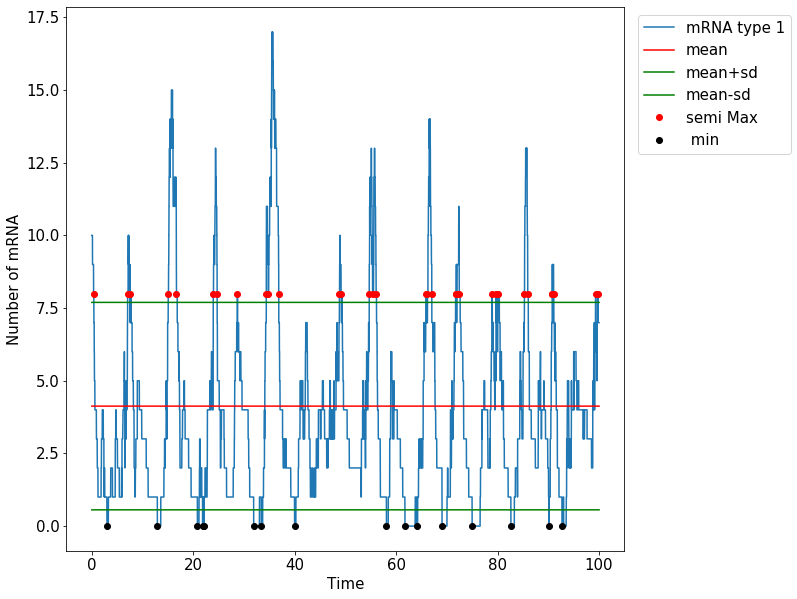

In [15]:
plt.xlabel("Time")
plt.ylabel("Number of mRNA")
plt.rcParams.update({'font.size': 15})
plt.plot(time[name],mRNA_tracker[name][1],label="mRNA type "+str(1))
plt.plot(time[name],[np.mean(mRNA_tracker[name][1])]*len(time[name]),color='red',label='mean')
plt.plot(time[name],[np.mean(mRNA_tracker[name][1])+np.std(mRNA_tracker[name][1])]*len(time[name]),\
         color='green',label='mean+sd')
plt.plot(time[name],[np.mean(mRNA_tracker[name][1])-np.std(mRNA_tracker[name][1])]*len(time[name]),\
         color='green',label='mean-sd')

plt.plot(np.array(time[name])[ilmax[np.append(True,np.diff(ilmax)>10)].astype(int)],\
         mRNA_tracker[name][1][ilmax[np.append(True,np.diff(ilmax)>10)].astype(int)],'ro',label="semi Max ")
plt.plot(np.array(time[name])[ilmin[np.append(True,np.diff(ilmin)>10)].astype(int)],\
         mRNA_tracker[name][1][ilmin[np.append(True,np.diff(ilmin)>10)].astype(int)],'o',label=" min ", color='black')
plt.rcParams['figure.figsize'] = 10, 10
plt.legend(bbox_to_anchor=(1.01, 1), loc='bottom right')
plt.show()

In [16]:
# a=[]
# mydif=[]
# for i in range(len(mRNA_tracker[name][1])-1):
#     a.append((mRNA_tracker[name][1][i+1]-mRNA_tracker[name][1][i]))
# for i in range(len(a)-1):
#     mydif.append((a[i+1]-a[i]))

# plt.plot(mydif)

# Savitzky-Golay method for smoothing

In [17]:
yhat = savgol_filter(mRNA_tracker[name][1], 901, 5)

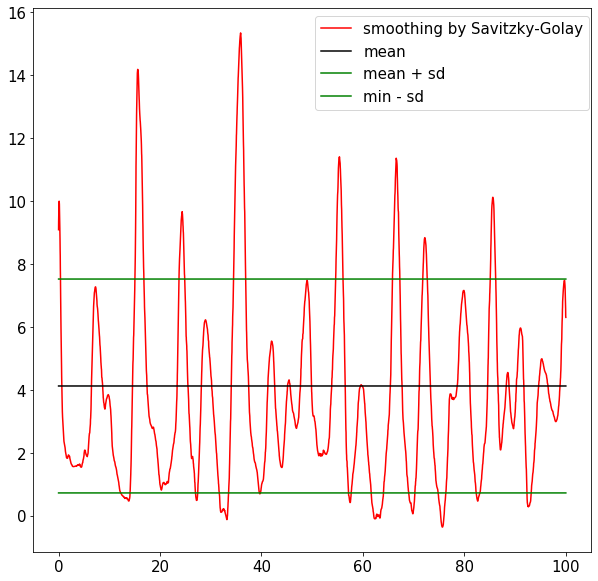

In [18]:
plt.plot(time[name],yhat, color='red',label='smoothing by Savitzky-Golay')
# plt.plot(time[name],mRNA_tracker[name][1],label="mRNA type "+str(1),color='blue')

plt.plot(time[name],[np.mean(yhat)]*len(time[name]),color='black',label='mean')
plt.plot(time[name],[np.mean(yhat)+np.std(yhat)]*len(time[name]),color='green',label='mean + sd')
plt.plot(time[name],[np.mean(yhat)-np.std(yhat)]*len(time[name]),color='green',label='min - sd')
plt.rcParams['figure.figsize'] = 10, 10
plt.legend(bbox_to_anchor=(1.01, 1), loc='bottom right')
plt.show()

## First derivation for finding oscillation

In [19]:
b=[]
c=[]
for i in range(len(time[name])-1):
    b.append((yhat[i+1]-yhat[i])/(time[name][i+1]-time[name][i]))
    if b[i]>0:
        c.append(11)
    else:
        c.append(0)
c.append(c[len(c)-1])
# c.append(c[len(c)-1])

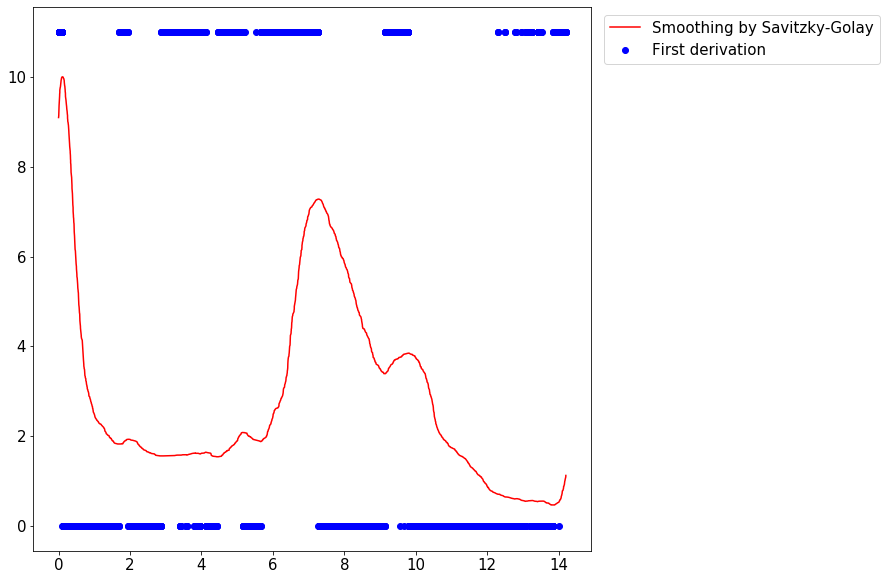

In [20]:
# plt.plot(time,mRNA_tracker[1],label="mRNA type "+str(1),color='blue')
plt.plot(time[name][0:3000],yhat[0:3000], color='red',label='Smoothing by Savitzky-Golay')
plt.plot(time[name][0:3000],c[0:3000],'o' ,color='blue',label='First derivation')

# plt.plot(time,[np.mean(yhat)]*len(time),color='black',label='mean')
# plt.plot(time,[np.mean(yhat)+np.std(yhat)]*len(time),color='green',label='sd+')
# plt.plot(time,[np.mean(yhat)-np.std(yhat)]*len(time),color='green',label='sd-')
plt.rcParams['figure.figsize'] = 10, 10
plt.legend(bbox_to_anchor=(1.01, 1), loc='bottom right')
plt.show()

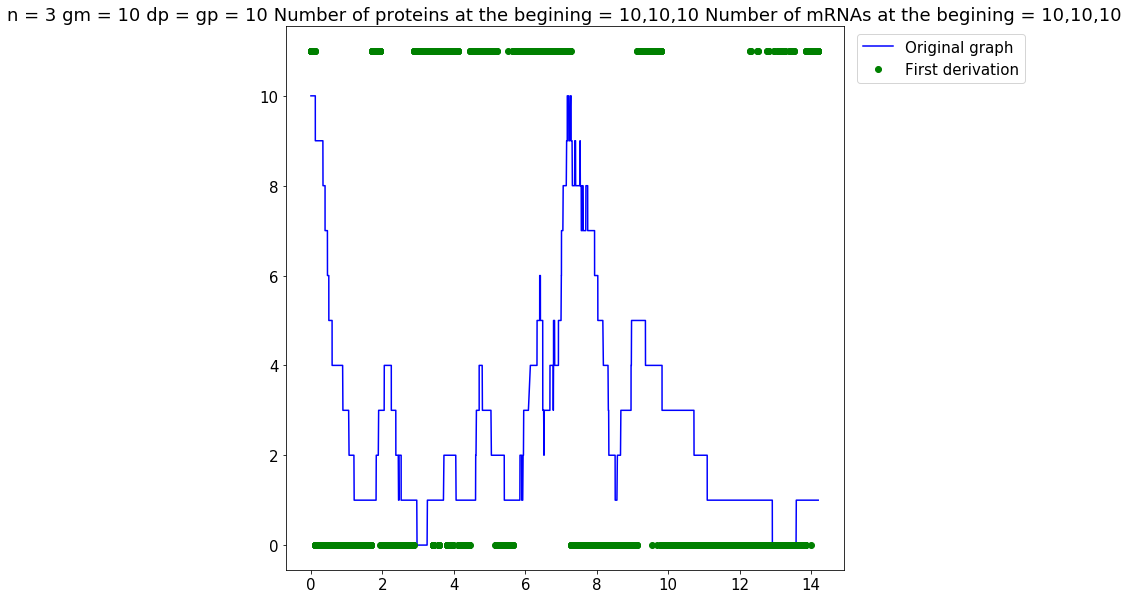

In [22]:
# plt.plot(time,mRNA_tracker[1],label="mRNA type "+str(1),color='blue')
plt.plot(time[name][0:3000],mRNA_tracker[name][1][0:3000], color='blue',label='Original graph')
plt.plot(time[name][0:3000],c[0:3000],'o' ,color='green',label='First derivation')
plt.title(name)
# plt.plot(time,[np.mean(yhat)]*len(time),color='black',label='mean')
# plt.plot(time,[np.mean(yhat)+np.std(yhat)]*len(time),color='green',label='sd+')
# plt.plot(time,[np.mean(yhat)-np.std(yhat)]*len(time),color='green',label='sd-')
plt.rcParams['figure.figsize'] = 10, 10
plt.legend(bbox_to_anchor=(1.01, 1), loc='bottom right')
plt.show()

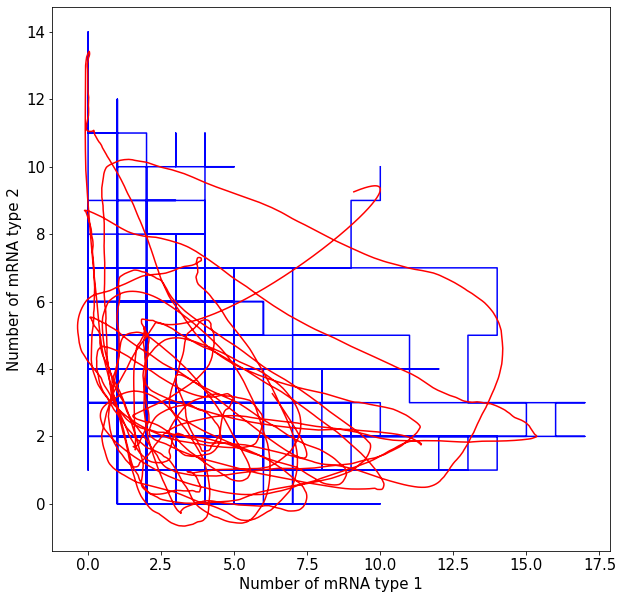

In [23]:
yhat2 = savgol_filter(mRNA_tracker[name][2], 901, 5)
plt.plot(mRNA_tracker[name][1],mRNA_tracker[name][2], color='blue',label='m1 vs m2')
plt.plot(yhat,yhat2, color='red',label='m1 vs m2 - smooth version')
plt.xlabel("Number of mRNA type 1")
plt.ylabel("Number of mRNA type 2")
plt.show()

# Find oscillations using the Fourier transform

Peaks in the Fourier transform of our time series will indicate oscillations at peak frequencies.

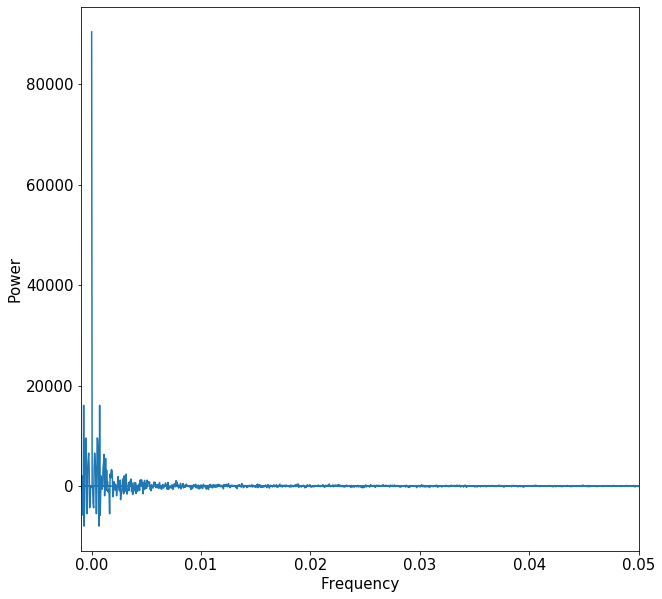

In [48]:
sp = np.fft.fft(mRNA_tracker[name][1])
freq = np.fft.fftfreq(np.array(time[name]).shape[0])
plt.plot(freq, sp.real)#, freq, sp.imag)

plt.ylabel('Power')

plt.xlabel('Frequency')

plt.xlim((-0.001,0.05))

plt.show()

There seem to be low frequency oscillations of 0-25 Hz

In [44]:
np.array(time[name]).shape[0]

21917